### LSE Data Analytics Online Career Accelerator 

# DA301:  Advanced Analytics for Organisational Impact

#  

## Prepared by: Yuliya Pauzunova

# 

# Background/context of the business scenario

Business problem: Improving overall sales performance by analysing and considering customer trends.

Analytical problem: Identify statistically significant features and segment customers to predict loyalty point balances. 
The project aims to address the following analytical objectives/questions:
1) Identify relevant features that best explain the variance in customer spending behaviour and evaluate possible relationships between features and loyalty point balances to develop predictive models.
2) Group customers based on models' predictions to increase marketing strategy efficiency by implementing tailored marketing campaigns and promotions based on the identified segments.
3) Identify and summarise common themes and opinions in product reviews and evaluate sentiment to improve overall sales performance by addressing customers' needs related to customer service or products
ucts


#  

# Data pre-processing

### 1. Prepare workstation

In [10]:
# General
import numpy as np
import pandas as pd
import math

# scipy
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
from scipy.spatial.distance import cdist

# sklearn  
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.cluster import KMeans 
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

# statsmodels
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
import statsmodels.stats.api as sms
from statsmodels.stats.stattools import durbin_watson, jarque_bera

# nltk 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
#nltk.download('vader_lexicon')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download ('punkt').
#nltk.download ('stopwords').

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import Locator, MultipleLocator

# other
import os
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from textblob import TextBlob
import re
import contractions
import emoji
from collections import Counter
from num2words import num2words
from wordcloud import WordCloud
import warnings

In [11]:
# Limit the number of threads used by MKL to a manageable value (e.g., 4)
os.environ['OMP_NUM_THREADS'] = '4'

In [12]:
# ignore warnings
warnings.filterwarnings("ignore")

In [13]:
# display all numeric values in the DataFrame in standard numeric format
pd.set_option('display.float_format', '{:.6f}'.format)

In [14]:
# disables scientific notation 
np.set_printoptions(suppress=True)

In [15]:
# Define variables to store Lexicons & methods

# Create a set of English stopwords.
english_stopwords = set(stopwords.words('english'))
#stop_words = set(stopwords.words('english'))

# Get a list of all english words so we can exclude anything that doesn't appear on the list.
all_english_words = set(words.words())

# Create a variable lemmatiser to store the WordNetLemmatizer() method.
lemmatiser = WordNetLemmatizer()

# Create a variable sia to store the SentimentIntensityAnalyser() method.
sia = SentimentIntensityAnalyzer()

In [16]:
# Load the CSV file(s) as reviews.
reviews = pd.read_csv('turtle_reviews.csv')

# View the DataFrame.
reviews.head()

gender  age  remuneration (k£)  spending_score (1-100)  loyalty_points  \
0    Male   18          12.300000                      39             210   
1    Male   23          12.300000                      81             524   
2  Female   22          13.120000                       6              40   
3  Female   25          13.120000                      77             562   
4  Female   33          13.940000                      40             366   

  education language platform  product  \
0  graduate       EN      Web      453   
1  graduate       EN      Web      466   
2  graduate       EN      Web      254   
3  graduate       EN      Web      263   
4  graduate       EN      Web      291   

                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary  
0  The fact that 50% of this space is wasted on a...  
1  Another worthless Dungeon Master's screen from...  
2                    pretty, but also pretty useless  
3                                         Five Stars  
4                                         Money trap

### 2. User-defined functions

In [18]:
# summarises key performance metrics for a regression model
# takes statsmodels linear regression object as an input
# returns a Dataframe with goodness of fit metrics 
def goodness_of_fit(y, y_pred, mlr_model, model_name_str):  
    df = pd.DataFrame({'R2': [metrics.r2_score(y, y_pred)]})
    try:
        df['R2 (train)'] = mlr_model.rsquared
    except AttributeError:
        df['R2 (train)'] = None
    try:
        df['Adj. R2 (train)'] = mlr_model.rsquared_adj
    except AttributeError:
        df['Adj. R2 (train)'] = None
    df['RMSE'] = np.sqrt(metrics.mean_squared_error(y, y_pred))
    df['MAE'] = metrics.mean_absolute_error(y, y_pred)
    df['MAPE, %'] = np.mean(np.abs((y -  y_pred) / y_pred)) * 100
    df['q1 (y_real)'] = np.percentile(y, 25)
    df['q3 (y_real)'] = np.percentile(y, 75)
    df['mean (y_real)'] = y.mean()
    df = df.T
    df.columns = [model_name_str]
    return df

In [19]:
# creates a descriptive statistics summary for a pandas DataFrame
def desc_stat_summary(df):
    numeric_df = df.select_dtypes(include=['number']).copy()
    summary = numeric_df.describe().T
    summary['range'] = summary['max'] - summary['min']
    summary['IQR'] = summary['75%'] - summary['25%']
    summary['skewness (n=0)'] = numeric_df.apply(stats.skew)
    # Standard Kurtosis 
    summary['kurtosis (n=3)'] = numeric_df.apply(lambda x: stats.kurtosis(x, fisher=False))
    summary['Shapiro-Wilk, stat (n=1)'] = numeric_df.apply(lambda x: stats.shapiro(x)[0])
    summary['Shapiro-Wilk, p-value (>0.05)'] = numeric_df.apply(lambda x: stats.shapiro(x)[1])
    summary = summary.T
    return summary

In [20]:
# summarises key evaluation metrics for a regression model
# takes statsmodels linear regression object as an input
# returns a Dataframe with a set of metrics designed to review LR assumptions 
def LR_statistics(mlr_model, X_train, model_name_str):  
    # call the Durbin-Watson statistic (check for autocorrelation)
    dw_statistic = durbin_watson(mlr_model.resid)
    df = pd.DataFrame({'Durbin-Watson statistic (1.5-2.5)': [dw_statistic]})
    # Pearson correlation coefficients for each of the x-variables and residuals (check for heterogeneity) 
    for i in X_train.columns:
        df[f"Resid. vs {i} corr"] = "{:.2f}".format(mlr_model.resid.corr(X_train[i]))
    # LM Test (heteroscedasticity)
    df['LM Test p-value (> 0.05)'] = sms.het_breuschpagan(mlr_model.resid, mlr_model.model.exog)[1]
    # check for multicollinearity
    for i in range(mlr_model.model.exog.shape[1]):
        df[f"VIF Factor: {mlr_model.model.exog_names[i]} (<10)"] = variance_inflation_factor(mlr_model.model.exog, i) 
    # drop as not informative
    df = df.drop(columns = 'VIF Factor: const (<10)')
    # JB probability (normality of error terms)
    df['JB Probability (> 0.05)'] = jarque_bera(mlr_model.resid)[1]
    df['F statistic p-value (< 0.05)'] = mlr_model.f_pvalue
    df = df.T
    df.columns = [model_name_str]
    return df

In [21]:
# Provided function.
def generate_polarity(comment):
    '''Extract polarity score (-1 to +1) for each comment'''
    return TextBlob(comment).sentiment[0]

In [22]:
# sentense tokens preprocessing: takes a string as an input and returns a 'clean' string, 
# i.e. lowercasing, contractions, emojis, etc.
def preprocess_sent(text):
    # Convert to lowercase (VADER is case-sensitive)
    text = text.lower()
    # Expand contractions
    text = contractions.fix(text)
    # Convert emojis to text
    text = emoji.demojize(text)
    # Remove URLs
    text = re.sub(r'\s*&nbsp;\s*|<a [^>]*>(.*?)<\/a>', f" {r'\1'} ", text)
    text = re.sub(r'http[^ ]+', ' ', text)
    # Replace hyphens and slashes with spaces
    text = re.sub(r'[-/]', ' ', text)
    # Convert numbers to words
    text = " ".join(num2words(int(x)) if x.isdigit() else x for x in word_tokenize(text))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # remove quotations
    text = re.sub(r'[\'"]', '', text)
    # spelling correction
    #text = str(TextBlob(text).correct())
    return text

In [23]:
# word tokens preprocessing: takes a list of word tokens as input and
# returns a list of word tokens w/o stopwords and digits.
def preprocess_words(w_list):
    # Remove stopwords from word_tokens_clean
    w_list = [word for word in w_list if word not in english_stopwords]
    # remove digits
    w_list = [word for word in w_list if not re.search(r'\d', word)]
    return w_list

In [24]:
# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):  # Adjective
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):  # Verb
        return wordnet.VERB
    elif treebank_tag.startswith('N'):  # Noun
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):  # Adverb
        return wordnet.ADV
    else:
        return None

In [25]:
# Define a function to replace multiple words in a string based on a dictionary
def replace_all(text, replace_dict):
    for key, value in replace_dict.items():
        text = text.replace(key, value)
    return text

### 3. Basic sense-check

In [27]:
# Sense-check the DataFrame to determine the column names
reviews.columns

Index(['gender', 'age', 'remuneration (k£)', 'spending_score (1-100)',
       'loyalty_points', 'education', 'language', 'platform', 'product',
       'review', 'summary'],
      dtype='object')

Action: Change column headings to names that are easier to reference

In [29]:
# Sense-check the DataFrame to determine number of rows and columns
reviews.shape

(2000, 11)

In [30]:
# Determine the descriptive statistics
reviews.describe()

age  remuneration (k£)  spending_score (1-100)  loyalty_points  \
count 2000.000000        2000.000000             2000.000000     2000.000000   
mean    39.495000          48.079060               50.000000     1578.032000   
std     13.573212          23.123984               26.094702     1283.239705   
min     17.000000          12.300000                1.000000       25.000000   
25%     29.000000          30.340000               32.000000      772.000000   
50%     38.000000          47.150000               50.000000     1276.000000   
75%     49.000000          63.960000               73.000000     1751.250000   
max     72.000000         112.340000               99.000000     6847.000000   

           product  
count  2000.000000  
mean   4320.521500  
std    3148.938839  
min     107.000000  
25%    1589.250000  
50%    3624.000000  
75%    6654.000000  
max   11086.000000

Observation: age ranges from 17 to 72; remineration from 12.3 to 112.3; spending score within expected range (0-100); loyalty points: from 25 to 6847; no missing values. Product is categorical in nature stats are not meaningful;

In [32]:
# Determine the metadata pre-cleaning
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  2000 non-null   object 
 1   age                     2000 non-null   int64  
 2   remuneration (k£)       2000 non-null   float64
 3   spending_score (1-100)  2000 non-null   int64  
 4   loyalty_points          2000 non-null   int64  
 5   education               2000 non-null   object 
 6   language                2000 non-null   object 
 7   platform                2000 non-null   object 
 8   product                 2000 non-null   int64  
 9   review                  2000 non-null   object 
 10  summary                 2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 172.0+ KB


No missing values identified

Decision: cast object to string; cast product to string as it is categorical in nature

In [35]:
# review the number of unique values in each column
for i in reviews.columns:
    if reviews[i].nunique() <=5:
        print(f"{i}:",reviews[i].nunique(),'; ',reviews[i].unique())
    else: print(f"{i}:",reviews[i].nunique())

gender: 2 ;  ['Male' 'Female']
age: 45
remuneration (k£): 64
spending_score (1-100): 84
loyalty_points: 627
education: 5 ;  ['graduate' 'PhD' 'diploma' 'postgraduate' 'Basic']
language: 1 ;  ['EN']
platform: 1 ;  ['Web']
product: 200
review: 1980
summary: 1432


Observation / Decission: 
- Remove redundant columns (language and platform) as no value.
- Rename education parameter values for presentation purposes 

### 4. Data cleaning  

#### 4.1 Drop redundant columns

In [39]:
# Drop unnecessary columns.
reviews.drop(columns=['language', 'platform'], inplace=True)

# View column names.
reviews.columns

Index(['gender', 'age', 'remuneration (k£)', 'spending_score (1-100)',
       'loyalty_points', 'education', 'product', 'review', 'summary'],
      dtype='object')

#### 4.2 Rename features

In [41]:
# Rename the column headers.
reviews = reviews.rename(columns={'remuneration (k£)': 'remuneration',
                                  'spending_score (1-100)': 'spending_score'})

# View column names.
reviews.columns

Index(['gender', 'age', 'remuneration', 'spending_score', 'loyalty_points',
       'education', 'product', 'review', 'summary'],
      dtype='object')

#### 4.3 Change data types

In [43]:
# cast 'product' to string as it is categorical in nature
reviews['product'] = reviews['product'].astype('string')

# view dtypes
reviews['product'].dtypes

string[python]

In [44]:
# cast object fields to string for ease of visualisation
for i in reviews.columns:
    if reviews[i].dtypes == 'O':
        reviews[i] = reviews[i].astype('string')

# view dtypes
reviews.dtypes

gender            string[python]
age                        int64
remuneration             float64
spending_score             int64
loyalty_points             int64
education         string[python]
product           string[python]
review            string[python]
summary           string[python]
dtype: object

#### 4.4 Clean categorical features

In [46]:
# Rename education parameter values for presentation purposes.
reviews['education'] = reviews['education'].replace({'graduate': 'Graduate',
                      'PhD': 'PhD',
                      'diploma': 'High-school',
                      'postgraduate': 'Postgraduate',
                      'Basic': 'Pre-school'})
# View values.
reviews['education'].unique()

<StringArray>
['Graduate', 'PhD', 'High-school', 'Postgraduate', 'Pre-school']
Length: 5, dtype: string

### 5. Sense-check (post-cleaning) and Explore

#### 5.1 Basic sense-check

All the stats as expected

In [50]:
# Sense-check the DataFrame to determine the column names
reviews.columns

Index(['gender', 'age', 'remuneration', 'spending_score', 'loyalty_points',
       'education', 'product', 'review', 'summary'],
      dtype='object')

In [51]:
# Sense-check the DataFrame to determine number of rows and columns
reviews.shape

(2000, 9)

In [52]:
# Determine the descriptive statistics
reviews.describe()

age  remuneration  spending_score  loyalty_points
count 2000.000000   2000.000000     2000.000000     2000.000000
mean    39.495000     48.079060       50.000000     1578.032000
std     13.573212     23.123984       26.094702     1283.239705
min     17.000000     12.300000        1.000000       25.000000
25%     29.000000     30.340000       32.000000      772.000000
50%     38.000000     47.150000       50.000000     1276.000000
75%     49.000000     63.960000       73.000000     1751.250000
max     72.000000    112.340000       99.000000     6847.000000

In [53]:
# Determine the metadata 
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          2000 non-null   string 
 1   age             2000 non-null   int64  
 2   remuneration    2000 non-null   float64
 3   spending_score  2000 non-null   int64  
 4   loyalty_points  2000 non-null   int64  
 5   education       2000 non-null   string 
 6   product         2000 non-null   string 
 7   review          2000 non-null   string 
 8   summary         2000 non-null   string 
dtypes: float64(1), int64(3), string(5)
memory usage: 140.8 KB


In [54]:
# review the number of unique values in each column
for i in reviews.columns:
    if reviews[i].nunique() <=5:
        print(f"{i}:",reviews[i].nunique(),'unique values; ',list(reviews[i].unique()))
    elif reviews[i].dtypes != 'string[python]':
        print(f"{i}:",reviews[i].nunique(),'unique values; min/max range [',reviews[i].min(),',',reviews[i].max(),']')
    else: print(f"{i}:",reviews[i].nunique())

gender: 2 unique values;  ['Male', 'Female']
age: 45 unique values; min/max range [ 17 , 72 ]
remuneration: 64 unique values; min/max range [ 12.3 , 112.34 ]
spending_score: 84 unique values; min/max range [ 1 , 99 ]
loyalty_points: 627 unique values; min/max range [ 25 , 6847 ]
education: 5 unique values;  ['Graduate', 'PhD', 'High-school', 'Postgraduate', 'Pre-school']
product: 200
review: 1980
summary: 1432


All the stats as expected

#### 5.2 Duplicates analysis

In [57]:
# Determine whether there are duplicate reviews
reviews.duplicated().sum()

0

No duplicate reviews

In [59]:
reviews.columns

Index(['gender', 'age', 'remuneration', 'spending_score', 'loyalty_points',
       'education', 'product', 'review', 'summary'],
      dtype='object')

In [60]:
# Determine whether there are duplicate customers
# subset customer features (everything except for reviews and summary)
reviews_demogr = reviews[['gender', 'age', 'remuneration', 'spending_score', 'loyalty_points', 'education']]

# view the number of duplicates
reviews_demogr.duplicated().sum()

1218

Observation:
- Duplicate analysis based on subset customer features subset (incl. 'gender', 'age', 'remuneration', 'spending_score', 'loyalty_points', 'education') indicated 1218 duplicates.

In [62]:
# view the duplicate values 
reviews_demogr[reviews_demogr.duplicated() == True].sort_values(list(reviews_demogr.columns))

gender  age  remuneration  spending_score  loyalty_points     education
314   Female   17     53.300000              48            1071  Postgraduate
514   Female   17     53.300000              48            1071  Postgraduate
714   Female   17     53.300000              48            1071  Postgraduate
914   Female   17     53.300000              48            1071  Postgraduate
1114  Female   17     53.300000              48            1071  Postgraduate
...      ...  ...           ...             ...             ...           ...
470     Male   72     40.180000              55            1322           PhD
670     Male   72     40.180000              55            1322           PhD
870     Male   72     40.180000              55            1322           PhD
1070    Male   72     40.180000              55            1322           PhD
1270    Male   72     40.180000              55            1322           PhD

[1218 rows x 6 columns]

**Assumption:**

- Based on subset records analysis, each group of duplicate records is assumed to be associated with a distinct customer ID.

**Rationale:**
- The alternative option with multiple groups of customers sharing identical (for each of the group) demographic characteristics, as well as annual income and loyalty points appears hardly probable. Since no additional clarifications have been made available to us until now we proceed with further analysis based on the assumption stated above. 

In [64]:
# summarise the number of unique products reviewed per customer and the total number of reviews per customer in the sample.
# save as a separate DataFrame
customers = reviews.drop(columns=['summary']).groupby(by=list(reviews_demogr.columns))\
.agg({'product':'nunique', 'review':'count'}).reset_index()\
.sort_values(by='review', ascending=False)

customers.rename(columns={'product': 'nunique_product', 'review': 'count_review'}, inplace=True)

customers

gender  age  remuneration  spending_score  loyalty_points     education  \
145  Female   33     32.800000              42             904      Graduate   
256  Female   38     84.460000              85            5019      Graduate   
368  Female   50     36.080000              50            1338  Postgraduate   
241  Female   38     49.200000              40            1376           PhD   
191  Female   36     47.560000              60            1951           PhD   
..      ...  ...           ...             ...             ...           ...   
307  Female   44     46.740000              55            1879  Postgraduate   
308  Female   44     72.160000              15             791           PhD   
309  Female   45     22.960000              14             236  Postgraduate   
310  Female   45     27.880000              17             348      Graduate   
781    Male   72    112.340000              18            1210           PhD   

     nunique_product  count_review  
145                8             9  
256                7             8  
368                7             8  
241                7             8  
191                7             8  
..               ...           ...  
307                1             1  
308                1             1  
309                1             1  
310                1             1  
781                1             1  

[782 rows x 8 columns]

Observation: 
- Number of unique products reviewed per customer ranges from 1 to 8 in the sample.
- Total number of reviews per customer ranges from 1 to 9 in the sample.

In [66]:
# save as a separate DataFrame
customers = customers.drop(columns=['nunique_product', 'count_review'])

# view
customers

gender  age  remuneration  spending_score  loyalty_points     education
145  Female   33     32.800000              42             904      Graduate
256  Female   38     84.460000              85            5019      Graduate
368  Female   50     36.080000              50            1338  Postgraduate
241  Female   38     49.200000              40            1376           PhD
191  Female   36     47.560000              60            1951           PhD
..      ...  ...           ...             ...             ...           ...
307  Female   44     46.740000              55            1879  Postgraduate
308  Female   44     72.160000              15             791           PhD
309  Female   45     22.960000              14             236  Postgraduate
310  Female   45     27.880000              17             348      Graduate
781    Male   72    112.340000              18            1210           PhD

[782 rows x 6 columns]

In [67]:
customers_full = customers.copy()
customers_full.reset_index(inplace=True)
customers_full.drop(columns=['index'], inplace=True)
customers_full.reset_index(inplace=True)
customers_full.columns = ['customer_ID'] + list(customers.columns)
customers_full['customer_ID'] = customers_full['customer_ID'].astype('string')

customers_full.head()

customer_ID  gender  age  remuneration  spending_score  loyalty_points  \
0           0  Female   33     32.800000              42             904   
1           1  Female   38     84.460000              85            5019   
2           2  Female   50     36.080000              50            1338   
3           3  Female   38     49.200000              40            1376   
4           4  Female   36     47.560000              60            1951   

      education  
0      Graduate  
1      Graduate  
2  Postgraduate  
3           PhD  
4           PhD

#### 5.3 Data exploration

##### 5.3.1 Numeric features: scatterplots

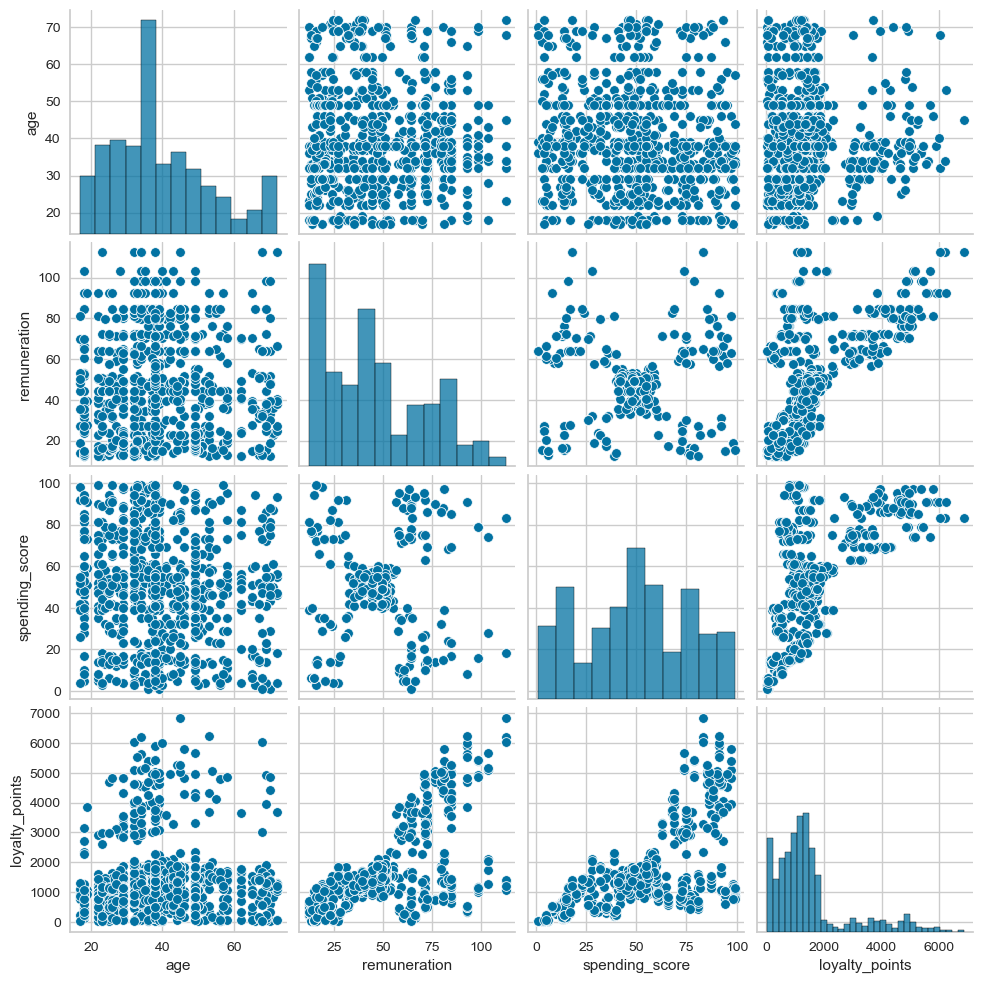

In [70]:
# visualise the distributions & relationships beetween numeric variables   
sns.pairplot(customers)

In [71]:
# Pearson correlation to evaluate linear relationships
customers.corr(method='pearson', numeric_only=True)

age  remuneration  spending_score  loyalty_points
age             1.000000      0.006024       -0.124630        0.028904
remuneration    0.006024      1.000000       -0.001645        0.630901
spending_score -0.124630     -0.001645        1.000000        0.632116
loyalty_points  0.028904      0.630901        0.632116        1.000000

The Pearson correlation coefficients of 0.63 indicates a moderate positive correlation in the 'remuneration ¬ loyalty points' and 'spending score ¬ loyalty points' pairs

In [73]:
# Spearman rank correlation to capture possible non-linear but monotonic relationships (e.g. exponential, logarithmic)
customers.corr(method='spearman', numeric_only=True)

age  remuneration  spending_score  loyalty_points
age             1.000000      0.030325       -0.137092        0.099044
remuneration    0.030325      1.000000        0.005013        0.623298
spending_score -0.137092      0.005013        1.000000        0.634250
loyalty_points  0.099044      0.623298        0.634250        1.000000

Spearman rank correlation analysis indicates a strong positive monotonic relationship (potentially exponential) in the 'remuneration ¬ loyalty points' and 'spending score ¬ loyalty points' pairs with rho of 0.62 and 0.63 respectively, and no correlation in the ‘age ¬ loyalty points’ pair.

In [75]:
# Kendall Tau correlation coefficient  to capture possible non-linear but monotonic relationships (e.g. exponential, logarithmic)
customers.corr(method='kendall', numeric_only=True)

age  remuneration  spending_score  loyalty_points
age             1.000000      0.019435       -0.091438        0.067794
remuneration    0.019435      1.000000       -0.005721        0.485280
spending_score -0.091438     -0.005721        1.000000        0.478999
loyalty_points  0.067794      0.485280        0.478999        1.000000

Observations: 

- The distribution of Loyalty points (the independent variable) is right-skewed. Transformation is required to meet the linear regression assumptions.
- No obvious linear relationship between 'age' and any other features.
- Potential linear relationship between spending score & loyalty points and remuneration & loyalty points
- Clusters based on spending score & remuneration.

##### 5.3.2 Numeric features: boxplots

In [78]:
# prepare customers df for visualisation
df_viz1 = customers.select_dtypes(include=['float', 'int']).melt()

#view
#df_viz1.head(2)

<Axes: xlabel='variable', ylabel='value'>

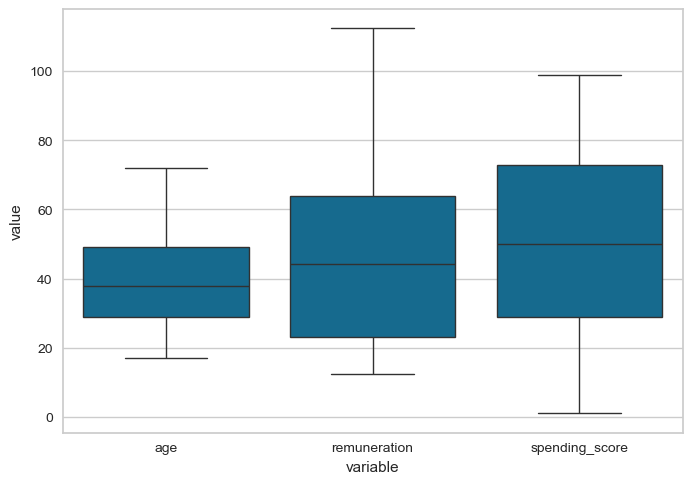

In [79]:
sns.boxplot(data=df_viz1[df_viz1.variable != 'loyalty_points'], x='variable', y='value')

There are no outliers in age, remuneration and spending score features (no observations beyond 1.5 IQR from 1st/3rd quartiles)

<Axes: xlabel='variable', ylabel='value'>

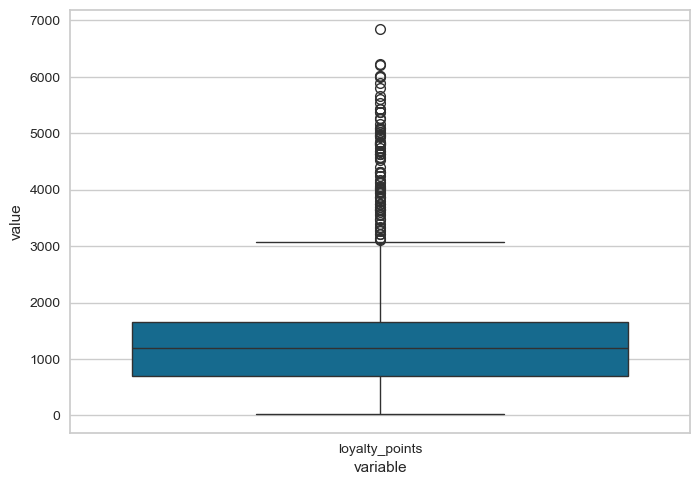

In [81]:
sns.boxplot(data=df_viz1[df_viz1.variable == 'loyalty_points'], x='variable', y='value')

<Axes: xlabel='gender', ylabel='loyalty_points'>

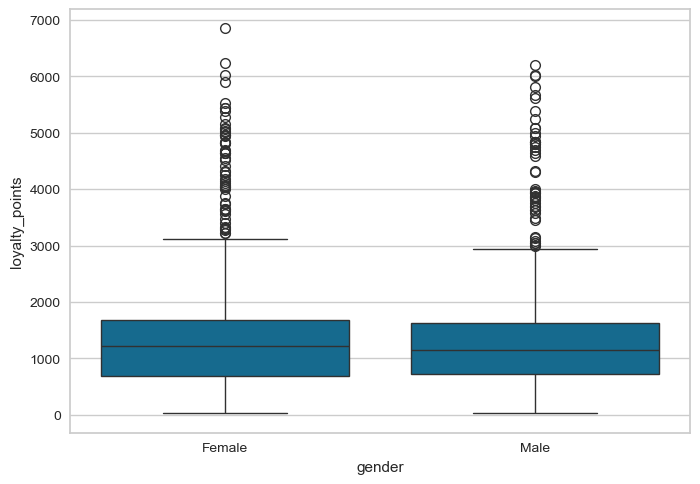

In [82]:
sns.boxplot(data=customers, x='gender', y='loyalty_points')

No noticeable difference in the distribution by gender. 

<Axes: xlabel='education', ylabel='loyalty_points'>

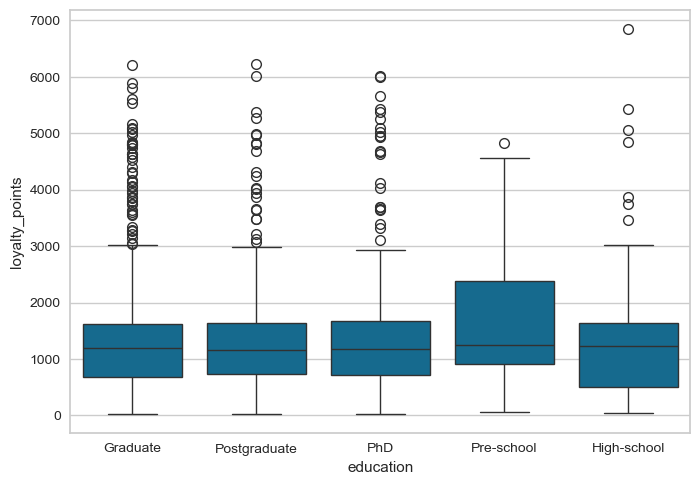

In [84]:
sns.boxplot(data=customers, x='education', y='loyalty_points')

In [85]:
customers.education.value_counts()

education
Graduate        347
PhD             182
Postgraduate    158
High-school      75
Pre-school       20
Name: count, dtype: Int64

No noticeable difference in the distribution by education level, with the exception of pre-school (not meaningful for the small count in this category).

Given the non-normality of the distributions, Turkey's method and the three-sigma rule are not applicable, and no records were removed.

Transformation is required to meet the linear regression assumptions.

##### 5.3.3 Categorical features: countplots

<Axes: xlabel='gender', ylabel='count'>

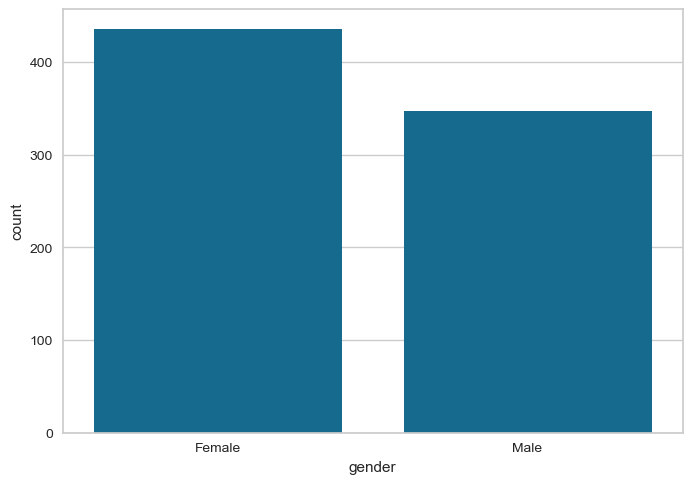

In [89]:
sns.countplot(data=customers, x='gender')

Roughly equal split by gender

<Axes: xlabel='education', ylabel='count'>

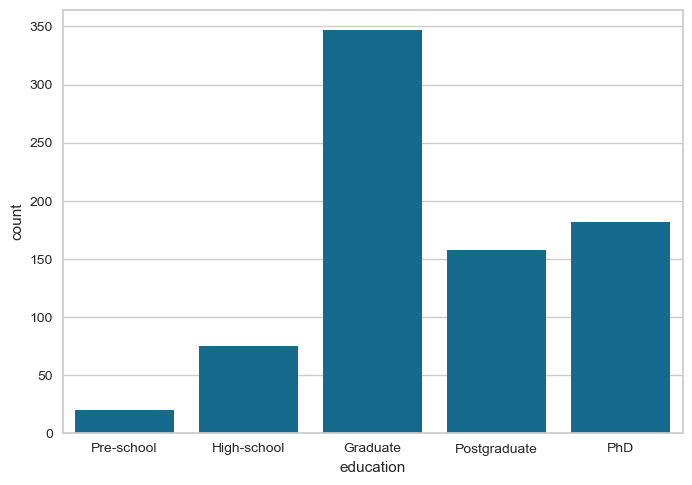

In [91]:
sns.countplot(data=customers, x='education', order=['Pre-school', 'High-school', 'Graduate', 'Postgraduate', 'PhD'])

Ordinal feature. Most of the customers are graduates or above by education. 

<Axes: xlabel='product', ylabel='count'>

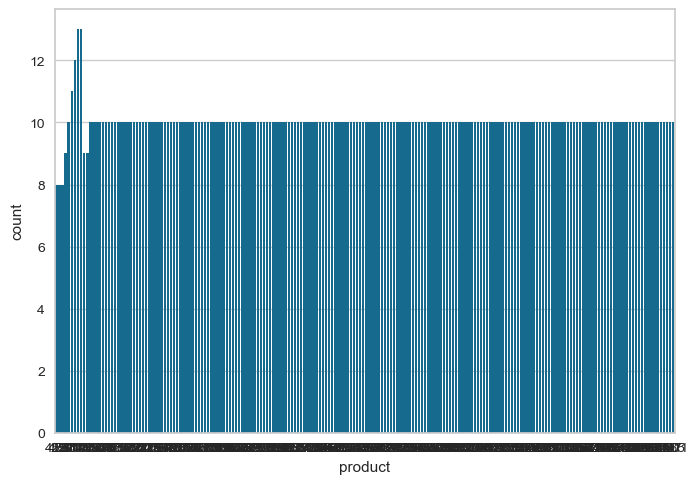

In [93]:
sns.countplot(data=reviews, x='product')

Observation: 

The dataset includes 10 reviews for most of the products which suggests non-random sampling.

The non-random sample composition may introduce bias, as it might not reflect the actual sales structure by cluster/product and misrepresent certain demographic groups or products 

RECOMMEND: To perform inferential analysis using hypothesis testing and confidence intervals. 

In [95]:
reviews[reviews['product'] == '10241'][['product', 'review']].style.set_properties(subset=['review'], **{'width': '1200px'})

**Observation:**

A brief analysis of reviews associated with unique product ID suggests that the product feature appears inconsistent, with a single ID being assigned to multiple different product types, and that product feature is not meaningfull. For example: product 10241 includeds Peppa Pig, Axis & Allies Miniatures and Lords of Waterdeep)

Decission: drop product feature.

In [97]:
# Drop unnecessary columns.
reviews.drop(columns=['product'], inplace=True)

# View column names.
reviews.columns

Index(['gender', 'age', 'remuneration', 'spending_score', 'loyalty_points',
       'education', 'review', 'summary'],
      dtype='object')

### 6. Save the DataFrame as a CSV file

The code snippets below are retained for demonstration purposes; and commented out as redundant in the process

In [100]:
customers_full.dtypes

customer_ID       string[python]
gender            string[python]
age                        int64
remuneration             float64
spending_score             int64
loyalty_points             int64
education         string[python]
dtype: object

In [101]:
# reset index
customers = customers.reset_index().drop(columns = ['index'])

In [102]:
# Create a CSV file as output.
reviews.to_csv('turtle_reviews_clean.csv', index=False)
customers.to_csv('customers.csv', index=False)
customers_full.to_csv('customers_full.csv', index=False)

#    

# Linear regression

### 1 Evaluate relationships between features

To evaluate possible linear relationships between features and loyalty point balances we visualised relationships between features and loyalty point balances using sns.pairplot(), analysed descriptive statistics and Pearson correlation coefficients.

In [107]:
customers

gender  age  remuneration  spending_score  loyalty_points     education
0    Female   33     32.800000              42             904      Graduate
1    Female   38     84.460000              85            5019      Graduate
2    Female   50     36.080000              50            1338  Postgraduate
3    Female   38     49.200000              40            1376           PhD
4    Female   36     47.560000              60            1951           PhD
..      ...  ...           ...             ...             ...           ...
777  Female   44     46.740000              55            1879  Postgraduate
778  Female   44     72.160000              15             791           PhD
779  Female   45     22.960000              14             236  Postgraduate
780  Female   45     27.880000              17             348      Graduate
781    Male   72    112.340000              18            1210           PhD

[782 rows x 6 columns]

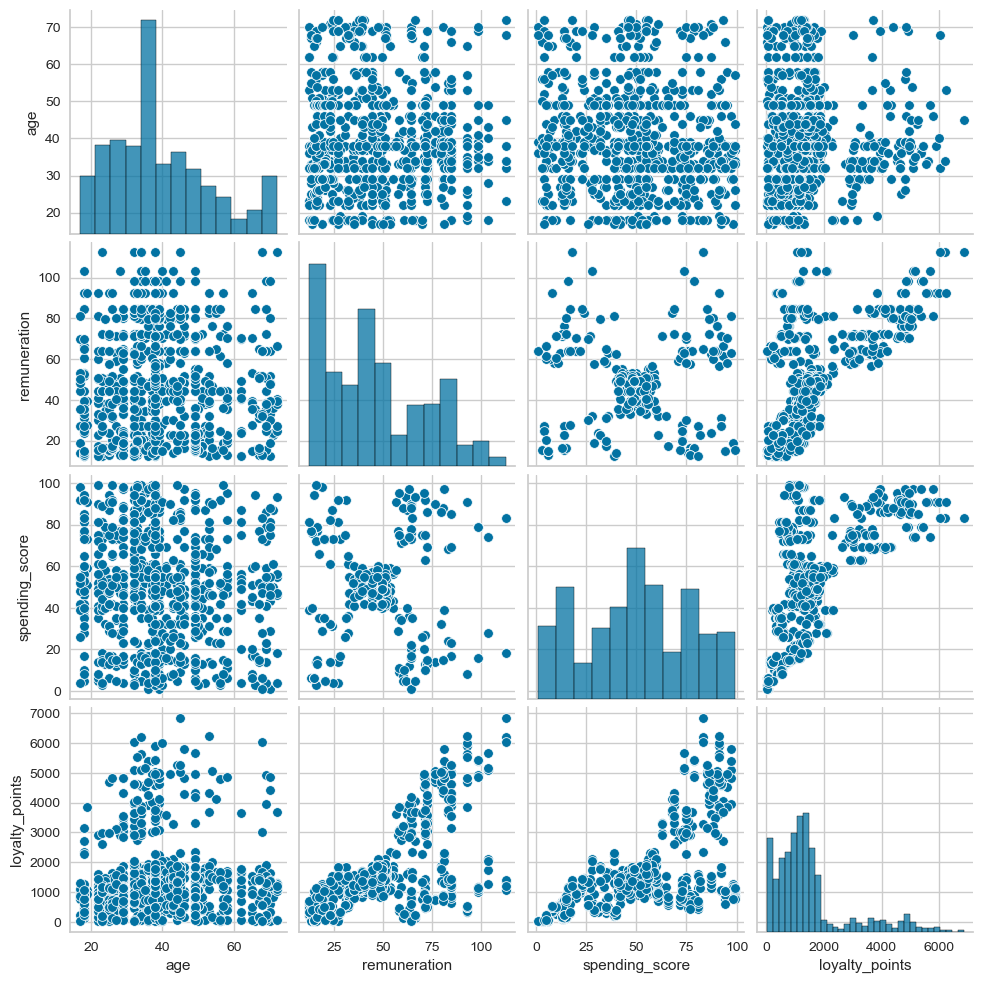

In [108]:
# visualise the distributions & relationships beetween numeric variables   
sns.pairplot(customers)

Visual inspection: relationships beetween variables deviate from linear. - consider transformation.

In [110]:
# calculate descriptive statistics for customers df
customers_desc_stat = desc_stat_summary(customers)
customers_desc_stat

age  remuneration  spending_score  \
count                         782.000000    782.000000      782.000000   
mean                           39.554987     46.058414       49.604859   
std                            13.666746     25.249759       26.593610   
min                            17.000000     12.300000        1.000000   
25%                            29.000000     23.165000       29.000000   
50%                            38.000000     44.280000       50.000000   
75%                            49.000000     63.960000       73.000000   
max                            72.000000    112.340000       99.000000   
range                          55.000000    100.040000       98.000000   
IQR                            20.000000     40.795000       44.000000   
skewness (n=0)                  0.599326      0.559234       -0.027514   
kurtosis (n=3)                  2.778223      2.360189        2.035247   
Shapiro-Wilk, stat (n=1)        0.952627      0.936880        0.965425   
Shapiro-Wilk, p-value (>0.05)   0.000000      0.000000        0.000000   

                               loyalty_points  
count                              782.000000  
mean                              1497.404092  
std                               1313.241715  
min                                 25.000000  
25%                                701.000000  
50%                               1187.000000  
75%                               1658.000000  
max                               6847.000000  
range                             6822.000000  
IQR                                957.000000  
skewness (n=0)                       1.660608  
kurtosis (n=3)                       5.311685  
Shapiro-Wilk, stat (n=1)             0.807552  
Shapiro-Wilk, p-value (>0.05)        0.000000

Central tendency & variablility:

- The loyalty points' scale is vastly different from the features' scales. Models sensitive to input's scales might beneit from feature scaling.
    
Distribution: 
- loyalty_points: strongly right-tailed distribution with a sharper peak compared to a normal distribution (Clear evidence that the distribution is not normal) 
- spending_score: slightly deviates from normality (approximately symmetric, light-tailed)
- remuneration: strong evidence of non-normality (slight right-tailed distribution; has thinner tails and a flatter peak)
- age: strong evidence of non-normality (slight right-tailed distribution; has thinner tails and a flatter peak

- **Regression models might benefit from improving the normality of a distribution via log/square-root transformations.**

**Action:** evaluate potential effect from loyalty points transformation  

In [113]:
# Pearson correlation to evaluate linear relationships
customers.corr(method='pearson', numeric_only=True)

age  remuneration  spending_score  loyalty_points
age             1.000000      0.006024       -0.124630        0.028904
remuneration    0.006024      1.000000       -0.001645        0.630901
spending_score -0.124630     -0.001645        1.000000        0.632116
loyalty_points  0.028904      0.630901        0.632116        1.000000

The Pearson correlation coefficients of 0.63 indicates a moderate positive correlation in the 'remuneration ¬ loyalty points' and 'spending score ¬ loyalty points' pairs

There is little to no correlation the 'age ¬ loyalty points' and 'spending score ¬ remuneration' pairs

This suggests that:
- age is not a meaningfull predictor for loyalty points
- no milticollinearity is expected between spending score & remuneration


In [115]:
# Spearman rank correlation to capture possible non-linear but monotonic relationships (e.g. exponential, logarithmic)
customers.corr(method='spearman', numeric_only=True)

age  remuneration  spending_score  loyalty_points
age             1.000000      0.030325       -0.137092        0.099044
remuneration    0.030325      1.000000        0.005013        0.623298
spending_score -0.137092      0.005013        1.000000        0.634250
loyalty_points  0.099044      0.623298        0.634250        1.000000

Spearman rank correlation coeficients are comparable with Pearson. No evidence of non-linear but monotonic relationships stronger than linear.

Recognising that the 'loyalty_points' variable is right-skewed we test log, square-root and cube-root transformation to achieve a distribution closer to normal.

In [118]:
# apply log, square-root and cube-root transformation to y
customers.loc[:, 'loyalty_points_log'] = customers['loyalty_points'].apply(lambda x: np.log(x))
customers.loc[:, 'loyalty_points_2rt'] = customers['loyalty_points'].apply(lambda x: math.sqrt(x))
customers.loc[:, 'loyalty_points_3rt'] = customers['loyalty_points'].apply(lambda x: math.pow(x, 1/3))

# calculate descriptive statistics for customers df
customers_desc_stat = desc_stat_summary(customers)
customers_desc_stat

age  remuneration  spending_score  \
count                         782.000000    782.000000      782.000000   
mean                           39.554987     46.058414       49.604859   
std                            13.666746     25.249759       26.593610   
min                            17.000000     12.300000        1.000000   
25%                            29.000000     23.165000       29.000000   
50%                            38.000000     44.280000       50.000000   
75%                            49.000000     63.960000       73.000000   
max                            72.000000    112.340000       99.000000   
range                          55.000000    100.040000       98.000000   
IQR                            20.000000     40.795000       44.000000   
skewness (n=0)                  0.599326      0.559234       -0.027514   
kurtosis (n=3)                  2.778223      2.360189        2.035247   
Shapiro-Wilk, stat (n=1)        0.952627      0.936880        0.965425   
Shapiro-Wilk, p-value (>0.05)   0.000000      0.000000        0.000000   

                               loyalty_points  loyalty_points_log  \
count                              782.000000          782.000000   
mean                              1497.404092            6.890578   
std                               1313.241715            1.065053   
min                                 25.000000            3.218876   
25%                                701.000000            6.552508   
50%                               1187.000000            7.079184   
75%                               1658.000000            7.413367   
max                               6847.000000            8.831566   
range                             6822.000000            5.612690   
IQR                                957.000000            0.860859   
skewness (n=0)                       1.660608           -1.076523   
kurtosis (n=3)                       5.311685            4.466800   
Shapiro-Wilk, stat (n=1)             0.807552            0.909886   
Shapiro-Wilk, p-value (>0.05)        0.000000            0.000000   

                               loyalty_points_2rt  loyalty_points_3rt  
count                                  782.000000          782.000000  
mean                                    35.330002           10.514595  
std                                     15.796016            3.244649  
min                                      5.000000            2.924018  
25%                                     26.476405            8.883266  
50%                                     34.452866           10.588072  
75%                                     40.718546           11.835724  
max                                     82.746601           18.988913  
range                                   77.746601           16.064895  
IQR                                     14.242142            2.952458  
skewness (n=0)                           0.596465            0.096343  
kurtosis (n=3)                           3.361124            3.172621  
Shapiro-Wilk, stat (n=1)                 0.947999            0.966366  
Shapiro-Wilk, p-value (>0.05)            0.000000            0.000000

In [119]:
# Pearson correlation to evaluate linear relationships
customers.corr(method='pearson', numeric_only=True)

age  remuneration  spending_score  loyalty_points  \
age                 1.000000      0.006024       -0.124630        0.028904   
remuneration        0.006024      1.000000       -0.001645        0.630901   
spending_score     -0.124630     -0.001645        1.000000        0.632116   
loyalty_points      0.028904      0.630901        0.632116        1.000000   
loyalty_points_log  0.000925      0.560484        0.707846        0.804473   
loyalty_points_2rt  0.023254      0.631490        0.696061        0.963172   
loyalty_points_3rt  0.017886      0.618104        0.709969        0.926228   

                    loyalty_points_log  loyalty_points_2rt  loyalty_points_3rt  
age                           0.000925            0.023254            0.017886  
remuneration                  0.560484            0.631490            0.618104  
spending_score                0.707846            0.696061            0.709969  
loyalty_points                0.804473            0.963172            0.926228  
loyalty_points_log            1.000000            0.930535            0.966382  
loyalty_points_2rt            0.930535            1.000000            0.993217  
loyalty_points_3rt            0.966382            0.993217            1.000000

Both root transformations result in improved correlation coefficients for both remuneration & spending score 
With cube-root transformation, we achieve normality in loyalty points distribution with the best skewness, kurtosis & Shapiro-Wilk metrics

**Note:** The assumption of linearity is not fully met. 

**Decision:** Proceed with cube-root transformation

In [121]:
# drop redundant columns
customers.drop(columns = ['loyalty_points_log', 'loyalty_points_2rt'], inplace=True)

Observation:

loyalty_points_3rt_sc have moderate positive correlation coefficients with remuneration_sc & spending_scoresc, while remuneration & spending score don't correlate with each other.
There is little to no correlation between age and loyalty points

**Decision:** continue with X = remuneration & spemding_score and Y = loyalty points_3rt_sc 

### 2 Create and fit the model

In [124]:
# define variables
y_tr = customers['loyalty_points_3rt'] 
y = customers['loyalty_points'] 
X = customers[['remuneration', 'spending_score']]

Recognising the relatively large dataset size of 782 observations, allocated 0.8 to the train set. The random_state parameter of 42 is used for reproducibility.

In [126]:
#Split the data in 'train' (80%) and 'test' (20%) sets.
X_train, X_test, Y_tr_train, Y_tr_test, Y_obs_train, Y_obs_test = sklearn.model_selection.train_test_split(X, y_tr, y,
                                                                            test_size = 0.20,
                                                                            random_state = 42)

Review the summary statistics (descriptive statistics) of the training and test data sets to exclude potential ‘data shift’

In [128]:
# view the underlying shape of the train and test data sets 
print(Y_tr_train.describe(), Y_tr_test.describe())

count   625.000000
mean     10.481233
std       3.261234
min       2.924018
25%       8.810868
50%      10.558255
75%      11.785542
max      18.988913
Name: loyalty_points_3rt, dtype: float64 count   157.000000
mean     10.647407
std       3.184560
min       3.448217
25%       9.193347
50%      10.723117
75%      11.901979
max      18.191374
Name: loyalty_points_3rt, dtype: float64


Central tendency stats are comparable - no issues 

Used the statsmodels ols method to create and fit linear regression model 

In [131]:
# Create & fit the model
mlr_model = sm.OLS(Y_tr_train, sm.add_constant(X_train)).fit()

In [132]:
#  print summary of metrics
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:     loyalty_points_3rt   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     2564.
Date:                Wed, 22 Jan 2025   Prob (F-statistic):          4.10e-301
Time:                        13:41:20   Log-Likelihood:                -930.15
No. Observations:                 625   AIC:                             1866.
Df Residuals:                     622   BIC:                             1880.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.5310      0.119     21.

Observation: 

- Both features are significant with p< 0.05 and explain 89.2% of the variability in the **transformed** dependent variable
- The independent variables' coefficients have expected signs, but not interpretable for the transformation applied


Decision:

Continue with the model - prepare summary of linear regression assumptions & analyse them, assess accuracy and test how the model generalises on unseen data 

In [134]:
# Predict the training set values
Y_tr_train_pred = mlr_model.predict(sm.add_constant(X_train)) 

# apply backward transformation 
Y_train_pred = Y_tr_train_pred.apply(lambda x: math.pow(x, 3))

In [135]:
# Predict the test set values
Y_tr_test_pred = mlr_model.predict(sm.add_constant(X_test)) 

# apply backward transformation 
Y_test_pred = Y_tr_test_pred.apply(lambda x: math.pow(x, 3))

### 3 Check linear regression assumptions

Accept the significance level (alpha) of 0.05

In [138]:
# view model statistics 
LR_stat_summary = LR_statistics(mlr_model, X_train, 'MLR_all')
LR_stat_summary

MLR_all
Durbin-Watson statistic (1.5-2.5) 1.933877
Resid. vs remuneration corr          -0.00
Resid. vs spending_score corr        -0.00
LM Test p-value (> 0.05)          0.578577
VIF Factor: remuneration (<10)    1.000195
VIF Factor: spending_score (<10)  1.000195
JB Probability (> 0.05)           0.000000
F statistic p-value (< 0.05)      0.000000

F-statistic p-value < 0.05 indicates that the regression model is statistically significant.

LR assumptions are satisfied with two exceptions:

- Linearity (discussed above: correlation, and supported by the "Residuals vs. x-variables plot")
- Normality of error terms (optional); JB probability < 0.05 suggests that the residuals significantly deviate from normality. This is supported by the "Residuals Q-Q plot" below.

#### Residuals vs. X-Variable(s) Plot (linearity assumption)

Residuals vs. X-Variable(s) Plot checks the linearity assumption for each predictor individually. It shows the relationship between residuals and each independent variable (X).


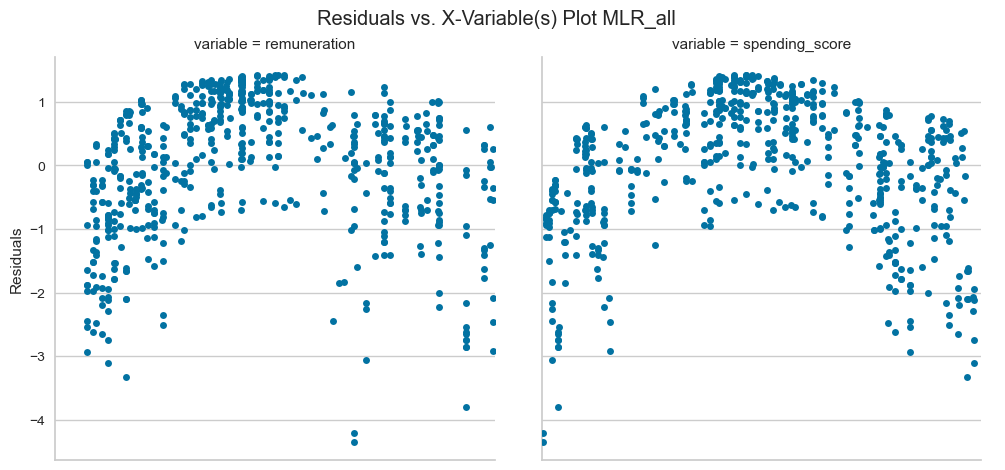

In [142]:
# prepare data for the residuals vs. X visualisation
res_plot = X_train.copy()
res_plot['Residuals'] = mlr_model.resid
res_plot = res_plot.melt(id_vars='Residuals')

# Plot the residuals versus the x-values.
g = sns.catplot(res_plot, y='Residuals', x='value', col='variable')
g.fig.suptitle("Residuals vs. X-Variable(s) Plot MLR_all", y=1.02)

# Remove x-axis labels, tick labels, and tick marks for each subplot
for ax in g.axes.flat:
    ax.set_xlabel("") 
    ax.set_xticks([])
    ax.set_xticklabels([])
plt.show()

Observation: 

- The 'smile' pattern suggests a violation of linearity, meaning the model may be missing non-linear relationships.
- This is expected given Pearson correlation coefficients (x vs. y). 

#### Residuals vs. Fitted Values Plot (linearity, homoscedasticity, autocorrelation)

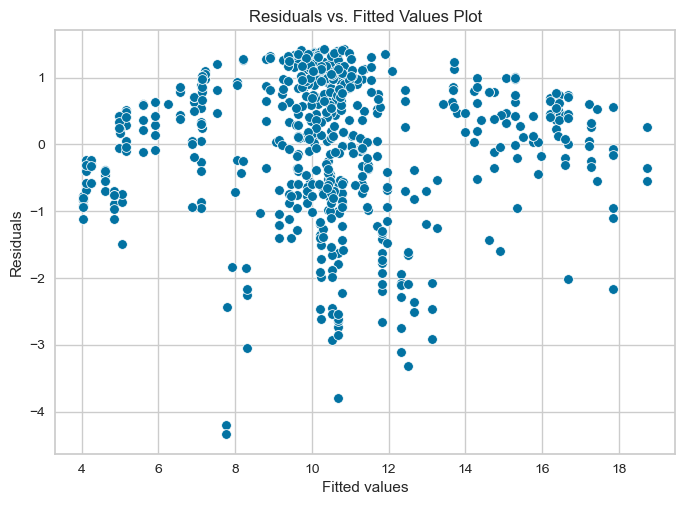

In [145]:
# Plot the residuals versus the predicted values on the train dataset.
sns.scatterplot(y = mlr_model.resid, x= Y_tr_train_pred)
plt.ylabel("Residuals")
plt.xlabel("Fitted values")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

The scatter deviates from perfect 'white noise', but no strong patterns. 

#### Residuals Q-Q plot (Normality of error terms)

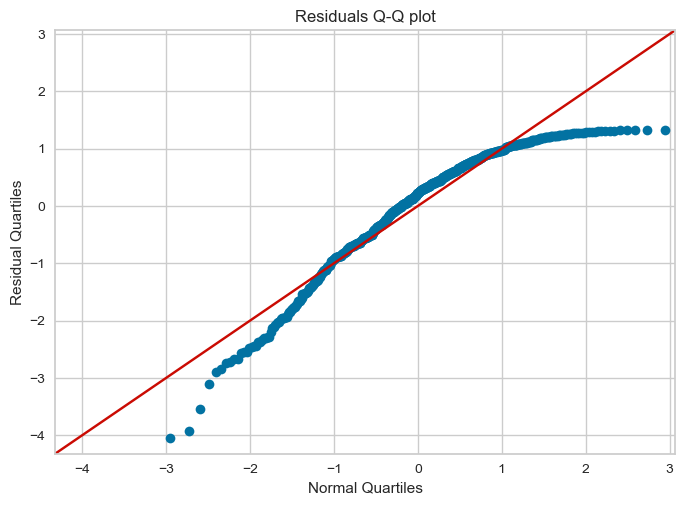

In [148]:
# Plot the quartiles of the residuals versus the quartiles of the N(0,1)
# The fit=True argument first Standardises the observed data (Residuals) before plotting them
sm.qqplot(mlr_model.resid, fit=True, line='45')
plt.ylabel("Residual Quartiles")
plt.xlabel("Normal Quartiles")
plt.title("Residuals Q-Q plot")
plt.show()

Observation: 

The optional assumption of Normality of error terms is violated.

 OLS does not require that the error term follows a normal distribution to produce unbiased estimates with the minimum variance. However, satisfying this assumption allows you to perform statistical hypothesis testing and generate reliable confidence intervals and prediction intervals.

### 4 Assess accuracy & test how the model generalises on unseen data 

Calculate and analyse goodness-of-fit measures:
- On the trainind dataset to evaluate the model's capacity to learn from the data. Helps identify underfitting (e.g., high training error or low R2).
- On the Test Dataset to assess how well the model generalises to unseen data.  Helps identify overfitting (e.g., much better metrics on training data than on test data).


In [152]:
# summarise goodness of fit measures for train dataset 
MLR_gof_summary = goodness_of_fit(Y_obs_train, Y_train_pred,  mlr_model, 'MLR_train')

# add GOF for test dataset 
MLR_gof_summary = MLR_gof_summary.merge(goodness_of_fit(Y_obs_test, Y_test_pred,  mlr_model, 'MLR_test'), left_index=True, right_index=True)

# print the summary
MLR_gof_summary

MLR_train    MLR_test
R2                 0.919348    0.906427
R2 (train)         0.891825    0.891825
Adj. R2 (train)    0.891478    0.891478
RMSE             374.503788  393.538048
MAE              290.968241  318.451350
MAPE, %           25.630431   26.413167
q1 (y_real)      684.000000  777.000000
q3 (y_real)     1637.000000 1686.000000
mean (y_real)   1489.467200 1529.000000

Observation: 

FAIR FOR BOTH TRAIN & TEST

- The R-squared is strong and explains slightly more than 90% of the dependent variable (both on train & test).
- MAE & RMSE are smaller than the mean value of Y with MAPE slightly above 25%
- The difference between RMSE and MAE is moderate/small, which suggests that the model's prediction errors are relatively consistent and that there are few extreme outliers.

The model's performance is noted. To be compared with other models.


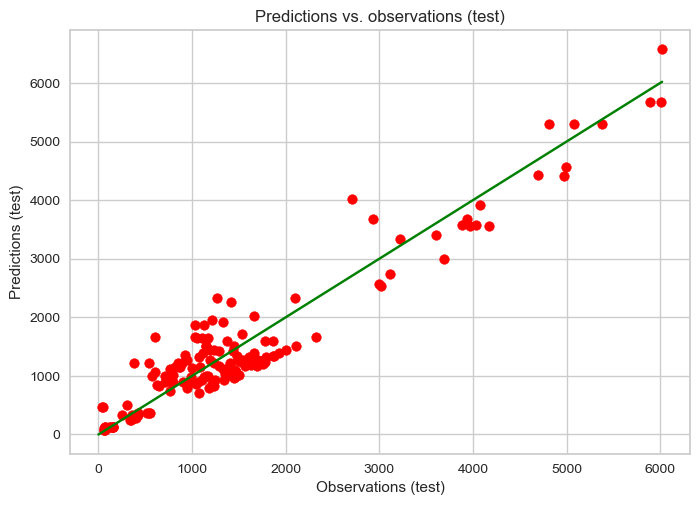

In [154]:
# Plot Predictions (y) vs. observations (x) on the test dataset
X_var = Y_obs_test
Y_var = Y_test_pred

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_var, Y_var, color='red')

# Add a diagonal line
plt.plot([0, X_var.max()], [0, X_var.max()], color='green')

# Labeling the axes
ax.set_xlabel('Observations (test)')
ax.set_ylabel('Predictions (test)')
ax.set_title('Predictions vs. observations (test)')

plt.show()

Supports the observations above

In [156]:
gof_summary = MLR_gof_summary['MLR_test']

### 5 Insights and observations

MLR can be used to predict loyalty points

Remuneration and spending score best explain the variance in loyalty point balances.

The assumption of linearity is violated. Still, Pearson correlation coefficients for remuneration & spending score vs. loyalty points are strong 61.8% and 70.9%, respectively.

The R-squared of 90.6% is strong with MAPE slightly above 25%

The model generalises well on unseen data with no significant variation between train & test errors. 

The model's performance is noted. To be compared with other models.


#  

# Decision Tree regressor 

### 1. Data pre-processing 

We will use the customers df as a starting point of our analysis (no duplicates); explained in the duplicates analysis section Week 1

In [163]:
# Define new variable to store the DataFrame.
customers = customers.drop(columns = ['loyalty_points_3rt'])
df2 = customers.copy()
df2.head()

gender  age  remuneration  spending_score  loyalty_points     education
0  Female   33     32.800000              42             904      Graduate
1  Female   38     84.460000              85            5019      Graduate
2  Female   50     36.080000              50            1338  Postgraduate
3  Female   38     49.200000              40            1376           PhD
4  Female   36     47.560000              60            1951           PhD

In [164]:
# Specify Y.
y = df2['loyalty_points']

# Specify X.
X = df2[df2.columns[df2.columns != 'loyalty_points']]

In [165]:
X.head()

gender  age  remuneration  spending_score     education
0  Female   33     32.800000              42      Graduate
1  Female   38     84.460000              85      Graduate
2  Female   50     36.080000              50  Postgraduate
3  Female   38     49.200000              40           PhD
4  Female   36     47.560000              60           PhD

In [166]:
# Create a list of features to one-hot encode
cat_features = customers.select_dtypes(exclude=['float', 'int']).columns

# Create dummy variables for multiple features 
X = pd.get_dummies(X, prefix = cat_features, columns = cat_features, dtype=int, drop_first = True)

In [167]:
X.head()

age  remuneration  spending_score  gender_Male  education_High-school  \
0   33     32.800000              42            0                      0   
1   38     84.460000              85            0                      0   
2   50     36.080000              50            0                      0   
3   38     49.200000              40            0                      0   
4   36     47.560000              60            0                      0   

   education_PhD  education_Postgraduate  education_Pre-school  
0              0                       0                     0  
1              0                       0                     0  
2              0                       1                     0  
3              1                       0                     0  
4              1                       0                     0

#### Evaluate features

In [169]:
# Create a VIF dataframe.
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

# Calculate VIF for each feature.
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# View the DataFrame.
vif_data.sort_values('VIF',ascending=True)

feature      VIF
7    education_Pre-school 1.070104
4   education_High-school 1.281899
6  education_Postgraduate 1.440967
5           education_PhD 1.548076
3             gender_Male 1.784633
2          spending_score 3.329248
1            remuneration 3.686249
0                     age 5.340723

In [170]:
# Drop the columns with VIF > 10 to avoid multicollinearity problems.
col_to_drop = list(vif_data[vif_data.VIF > 10].feature.values)
X = X.drop(col_to_drop, axis = 1)

All the VIF factors are less than 10. Therefore, there is no correlation between these X's.

### 2. Create train and test data sets.

Data partitioning: used the train_test_split module from sklearn.model_selection to split the data into a training set and a testing set. Recognising the relatively large dataset size of 782 observations, allocated 0.8 to the train set. The random_state parameter of 42 is used for reproducibility

In [174]:
X.shape

(782, 8)

In [175]:
# Split the data into test and train data.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

Review the summary statistics (descriptive statistics) of the training and test data sets to evaluate the accuracy of data points: see whether the underlying shape of the data has changed to check for potential ‘data shift’ (which may influence the inferred outcomes of the model).

In [177]:
# view the underlying shape of the train and test data sets 
print(y_train.describe(), y_test.describe())

count    625.000000
mean    1489.467200
std     1319.764687
min       25.000000
25%      684.000000
50%     1177.000000
75%     1637.000000
max     6847.000000
Name: loyalty_points, dtype: float64 count    157.000000
mean    1529.000000
std     1290.620691
min       41.000000
25%      777.000000
50%     1233.000000
75%     1686.000000
max     6020.000000
Name: loyalty_points, dtype: float64


In [178]:
# view the underlying shape of the train and test data sets 
print(X_train.describe(), X_test.describe())

             age  remuneration  spending_score  gender_Male  \
count 625.000000    625.000000      625.000000   625.000000   
mean   39.395200     45.794048       49.436800     0.441600   
std    13.721905     25.207697       26.533716     0.496975   
min    17.000000     12.300000        1.000000     0.000000   
25%    29.000000     22.960000       29.000000     0.000000   
50%    38.000000     41.000000       50.000000     0.000000   
75%    49.000000     63.960000       73.000000     1.000000   
max    72.000000    112.340000       99.000000     1.000000   

       education_High-school  education_PhD  education_Postgraduate  \
count             625.000000     625.000000              625.000000   
mean                0.091200       0.233600                0.200000   
std                 0.288124       0.423460                0.400320   
min                 0.000000       0.000000                0.000000   
25%                 0.000000       0.000000                0.000000   
50%   

The shapes of the train and test independent variables are roughly comparable in terms of central tendency measures. No values trimming is applied.

### 3. Create Decision tree regressor

#### Fit, prune, and evaluate the model: 'goodness of fit' measures on the train dataset

The random_state parameter of 42 is used for reproducibility

In [183]:
# grow the full tree
# Create your decision tree regressor.
regressor = DecisionTreeRegressor(random_state=42)

# Fit the regressor object to the data set.
regressor.fit(X_train, y_train) 

DecisionTreeRegressor(random_state=42)

Used the Scikit-Learn predict() method to predict the values (y_train_pred) in the test data set based on (X_train).

In [185]:
#Predict the response for train dataset
y_train_pred = regressor.predict(X_train)

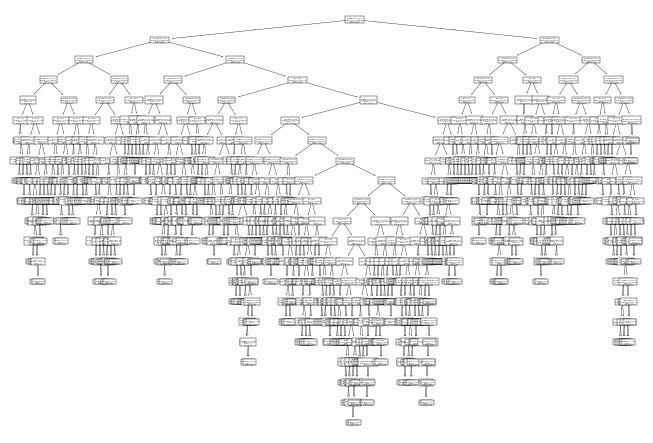

In [186]:
# Plot of full tree
plt.figure()
plot_tree(regressor,feature_names=X_train.columns)
plt.show()

In [187]:
# Print additional information regarding the tree created
print("Depth =",regressor.get_depth())
print("Leaves =",regressor.get_n_leaves())
print("R2: {:2.2%}".format(metrics.r2_score(y_train, y_train_pred)))

Depth = 20
Leaves = 584
R2: 100.00%


In [188]:
# summarise goodness of fit measures for train dataset before prunning
DT_gof_summary = goodness_of_fit(y_train, y_train_pred, regressor, 'DT_full_train')
DT_gof_summary

DT_full_train
R2                   1.000000
R2 (train)               None
Adj. R2 (train)          None
RMSE                 0.000000
MAE                  0.000000
MAPE, %              0.000000
q1 (y_real)        684.000000
q3 (y_real)       1637.000000
mean (y_real)     1489.467200

R2 =100% as expected. If the tree is allowed to grow without constraints (i.e., it is "overfitted"), the tree will memorise the training data. In this case, the predicted values for the training set will exactly match the actual values.

As expected the tree requires pruning 

#### Evaluate the model: 'goodness of fit' measures on the test dataset

Used the Scikit-Learn predict() method to predict the values (y_pred_test) in the test data set based on (X_test).

In [193]:
# Predict the response for the data test.
y_test_pred = regressor.predict(X_test) 

Used the Scikit-Learn library to extract the 'goodness of fit' measures (e.g. R-squared, MAE, RMSE and MAPE) for the test dataset, to assess how well the model generalises to unseen data.

In [195]:
# summarise goodness of fit measures for the test dataset before running
DT_gof_summary = DT_gof_summary.merge(goodness_of_fit(y_test, y_test_pred, regressor, 'DT_full_test'), left_index=True, right_index=True)
DT_gof_summary

DT_full_train DT_full_test
R2                   1.000000     0.987064
R2 (train)               None         None
Adj. R2 (train)          None         None
RMSE                 0.000000   146.320650
MAE                  0.000000    93.668790
MAPE, %              0.000000     7.461270
q1 (y_real)        684.000000   777.000000
q3 (y_real)       1637.000000  1686.000000
mean (y_real)     1489.467200  1529.000000

Observations:

- The R-squared of 99% together with significanttly different metrics on training data vs. test data **INDICATEs OVERFITTING**

#### Prune the model

In [198]:
X.columns, X.shape

(Index(['age', 'remuneration', 'spending_score', 'gender_Male',
        'education_High-school', 'education_PhD', 'education_Postgraduate',
        'education_Pre-school'],
       dtype='object'),
 (782, 8))

In [199]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 9))

max_depth_range

[1, 2, 3, 4, 5, 6, 7, 8]

In [200]:
# List to store the accuracy for each value of max_depth:
accuracy = []

In [201]:
# Fit model on the training dataset, but assess R2 on the test dataset.
for depth in max_depth_range:
    pruning_max_depth = DecisionTreeRegressor(max_depth = depth, random_state = 42)
    pruning_max_depth.fit(X_train,y_train)
    score = pruning_max_depth.score(X_test,y_test)
    accuracy += [score]

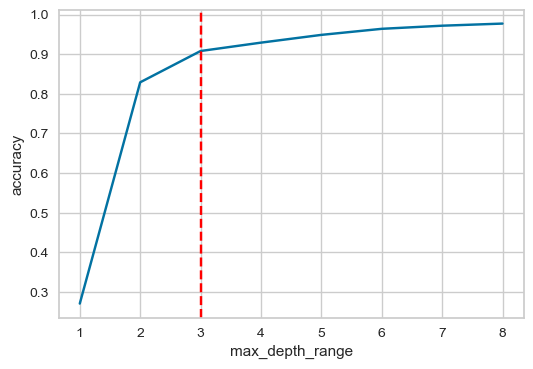

In [202]:
# Plot accuracy values across the range of depth values evaluated
data = {'max_depth_range': max_depth_range,
        'accuracy': accuracy
}

accuracy_df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(accuracy_df, x='max_depth_range', y='accuracy')
plt.axvline(x=3, color='red', linestyle='--', label='optimal max_depth')

Based on the above we continue with a depth value of 3.

In [204]:
# Prune the model.
regressor = DecisionTreeRegressor(max_depth = 3, random_state=42)
regressor.fit(X_train, y_train)  

DecisionTreeRegressor(max_depth=3, random_state=42)

In [205]:
#Predict the response for train dataset
y_train_pred = regressor.predict(X_train)

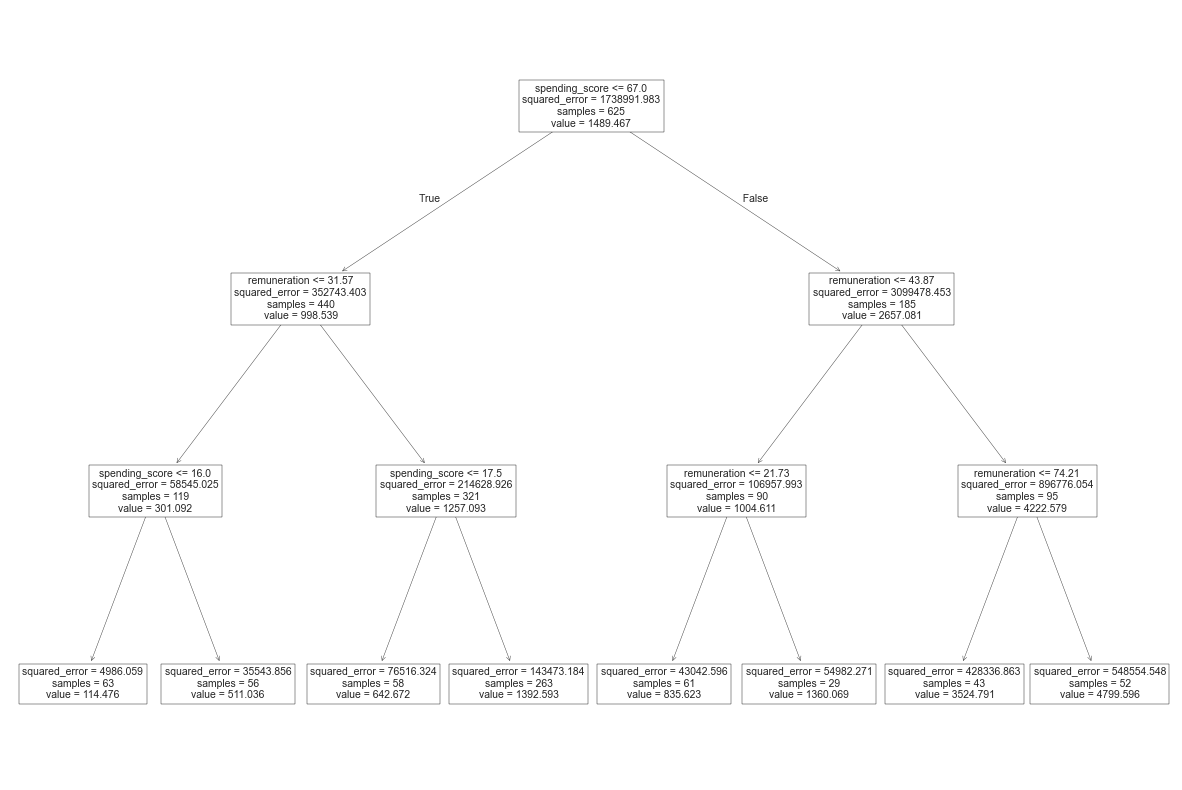

Depth = 3
Leaves = 8
R2: 91.20%


In [206]:
plt.rcParams['figure.figsize'] = [15, 10]

# Plot of full tree
plt.figure()
plot_tree(regressor,feature_names=X_train.columns)
plt.show()

# Print additional information regarding the tree created
print("Depth =",regressor.get_depth())
print("Leaves =",regressor.get_n_leaves())
print("R2: {:2.2%}".format(metrics.r2_score(y_train, y_train_pred)))

In [207]:
# summarise goodness of fit measures for the TRAIN dataset AFTER prunning
DT_gof_summary = DT_gof_summary.merge(goodness_of_fit(y_train, y_train_pred, regressor, 'DT_prunned_train'), left_index=True, right_index=True)
DT_gof_summary

DT_full_train DT_full_test DT_prunned_train
R2                   1.000000     0.987064         0.912005
R2 (train)               None         None             None
Adj. R2 (train)          None         None             None
RMSE                 0.000000   146.320650       391.181549
MAE                  0.000000    93.668790       266.432613
MAPE, %              0.000000     7.461270        24.385323
q1 (y_real)        684.000000   777.000000       684.000000
q3 (y_real)       1637.000000  1686.000000      1637.000000
mean (y_real)     1489.467200  1529.000000      1489.467200

Observations:

- The R-squared is strong and explains 91% of the dependent variable.
- MAE of 266 & RMSE of 391 (big errors in predictions penalise the metric compared to MAE) compared to central tendency measures of 1489
- MAE & RMSE are smaller than the mean value of 1,489 scores.
- The difference between RMSE and MAE is 125. Numbers close to 0 indicate that there are no large errors in the forecast.

#### Evaluate the model: 'goodness of fit' measures on the test dataset

Used the Scikit-Learn predict() method to predict the values (y_pred_test) in the test data set based on (X_test).

In [211]:
# Predict the response for the data test.
y_test_pred = regressor.predict(X_test) 

Used the Scikit-Learn library to extract the 'goodness of fit' measures (e.g. R-squared, MAE, RMSE and MAPE) for the test dataset, to assess how well the model generalises to unseen data.

In [213]:
# summarise goodness of fit measures for the TEST dataset AFTER pruning
DT_gof_summary = DT_gof_summary.merge(goodness_of_fit(y_test, y_test_pred, regressor, 'DT_prunned_test'), left_index=True, right_index=True)
DT_gof_summary

DT_full_train DT_full_test DT_prunned_train DT_prunned_test
R2                   1.000000     0.987064         0.912005        0.908051
R2 (train)               None         None             None            None
Adj. R2 (train)          None         None             None            None
RMSE                 0.000000   146.320650       391.181549      390.108166
MAE                  0.000000    93.668790       266.432613      274.656903
MAPE, %              0.000000     7.461270        24.385323       23.133588
q1 (y_real)        684.000000   777.000000       684.000000      777.000000
q3 (y_real)       1637.000000  1686.000000      1637.000000     1686.000000
mean (y_real)     1489.467200  1529.000000      1489.467200     1529.000000

Observations:

- The R-squared is strong and explains 91% of the dependent variable.
- MAE & RMSE are smaller than the mean value of Y with MAPE c. 23%
- The difference between RMSE and MAE is moderate, which suggests that the model's prediction errors are relatively consistent and that there are few extreme outliers.
- Test metrics are in line with thiose on train, which means that model generalises well to unseen data

### 4. Fit and plot final model.

In [216]:
# Fit and plot the final model.
regressor = DecisionTreeRegressor(max_depth = 3, random_state=42)
regressor.fit(X, y)

DecisionTreeRegressor(max_depth=3, random_state=42)

Used the Scikit-Learn predict() method to predict the values (y_pred_train) in the test data set based on (X_train).

In [218]:
# Predict the response for the data test.
y_pred = regressor.predict(X) 

In [219]:
# summarise goodness of fit measures for the FINAL model on the FULL dataset
DT_gof_summary = DT_gof_summary.merge(goodness_of_fit(y, y_pred, regressor, 'DT_fin'), left_index=True, right_index=True)
DT_gof_summary

DT_full_train DT_full_test DT_prunned_train DT_prunned_test  \
R2                   1.000000     0.987064         0.912005        0.908051   
R2 (train)               None         None             None            None   
Adj. R2 (train)          None         None             None            None   
RMSE                 0.000000   146.320650       391.181549      390.108166   
MAE                  0.000000    93.668790       266.432613      274.656903   
MAPE, %              0.000000     7.461270        24.385323       23.133588   
q1 (y_real)        684.000000   777.000000       684.000000      777.000000   
q3 (y_real)       1637.000000  1686.000000      1637.000000     1686.000000   
mean (y_real)     1489.467200  1529.000000      1489.467200     1529.000000   

                     DT_fin  
R2                 0.889998  
R2 (train)             None  
Adj. R2 (train)        None  
RMSE             435.277473  
MAE              314.917333  
MAPE, %           29.977913  
q1 (y_real)      701.000000  
q3 (y_real)     1658.000000  
mean (y_real)   1497.404092

#### Evaluate the model: 'goodness of fit' measures on the test dataset

Used the Scikit-Learn predict() method to predict the values (y_pred_test) in the test data set based on (X_test).

In [222]:
# Predict the response for the data test.
y_test_pred = regressor.predict(X_test) 

In [223]:
# summarise goodness of fit measures for the FINAL model on the TEST dataset
DT_gof_summary = DT_gof_summary.merge(goodness_of_fit(y_test, y_test_pred, regressor, 'DT_fin_test'), left_index=True, right_index=True)
DT_gof_summary

DT_full_train DT_full_test DT_prunned_train DT_prunned_test  \
R2                   1.000000     0.987064         0.912005        0.908051   
R2 (train)               None         None             None            None   
Adj. R2 (train)          None         None             None            None   
RMSE                 0.000000   146.320650       391.181549      390.108166   
MAE                  0.000000    93.668790       266.432613      274.656903   
MAPE, %              0.000000     7.461270        24.385323       23.133588   
q1 (y_real)        684.000000   777.000000       684.000000      777.000000   
q3 (y_real)       1637.000000  1686.000000      1637.000000     1686.000000   
mean (y_real)     1489.467200  1529.000000      1489.467200     1529.000000   

                     DT_fin DT_fin_test  
R2                 0.889998    0.902689  
R2 (train)             None        None  
Adj. R2 (train)        None        None  
RMSE             435.277473  401.321993  
MAE              314.917333  296.629368  
MAPE, %           29.977913   27.254099  
q1 (y_real)      701.000000  777.000000  
q3 (y_real)     1658.000000 1686.000000  
mean (y_real)   1497.404092 1529.000000

In [224]:
# summary for the report
DT_gof_summary[['DT_prunned_train', 'DT_prunned_test', 'DT_fin', 'DT_fin_test']]

DT_prunned_train DT_prunned_test      DT_fin DT_fin_test
R2                      0.912005        0.908051    0.889998    0.902689
R2 (train)                  None            None        None        None
Adj. R2 (train)             None            None        None        None
RMSE                  391.181549      390.108166  435.277473  401.321993
MAE                   266.432613      274.656903  314.917333  296.629368
MAPE, %                24.385323       23.133588   29.977913   27.254099
q1 (y_real)           684.000000      777.000000  701.000000  777.000000
q3 (y_real)          1637.000000     1686.000000 1658.000000 1686.000000
mean (y_real)        1489.467200     1529.000000 1497.404092 1529.000000

Observations:

- The R-squared is strong and explains 90% of the dependent variable measured on the testing dataset.
- MAE & RMSE are smaller than the mean value of Y with MAPE c. 27%
- The difference between RMSE and MAE is moderate (though bigger than on DT_prunned), which suggests that the model's prediction errors are relatively consistent and that there are few extreme outliers.
- Test metrics are comparable with those on train, which suggests that model generalises well to unseen data

DT fin has slightly larger errors compared to DT_prunned. This might indicate overfitting. Consider applying more advanced techniques like 10-fold cross-validation.  

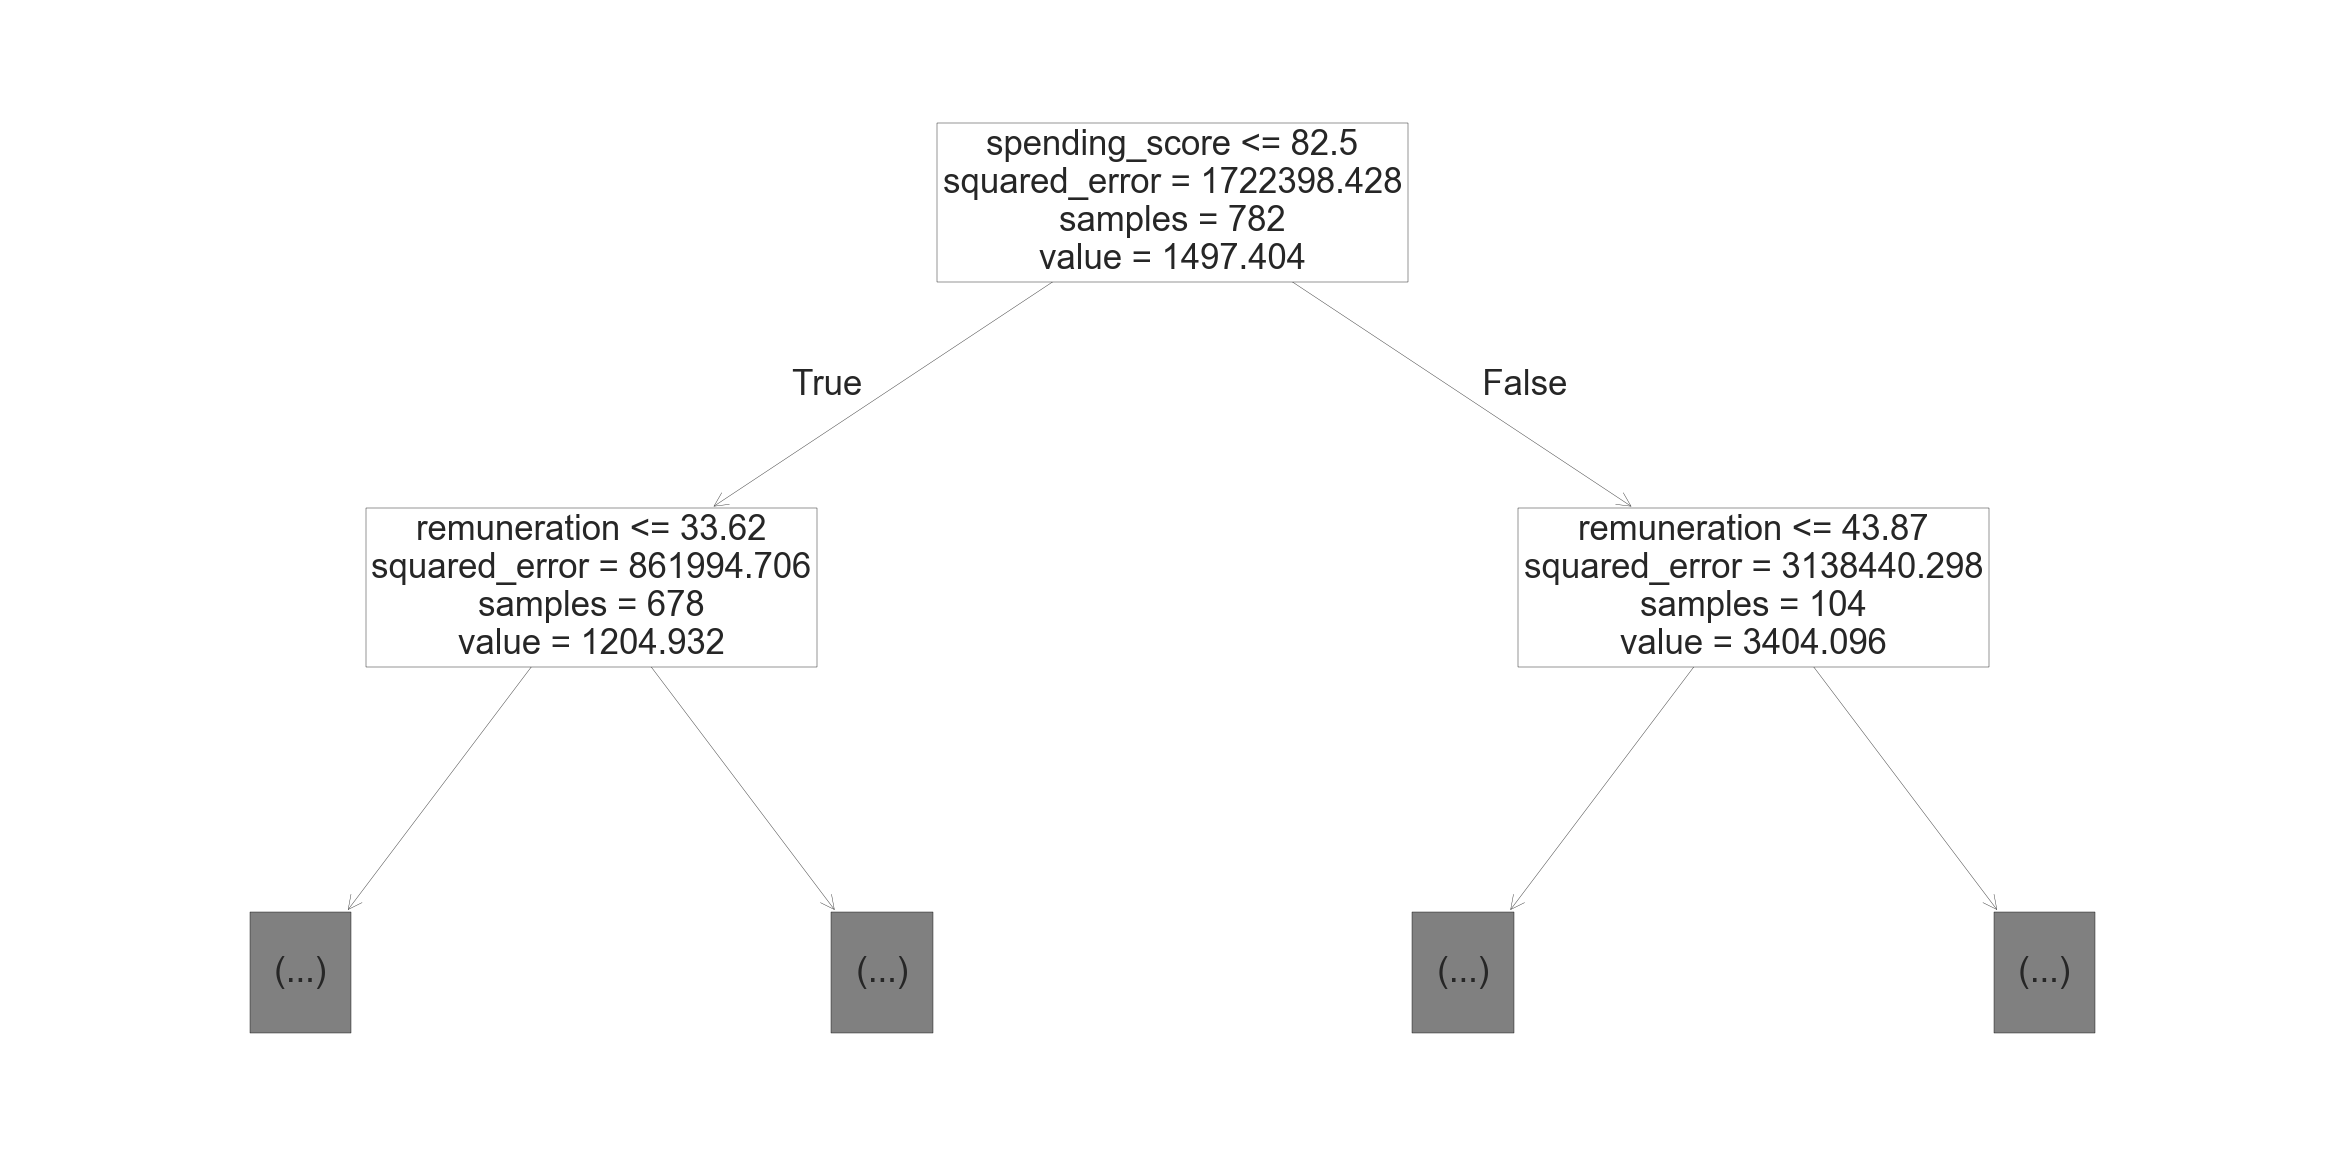

Depth = 3
Leaves = 8
R2: 90.27%


In [226]:
# Plot the decision tree to create the visualisation.
fig, ax = plt.subplots(figsize=(30, 15))
tree.plot_tree(regressor, max_depth=1, feature_names=X.columns, fontsize=25)

# Print the plot with plt.show().
plt.show()  

# Print additional information regarding the tree created
print("Depth =", regressor.get_depth())
print("Leaves =", regressor.get_n_leaves())
print("R2: {:2.2%}".format(metrics.r2_score(y_test, y_test_pred)))

The main features are spending_score and remuneration.

### 5. Insights and observations

DT can be used to predict loyalty points and same as MLR suggests remuneration and spending scores best explain the variance in loyalty point balances.

R2 is strong and comparable to MLR, same as errors. 

We note that decision trees are inherently prone to high variability. Cross-validation techniques can be used to assess how much the model changes across folds and to ensure that variability is minimised.

In [230]:
DT_gof_summary[['DT_prunned_train', 'DT_prunned_test', 'DT_fin', 'DT_fin_test']].merge(gof_summary, left_index=True, right_index=True)

DT_prunned_train DT_prunned_test      DT_fin DT_fin_test  \
R2                      0.912005        0.908051    0.889998    0.902689   
R2 (train)                  None            None        None        None   
Adj. R2 (train)             None            None        None        None   
RMSE                  391.181549      390.108166  435.277473  401.321993   
MAE                   266.432613      274.656903  314.917333  296.629368   
MAPE, %                24.385323       23.133588   29.977913   27.254099   
q1 (y_real)           684.000000      777.000000  701.000000  777.000000   
q3 (y_real)          1637.000000     1686.000000 1658.000000 1686.000000   
mean (y_real)        1489.467200     1529.000000 1497.404092 1529.000000   

                   MLR_test  
R2                 0.906427  
R2 (train)         0.891825  
Adj. R2 (train)    0.891478  
RMSE             393.538048  
MAE              318.451350  
MAPE, %           26.413167  
q1 (y_real)      777.000000  
q3 (y_real)     1686.000000  
mean (y_real)   1529.000000

In [231]:
DT_gof_summary.columns

Index(['DT_full_train', 'DT_full_test', 'DT_prunned_train', 'DT_prunned_test',
       'DT_fin', 'DT_fin_test'],
      dtype='object')

In [232]:
gof_summary = DT_gof_summary[['DT_prunned_test', 'DT_fin_test']].merge(gof_summary, left_index=True, right_index=True)
gof_summary

DT_prunned_test DT_fin_test    MLR_test
R2                     0.908051    0.902689    0.906427
R2 (train)                 None        None    0.891825
Adj. R2 (train)            None        None    0.891478
RMSE                 390.108166  401.321993  393.538048
MAE                  274.656903  296.629368  318.451350
MAPE, %               23.133588   27.254099   26.413167
q1 (y_real)          777.000000  777.000000  777.000000
q3 (y_real)         1686.000000 1686.000000 1686.000000
mean (y_real)       1529.000000 1529.000000 1529.000000

#  

# Clustering with *k*-means

### 1. Explore the data

In [236]:
# Save customers as df3.
df3 = customers.copy()

# View DataFrame.
df3.head()

gender  age  remuneration  spending_score  loyalty_points     education
0  Female   33     32.800000              42             904      Graduate
1  Female   38     84.460000              85            5019      Graduate
2  Female   50     36.080000              50            1338  Postgraduate
3  Female   38     49.200000              40            1376           PhD
4  Female   36     47.560000              60            1951           PhD

In [237]:
df3.columns

Index(['gender', 'age', 'remuneration', 'spending_score', 'loyalty_points',
       'education'],
      dtype='object')

In [238]:
# Drop unnecessary columns and assign a variable to store selected  features
cust_X = df3.drop(columns = ['gender', 'age', 'loyalty_points','education'])

# View DataFrame.
cust_X.head()

remuneration  spending_score
0     32.800000              42
1     84.460000              85
2     36.080000              50
3     49.200000              40
4     47.560000              60

In [239]:
# Explore the data.
cust_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   remuneration    782 non-null    float64
 1   spending_score  782 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 12.3 KB


In [240]:
# Descriptive statistics.
cust_X.describe()

remuneration  spending_score
count    782.000000      782.000000
mean      46.058414       49.604859
std       25.249759       26.593610
min       12.300000        1.000000
25%       23.165000       29.000000
50%       44.280000       50.000000
75%       63.960000       73.000000
max      112.340000       99.000000

The selected feature scales are comparable, therefore no normalisation/standardisation techniques are applied.

### 2. Plot

Used Seaborn .scatterplot() and .pairplot() to plot the remuneration versus spending score to determine any correlations and possible groups (clusters).

<Axes: xlabel='spending_score', ylabel='remuneration'>

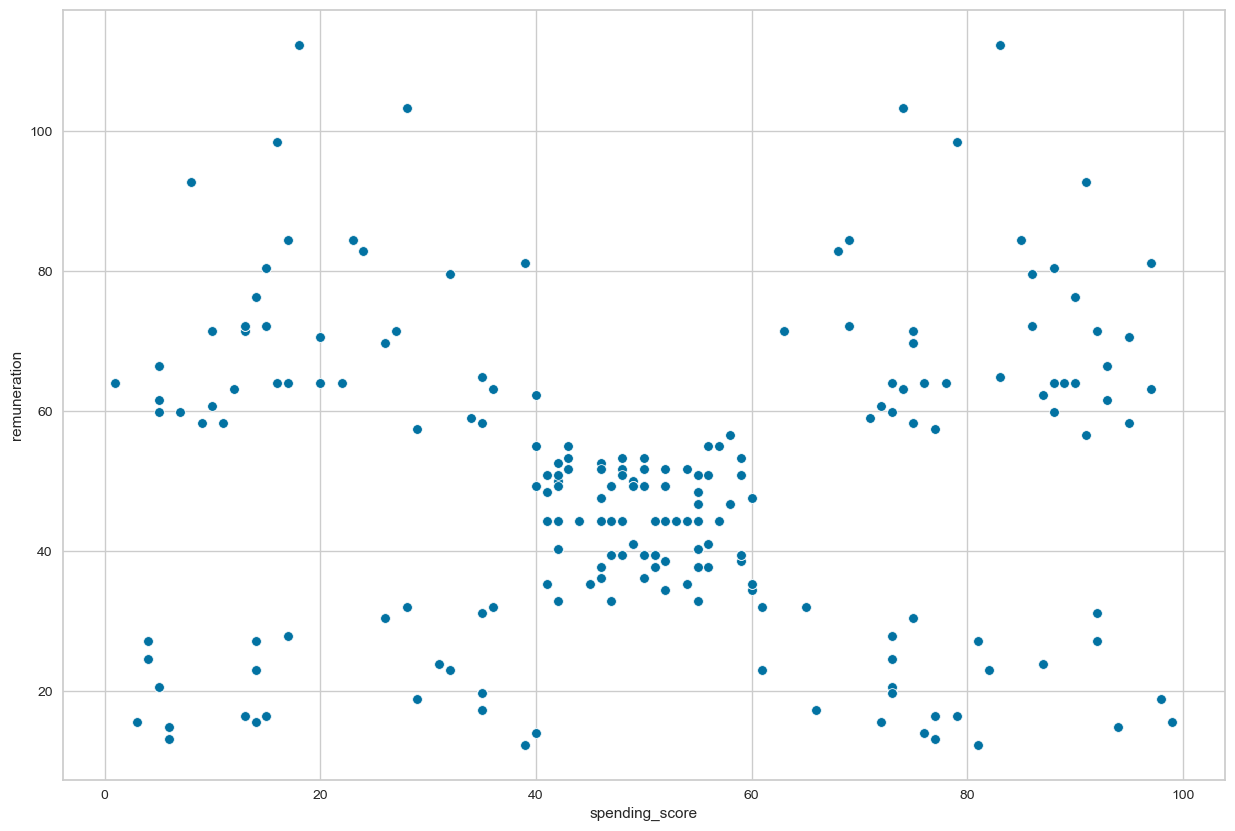

In [244]:
# Create a scatterplot with Seaborn.
sns.scatterplot(x='spending_score',
                y='remuneration',
                data=cust_X)

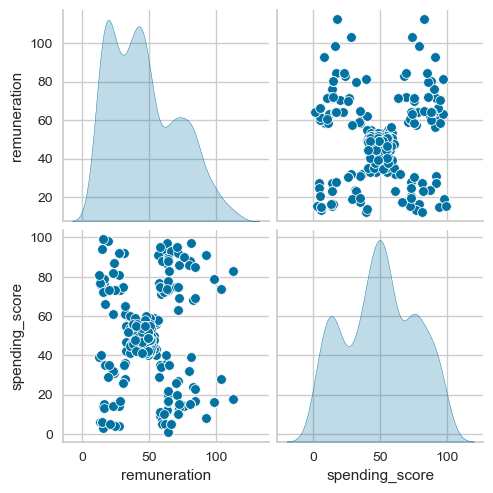

In [245]:
# Create a pairplot with Seaborn.
sns.pairplot(cust_X, diag_kind= 'kde')

Five clusters are identified based on visual analysis.

### 3. Elbow and silhoutte methods

Used the sklearn.clusters to create and fit KMeans object with 5 clusters (based on visual inspection) as a starting point with default settings. Since there are only two dimensions n_init is default (1). random_state=0 for reproducibility.

In [249]:
cust_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   remuneration    782 non-null    float64
 1   spending_score  782 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 12.3 KB


In [250]:
print(cust_X.isnull().sum())

remuneration      0
spending_score    0
dtype: int64


In [251]:
print(cust_X.dtypes)

remuneration      float64
spending_score      int64
dtype: object


In [252]:
print(type(cust_X))

<class 'pandas.core.frame.DataFrame'>


In [253]:
# Create KMeans object with 5 clusters as observed visually as a starting point with default settings
kmeans = KMeans(n_clusters=5, random_state=0)

# Fit the KMeans object to the data set.
kmeans.fit(cust_X)

KMeans(n_clusters=5, random_state=0)


Used the KElbowVisualizer from the yellowbrick library to determine the optimal number of clusters (k-value) utilising the Elbow (metric='distortion') and the Silhouette (metric='silhouette') methods.  
el

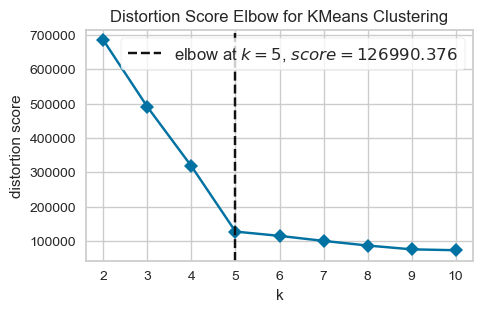

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [255]:
plt.figure(figsize=(5, 3))
# Determine the number of clusters: Elbow method.
visualiser = KElbowVisualizer(kmeans, k=(2,11), metric='distortion', timings=False)
visualiser.fit(cust_X)
visualiser.show()

The elbow is clearly visible. The Elbow method suggests the optimal k-value of 5 (for k > 5 the decrease in WSS is marginal).

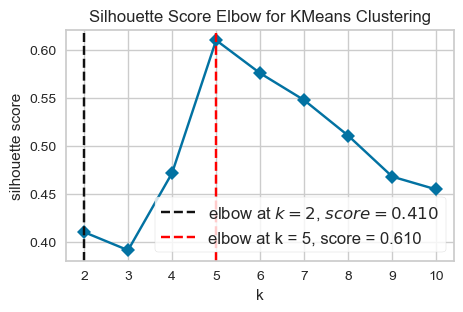

In [257]:
plt.figure(figsize=(5, 3))
# Determine the number of clusters: Silhouette method.
visualiser = KElbowVisualizer(kmeans, k=(2,11), metric='silhouette', timings=False)
visualiser.fit(cust_X)

# plot the optimal k-value
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(cust_X)
Sil = metrics.silhouette_score(cust_X, kmeans.labels_)
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'elbow at k = {optimal_k}, score = {"{:.3f}".format(Sil)}')
plt.legend()

visualiser.show()
plt.show()

The silhouette score technique suggests the optimal k-value of 5 as the cut-off point that maximises the silhouette score.

### 4. Evaluate k-means model at different values of *k*

Evaluate the model for k-value of 5 as the optimal.

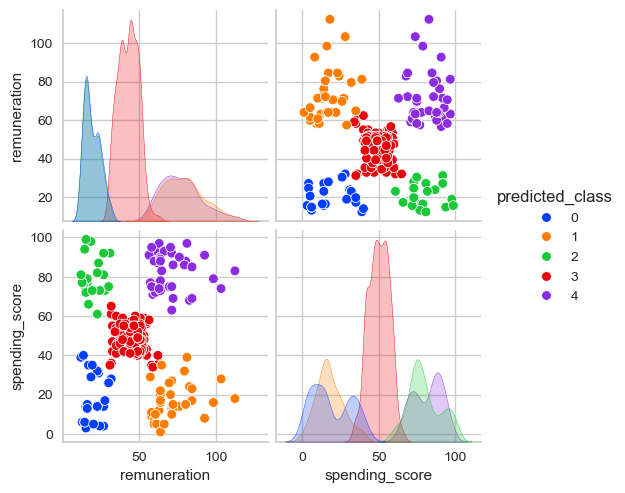

In [261]:
# Use 5 clusters:
kmeans_5 = KMeans(n_clusters = 5, max_iter = 15000, init='k-means++', random_state=0).fit(cust_X)

# Assign a new variable to store features and predictions  
cust_5 = cust_X.copy()
cust_5['predicted_class'] = kmeans_5.labels_

# Plot the predicted.
sns.pairplot(cust_5, hue='predicted_class', diag_kind= 'kde', palette='bright')

In [262]:
cust_5 = cust_5[['predicted_class', 'spending_score']].groupby(by='predicted_class').count()
cust_5

spending_score
predicted_class                
0                           132
1                           119
2                           127
3                           283
4                           121

In [263]:
summary = pd.DataFrame({'k-value=5' : [cust_5['spending_score'].min(), cust_5['spending_score'].mean(), cust_5['spending_score'].max()]}, \
                       index=['min', 'mean', 'max'])
summary

k-value=5
min  119.000000
mean 156.400000
max  283.000000

Observation: The identified clusters meet the expectation. 

Evaluate the model for k-value of 6 to challenge the optimal of 5.

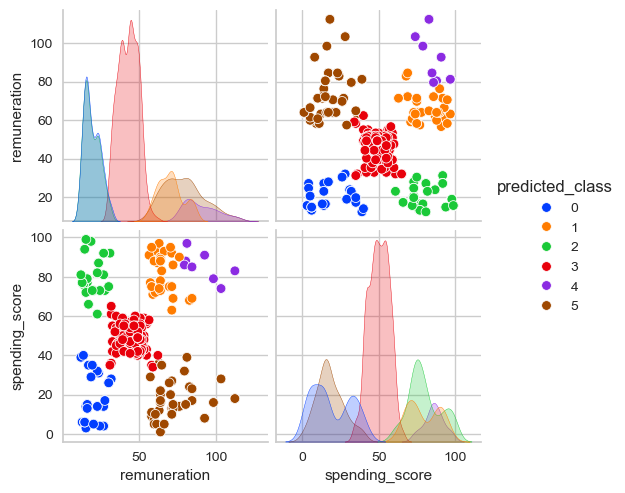

In [266]:
# Use 6 clusters:
kmeans_6 = KMeans(n_clusters = 6, max_iter = 15000, init='k-means++', random_state=0).fit(cust_X)

# Assign a new variable to store features and predictions  
cust_6 = cust_X.copy()
cust_6['predicted_class'] = kmeans_6.labels_

# Plot the predicted.
sns.pairplot(cust_6, hue='predicted_class', diag_kind= 'kde', palette='bright')

In [267]:
cust_6 = cust_6[['predicted_class', 'spending_score']].groupby(by='predicted_class').count()
cust_6

spending_score
predicted_class                
0                           132
1                            78
2                           127
3                           282
4                            43
5                           120

In [268]:
summary['k-value=6'] = [cust_6['spending_score'].min(), cust_6['spending_score'].mean(), cust_6['spending_score'].max()]
summary

k-value=5  k-value=6
min  119.000000  43.000000
mean 156.400000 130.333333
max  283.000000 282.000000

The k-value of 6 does not make sense visually.

Evaluate the model for k-value of 7 to challenge the optimal of 5.

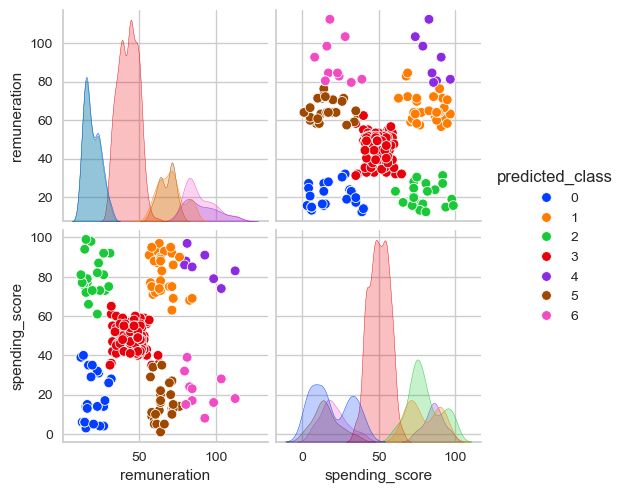

In [271]:
# Use 7 clusters:
kmeans_7 = KMeans(n_clusters = 7, max_iter = 15000, init='k-means++', random_state=0).fit(cust_X)

# Assign a new variable to store features and predictions  
cust_7 = cust_X.copy()
cust_7['predicted_class'] = kmeans_7.labels_

# Plot the predicted.
sns.pairplot(cust_7, hue='predicted_class', diag_kind= 'kde', palette='bright')

In [272]:
cust_7 = cust_7[['predicted_class', 'spending_score']].groupby(by='predicted_class').count()
cust_7

spending_score
predicted_class                
0                           132
1                            78
2                           127
3                           281
4                            43
5                            58
6                            63

In [273]:
summary['k-value=7'] = [cust_7['spending_score'].min(), cust_7['spending_score'].mean(), cust_7['spending_score'].max()]
summary.index.name = 'Observations per cluster'
summary

k-value=5  k-value=6  k-value=7
Observations per cluster                                 
min                      119.000000  43.000000  43.000000
mean                     156.400000 130.333333 111.714286
max                      283.000000 282.000000 281.000000

The k-value of 7 does not make sense visually.

### 5. Fit final model and justify your choice

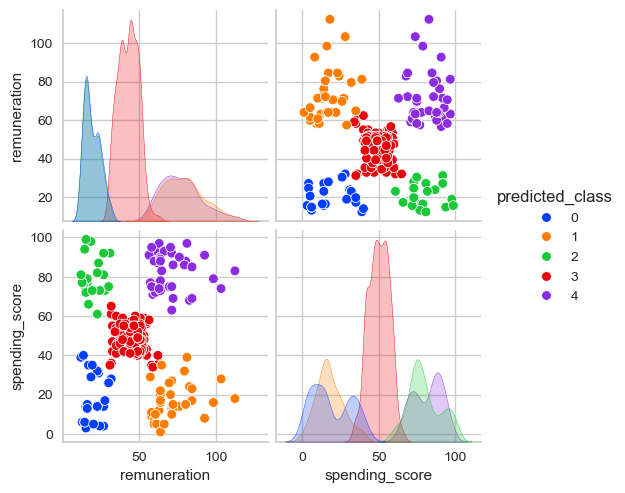

In [276]:
# Apply the final model.
# Use 5 clusters:
kmeans = KMeans(n_clusters = 5, max_iter = 15000, init='k-means++', random_state=0).fit(cust_X)

# Assign a new variable to store features and predictions  
customers_c = cust_X.copy()
customers_c['predicted_class'] = kmeans.labels_

# Plot the predicted.
sns.pairplot(customers_c, hue='predicted_class', diag_kind= 'kde', palette='bright')

In [277]:
# Check the number of observations per predicted class.
customers_c['predicted_class'].value_counts()

predicted_class
3    283
0    132
2    127
4    121
1    119
Name: count, dtype: int64

Rationale: 

- The optimal k-value of 5 is determined by considering the Elbow and Silhouette methods (Appendix 3) which support the initial hypothesis developed based on visual analysis (Appendix 5).
- Evaluation of alternative k of 6 and 7 does not stand to challenge.
- There is no significant variation in between the sizes of the groups. Group count ranges from c.120 to c.280 customers.

### 6. Plot and interpret the clusters

Prepared data for visualisation: scaled numeric features using MinMaxScaler() and transformed the df to long format for ease of visialisation.

In [281]:
# add cluster labels to the initial customers dataframe 
cust_l = df3.copy()
cust_l['predicted_class'] = kmeans.labels_
cust_l['predicted_class'] = cust_l['predicted_class'].astype(str)

# define separate variables to store the lists of numeric and categorical features  
num_features = list(cust_l.select_dtypes(include=['float', 'int']).columns)
cat_features = list(set(cust_l.columns) - set(num_features))

# Scale numeric columns for ease of visualisation 
scaler = MinMaxScaler()
cust_l_scaled = pd.DataFrame(scaler.fit_transform(cust_l[num_features]), columns=cust_l[num_features].columns)
cust_l_scaled = pd.concat([cust_l_scaled, cust_l[cat_features]], axis=1)
# cust_l_scaled.head()

# reshape the df for ease of visualisation 
cust_viz = cust_l_scaled.copy().melt(id_vars=cat_features)
# cust_viz.head()

# define a variable to store the list of the predicted classes (ordered by the mean loyalty points in each class)   
class_order = list(cust_l_scaled[['loyalty_points', 'predicted_class']].groupby(by='predicted_class').mean().sort_values(by='loyalty_points').index)

Visualised the patterns in features by class using sns.catplot (kind='box') to interpret the predicted classes.

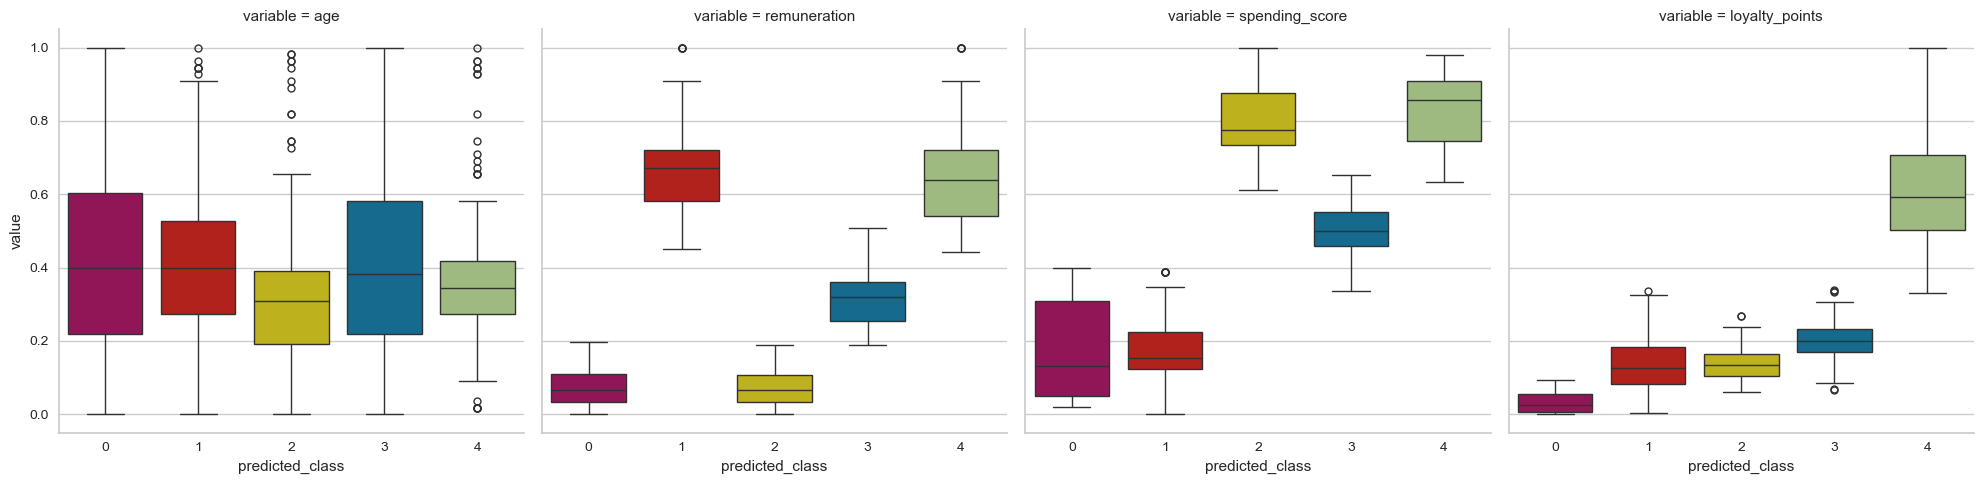

In [283]:
sns.catplot(data=cust_viz, x='predicted_class', order=class_order, y='value', col='variable', kind='box', hue='predicted_class')

Summarised average remuneration, spending score and loyalty points by the predicted class for further analysis. 

In [285]:
# Summarise average remuneration, spending score and loyalty points by the predicted class for further analysis. 
summary_1 = cust_l[['remuneration', 'spending_score', 'loyalty_points','predicted_class']].groupby(by='predicted_class').mean()

summary_1.rename(columns={'loyalty_points': 'avg_loyalty_points', 'spending_score': 'avg_spending_score', 'remuneration': 'avg_remuneration'}, \
                 inplace=True)

summary_1

avg_remuneration  avg_spending_score  avg_loyalty_points
predicted_class                                                          
0                       19.574394           19.037879          246.643939
1                       79.353950           17.815126          947.126050
2                       19.311969           79.889764          980.519685
3                       42.947138           49.893993         1389.890459
4                       77.554380           81.752066         4197.024793

Observation: 

1. Clusters 2 and 4 are associated with high sending scores, cluster 3 - with moderate, and clusters 0 and 1 - with low.
2. Clusters 1 and 4 are associated with high remuneration, cluster 3 - with moderate, and clusters 0 and 2 - with low.
3. The identified clusters are potentially meaningful for predicting loyalty points.



In [287]:
# summarise total loyalty points and customers per cluster 
summary_2 = cust_l[['spending_score', 'loyalty_points','predicted_class']].groupby(by='predicted_class')\
.agg({'loyalty_points':'sum', 'spending_score':'count'})

summary_2.rename(columns={'loyalty_points': 'sum_loyalty_points', 'spending_score': 'count_customers'}, inplace=True)

summary_2

sum_loyalty_points  count_customers
predicted_class                                     
0                             32557              132
1                            112708              119
2                            124526              127
3                            393339              283
4                            507840              121

In [288]:
# combine the two summaries in one 
summary = pd.concat([summary_1, summary_2], axis=1)
summary['revenue_share'] = summary['sum_loyalty_points'] / summary['sum_loyalty_points'].sum() * 100
summary['customers_share'] = summary['count_customers'] / summary['count_customers'].sum() * 100
summary.style.set_table_attributes('style="font-size: 14px;"')

In [289]:
# create a new column to store number of reviews group
customers_full['age_group'] = ''

customers_full.loc[(customers_full['age'] <= 20) & (customers_full['age_group'] == ''), 'age_group'] = '0-20'
customers_full.loc[(customers_full['age'] <= 30) & (customers_full['age_group'] == ''), 'age_group'] = '20-30'
customers_full.loc[(customers_full['age'] <= 40) & (customers_full['age_group'] == ''), 'age_group'] = '30-40'
customers_full.loc[(customers_full['age'] <= 50) & (customers_full['age_group'] == ''), 'age_group'] = '40-50'
customers_full.loc[(customers_full['age'] <= 60) & (customers_full['age_group'] == ''), 'age_group'] = '50-60'
customers_full.loc[(customers_full['age'] <= 70) & (customers_full['age_group'] == ''), 'age_group'] = '60-70'
customers_full.loc[(customers_full['age'] <= 80) & (customers_full['age_group'] == ''), 'age_group'] = '70-80'

In [290]:
# export custoners_full to csv
customers_full.to_csv('customers_full.csv', index=False)

In [291]:
age_order = customers_full['age_group'].sort_values().unique()

In [292]:
customers_full['education'].sort_values().unique()

<StringArray>
['Graduate', 'High-school', 'PhD', 'Postgraduate', 'Pre-school']
Length: 5, dtype: string

In [293]:
edu_order = ['Pre-school', 'High-school', 'Graduate', 'Postgraduate', 'PhD']

In [294]:
# add clusters
customers_full['cluster'] = kmeans.labels_
customers_full['cluster'] = customers_full['cluster'].astype('string')

In [295]:
customers_full[['cluster', 'age_group']].head()

cluster age_group
0       3     30-40
1       4     30-40
2       3     40-50
3       3     30-40
4       3     30-40

In [296]:
# define palette and hue_order
palette = ['#BFBFBF', '#FDAF2A', '#F6E825', '#EF7E50', '#D95769']
hue_order = customers_full.cluster.sort_values().unique()

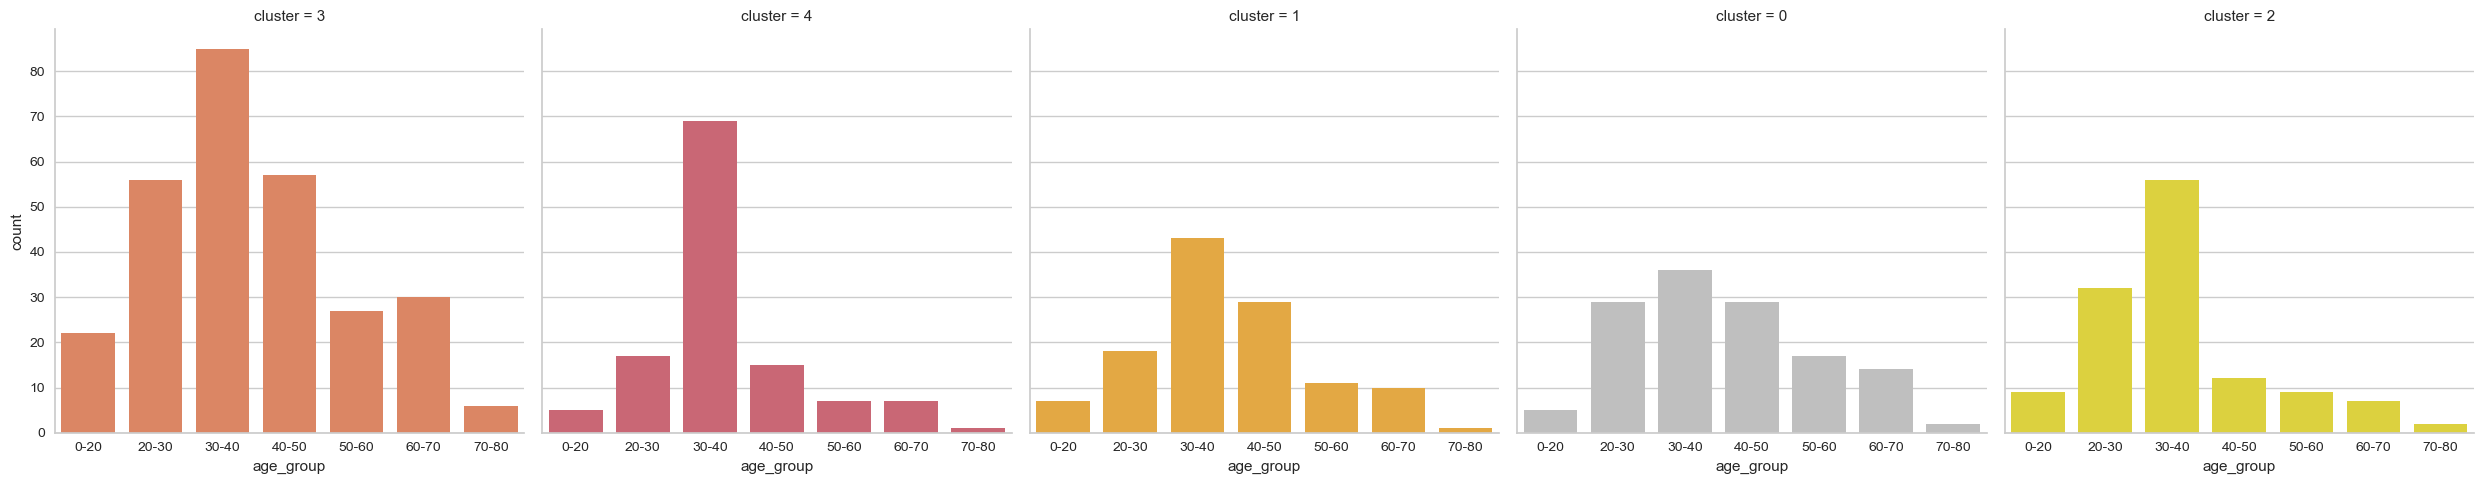

In [297]:
# customer's age structure by cluster
sns.catplot(data=customers_full, x='age_group', order=age_order, col='cluster', legend=False,\
                hue='cluster', hue_order=hue_order, palette=palette, kind='count')

plt.savefig(f"Age_gr_by_segment.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution

### 7. Prepare visualisation for report

In [299]:
# prepare data for visualisation 
# create spending_score_cat and remuneration_cat and populate with categories [1, 2, 3] - > [low, medium, high]

summary['remuneration_cat'] = summary.avg_remuneration.apply(lambda x: round(x / 10))
summary['spending_score_cat'] = summary.avg_spending_score.apply(lambda x: round(x / 10))

ren = summary.sort_values(by='remuneration_cat').remuneration_cat.unique()
ren_dummy = list(range(1, len(ren) + 1))
ren, ren_dummy
my_dict = dict(zip(ren, ren_dummy))
summary['remuneration_cat'] = summary['remuneration_cat'].replace(my_dict)

ren = summary.sort_values(by='spending_score_cat').spending_score_cat.unique()
ren_dummy = list(range(1, len(ren) + 1))
ren, ren_dummy
my_dict = dict(zip(ren, ren_dummy))
summary['spending_score_cat'] = summary['spending_score_cat'].replace(my_dict)

summary.reset_index(inplace=True)

In [300]:
summary.columns

Index(['predicted_class', 'avg_remuneration', 'avg_spending_score',
       'avg_loyalty_points', 'sum_loyalty_points', 'count_customers',
       'revenue_share', 'customers_share', 'remuneration_cat',
       'spending_score_cat'],
      dtype='object')

In [301]:
summary

predicted_class  avg_remuneration  avg_spending_score  avg_loyalty_points  \
0               0         19.574394           19.037879          246.643939   
1               1         79.353950           17.815126          947.126050   
2               2         19.311969           79.889764          980.519685   
3               3         42.947138           49.893993         1389.890459   
4               4         77.554380           81.752066         4197.024793   

   sum_loyalty_points  count_customers  revenue_share  customers_share  \
0               32557              132       2.780345        16.879795   
1              112708              119       9.625183        15.217391   
2              124526              127      10.634431        16.240409   
3              393339              283      33.590869        36.189258   
4              507840              121      43.369173        15.473146   

   remuneration_cat  spending_score_cat  
0                 1                   1  
1                 3                   1  
2                 1                   3  
3                 2                   2  
4                 3                   3

In [302]:
summary.predicted_class.values

array(['0', '1', '2', '3', '4'], dtype=object)

In [303]:
palette = ['#C69255', '#A291E1', '#98A255', '#5EA5C5', '#E274CF']

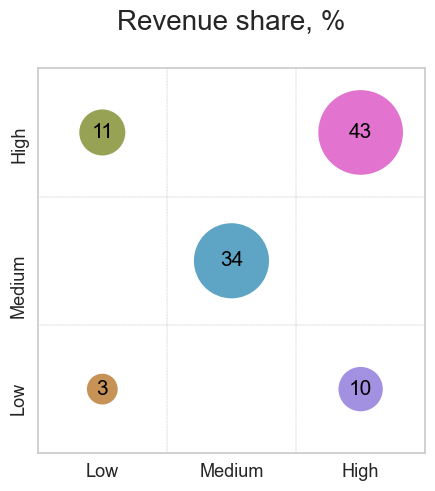

In [304]:
# Visualise revenue share by cluster 
# Plot the 5 observation points (share per cluster) on a scatterplot; point size is reflective of %  

param = 'revenue_share'

fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(data=summary, x='remuneration_cat', y='spending_score_cat', size=param, sizes=(600, 4000), legend=False,\
                hue='predicted_class',  hue_order=summary.predicted_class.values, palette=palette)

# Add labels to each point displaying 'avg_loyalty_points'
for i in range(len(summary)):
    label_color = 'white' if summary[param][i] >= 5000 else 'black'
    plt.text(
        summary['remuneration_cat'][i],         # x position of the label
        summary['spending_score_cat'][i],       # y position of the label
        f'{"{:.0f}".format(summary[param][i])}',  # Label text: avg_loyalty_points value
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=15,
        color=label_color
    )

# Set the x and y axis limits to range from 0 to 4
plt.xlim(0.5, 3.5)
plt.ylim(0.5, 3.5)

# Set the x and y ticks to be [1, 2, 3]
plt.xticks([1, 2, 3])
plt.yticks([1, 2, 3])

# Rename x and y tick marks
plt.xticks([1, 2, 3], ['Low', 'Medium', 'High'], fontsize=13)  # Custom x-axis tick marks
plt.yticks([1, 2, 3], ['Low', 'Medium', 'High'], rotation=90, fontsize=13)  # Custom y-axis tick marks

# Remove gridlines
plt.grid(False)

# Add vertical and horizontal lines
plt.axvline(x=1.5, color='grey', linestyle='--', linewidth=0.2)  
plt.axvline(x=2.5, color='grey', linestyle='--', linewidth=0.2)  
plt.axhline(y=1.5, color='grey', linestyle='--', linewidth=0.2)  
plt.axhline(y=2.5, color='grey', linestyle='--', linewidth=0.2)  


# Rename x and y axes add chart title
plt.xlabel('', fontsize=15)  # x-axis label
plt.ylabel('', fontsize=15)  # y-axis label
plt.title('Revenue share, %\n', fontsize=20)

plt.savefig(f"{param}.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution


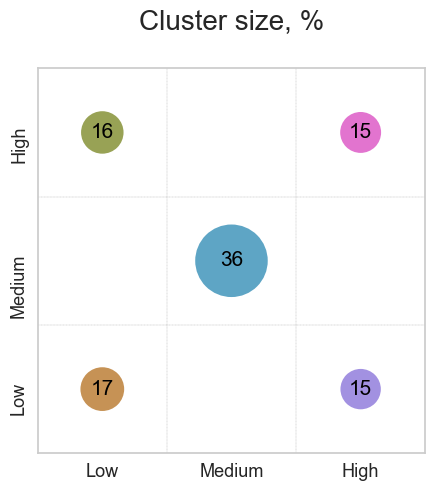

In [305]:
# Visualise the share of customers in each cluster as a % of total customers in the sample  
# Plot the 5 observation points ( of customers in each cluster ) on a scatterplot; point size is reflective of the variable

param = 'customers_share'

fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(data=summary, x='remuneration_cat', y='spending_score_cat', size=param, sizes=(1000, 3000), legend=False,\
                hue='predicted_class',  hue_order=summary.predicted_class.values, palette=palette)

# Add labels to each point displaying 'avg_loyalty_points'
for i in range(len(summary)):
    label_color = 'white' if summary[param][i] >= 5000 else 'black'
    plt.text(
        summary['remuneration_cat'][i],         # x position of the label
        summary['spending_score_cat'][i],       # y position of the label
        f'{"{:.0f}".format(summary[param][i])}',  # Label text: avg_loyalty_points value
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=15,
        color=label_color
    )

# Set the x and y axis limits to range from 0 to 4
plt.xlim(0.5, 3.5)
plt.ylim(0.5, 3.5)

# Set the x and y ticks to be [1, 2, 3]
plt.xticks([1, 2, 3])
plt.yticks([1, 2, 3])

# Rename x and y tick marks
plt.xticks([1, 2, 3], ['Low', 'Medium', 'High'], fontsize=13)  # Custom x-axis tick marks
plt.yticks([1, 2, 3], ['Low', 'Medium', 'High'], rotation=90, fontsize=13)  # Custom y-axis tick marks

# Remove gridlines
plt.grid(False)

# Add vertical and horizontal lines
plt.axvline(x=1.5, color='grey', linestyle='--', linewidth=0.2)  
plt.axvline(x=2.5, color='grey', linestyle='--', linewidth=0.2)  
plt.axhline(y=1.5, color='grey', linestyle='--', linewidth=0.2)  
plt.axhline(y=2.5, color='grey', linestyle='--', linewidth=0.2)  


# Rename x and y axes add chart title
plt.xlabel('', fontsize=15)  # x-axis label
plt.ylabel('', fontsize=15)  # y-axis label
plt.title('Cluster size, %\n', fontsize=20)

plt.savefig(f"{param}.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution


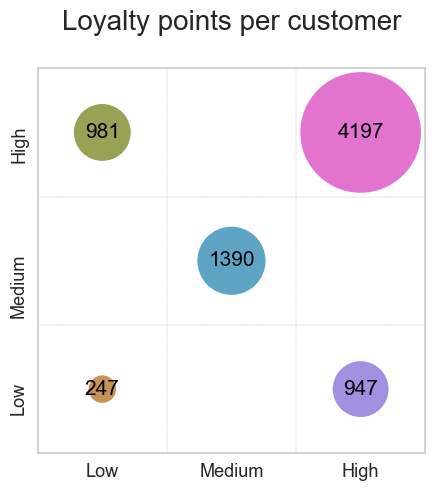

In [306]:
# Visualise average loyalty points per customer by cluster 
# Plot the 5 observation points (average loyalty points per customer by cluster) on a scatterplot; point size is reflective of the variable
fig, ax = plt.subplots(figsize=(5, 5))
param = 'avg_loyalty_points'

sns.scatterplot(data=summary, x='remuneration_cat', y='spending_score_cat', size=param, sizes=(500, 8000), legend=False,\
                hue='predicted_class',  hue_order=summary.predicted_class.values, palette=palette)

# Add labels to each point displaying 'avg_loyalty_points'
for i in range(len(summary)):
    label_color = 'white' if summary[param][i] >= 5000 else 'black'
    plt.text(
        summary['remuneration_cat'][i],         # x position of the label
        summary['spending_score_cat'][i],       # y position of the label
        f'{"{:.0f}".format(summary[param][i])}',  # Label text: avg_loyalty_points value
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=15,
        color=label_color
    )

# Set the x and y axis limits amd tick positions and names
plt.xlim(0.5, 3.5)
plt.ylim(0.5, 3.5)
plt.xticks([1, 2, 3])
plt.yticks([1, 2, 3])
plt.xticks([1, 2, 3], ['Low', 'Medium', 'High'], fontsize=13)  # Custom x-axis tick marks
plt.yticks([1, 2, 3], ['Low', 'Medium', 'High'], rotation=90, fontsize=13)  # Custom y-axis tick marks

# Remove gridlines
plt.grid(False)


# Add vertical and horizontal lines
plt.axvline(x=1.5, color='grey', linestyle='--', linewidth=0.2)  
plt.axvline(x=2.5, color='grey', linestyle='--', linewidth=0.2)  
plt.axhline(y=1.5, color='grey', linestyle='--', linewidth=0.2)  
plt.axhline(y=2.5, color='grey', linestyle='--', linewidth=0.2)  

# Rename x and y axes add chart title
plt.xlabel('', fontsize=15)  # x-axis label
plt.ylabel('', fontsize=15)  # y-axis label
plt.title('Loyalty points per customer\n', fontsize=20)

plt.savefig(f"{param}.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution


In [307]:
# view the summary
summary[['predicted_class', 'avg_remuneration', 'avg_spending_score', 'avg_loyalty_points', 'count_customers', \
         'remuneration_cat', 'spending_score_cat']].style.set_table_attributes('style="font-size: 14px;"')

Enrich customer_full dataset with derived features and additional groupings for further analysis 

In [309]:
# add remuneration cat and spending score cat to customers_full
customers_full = customers_full.merge(summary[['predicted_class', 'remuneration_cat', 'spending_score_cat']], \
                                      how='outer', left_on='cluster', right_on='predicted_class') 

# create a new column to store remuneration group 
customers_full['remuneration_gr'] = ''

customers_full.loc[(customers_full['remuneration'] <= 20) & (customers_full['remuneration_gr'] == ''), 'remuneration_gr'] = '0-20'
customers_full.loc[(customers_full['remuneration'] <= 30) & (customers_full['remuneration_gr'] == ''), 'remuneration_gr'] = '20-30'
customers_full.loc[(customers_full['remuneration'] <= 40) & (customers_full['remuneration_gr'] == ''), 'remuneration_gr'] = '30-40'
customers_full.loc[(customers_full['remuneration'] <= 50) & (customers_full['remuneration_gr'] == ''), 'remuneration_gr'] = '40-50'
customers_full.loc[(customers_full['remuneration'] <= 60) & (customers_full['remuneration_gr'] == ''), 'remuneration_gr'] = '50-60'
customers_full.loc[(customers_full['remuneration'] <= 70) & (customers_full['remuneration_gr'] == ''), 'remuneration_gr'] = '60-70'
customers_full.loc[(customers_full['remuneration'] <= 80) & (customers_full['remuneration_gr'] == ''), 'remuneration_gr'] = '70-80'
customers_full.loc[(customers_full['remuneration_gr'] == ''), 'remuneration_gr'] = '80+'

# Display the updated DataFrame
customers_full.head(5)

customer_ID  gender  age  remuneration  spending_score  loyalty_points  \
0          25  Female   37     14.760000               6              61   
1          29  Female   37     17.220000              35             417   
2          42  Female   33     13.940000              40             366   
3          43  Female   53     22.960000              14             238   
4          71    Male   37     19.680000              35             476   

      education age_group cluster predicted_class  remuneration_cat  \
0   High-school     30-40       0               0                 1   
1      Graduate     30-40       0               0                 1   
2      Graduate     30-40       0               0                 1   
3      Graduate     50-60       0               0                 1   
4  Postgraduate     30-40       0               0                 1   

   spending_score_cat remuneration_gr  
0                   1            0-20  
1                   1            0-20  
2                   1            0-20  
3                   1           20-30  
4                   1            0-20

In [310]:
customers_full

customer_ID  gender  age  remuneration  spending_score  loyalty_points  \
0            25  Female   37     14.760000               6              61   
1            29  Female   37     17.220000              35             417   
2            42  Female   33     13.940000              40             366   
3            43  Female   53     22.960000              14             238   
4            71    Male   37     19.680000              35             476   
..          ...     ...  ...           ...             ...             ...   
777         740  Female   42     76.260000              90            4961   
778         745  Female   45     79.540000              86            5023   
779         748  Female   45     84.460000              85            5272   
780         749  Female   45    112.340000              83            6847   
781         771  Female   43     71.340000              63            3269   

        education age_group cluster predicted_class  remuneration_cat  \
0     High-school     30-40       0               0                 1   
1        Graduate     30-40       0               0                 1   
2        Graduate     30-40       0               0                 1   
3        Graduate     50-60       0               0                 1   
4    Postgraduate     30-40       0               0                 1   
..            ...       ...     ...             ...               ...   
777           PhD     40-50       4               4                 3   
778           PhD     40-50       4               4                 3   
779  Postgraduate     40-50       4               4                 3   
780   High-school     40-50       4               4                 3   
781      Graduate     40-50       4               4                 3   

     spending_score_cat remuneration_gr  
0                     1            0-20  
1                     1            0-20  
2                     1            0-20  
3                     1           20-30  
4                     1            0-20  
..                  ...             ...  
777                   3           70-80  
778                   3           70-80  
779                   3             80+  
780                   3             80+  
781                   3           70-80  

[782 rows x 13 columns]

In [311]:
customers_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_ID         782 non-null    string 
 1   gender              782 non-null    string 
 2   age                 782 non-null    int64  
 3   remuneration        782 non-null    float64
 4   spending_score      782 non-null    int64  
 5   loyalty_points      782 non-null    int64  
 6   education           782 non-null    string 
 7   age_group           782 non-null    object 
 8   cluster             782 non-null    object 
 9   predicted_class     782 non-null    object 
 10  remuneration_cat    782 non-null    int64  
 11  spending_score_cat  782 non-null    int64  
 12  remuneration_gr     782 non-null    object 
dtypes: float64(1), int64(5), object(4), string(3)
memory usage: 79.6+ KB


In [312]:
customers_full['remuneration_cat'] = customers_full['remuneration_cat'].astype('string')
customers_full['spending_score_cat'] = customers_full['spending_score_cat'].astype('string')
customers_full['age_group'] = customers_full['age_group'].astype('string')
customers_full['cluster'] = customers_full['cluster'].astype('string')
customers_full['predicted_class'] = customers_full['predicted_class'].astype('string')
customers_full['remuneration_gr'] = customers_full['remuneration_gr'].astype('string')

In [313]:
customers_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_ID         782 non-null    string 
 1   gender              782 non-null    string 
 2   age                 782 non-null    int64  
 3   remuneration        782 non-null    float64
 4   spending_score      782 non-null    int64  
 5   loyalty_points      782 non-null    int64  
 6   education           782 non-null    string 
 7   age_group           782 non-null    string 
 8   cluster             782 non-null    string 
 9   predicted_class     782 non-null    string 
 10  remuneration_cat    782 non-null    string 
 11  spending_score_cat  782 non-null    string 
 12  remuneration_gr     782 non-null    string 
dtypes: float64(1), int64(3), string(9)
memory usage: 79.6 KB


In [314]:
customers.columns

Index(['gender', 'age', 'remuneration', 'spending_score', 'loyalty_points',
       'education'],
      dtype='object')

In [315]:
customers_full.columns

Index(['customer_ID', 'gender', 'age', 'remuneration', 'spending_score',
       'loyalty_points', 'education', 'age_group', 'cluster',
       'predicted_class', 'remuneration_cat', 'spending_score_cat',
       'remuneration_gr'],
      dtype='object')

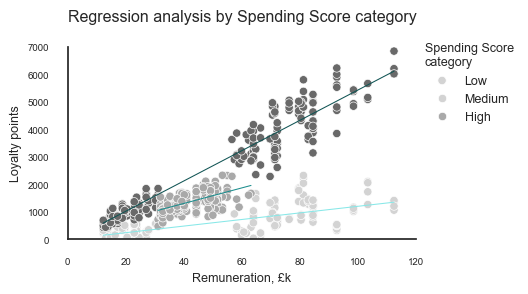

In [316]:
# set theme
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.bottom":True}
sns.set_theme(style="white", rc=custom_params)

fig, ax = plt.subplots(figsize=(4.5, 2.5))

sns.scatterplot(data=customers_full, x='remuneration', y='loyalty_points',\
                hue='spending_score_cat', hue_order = ['1', '2', '3'], palette = ['#D3D3D3', '#A9A9A9', '#696969'])

sns.regplot(data=customers_full[customers_full['spending_score_cat'] == '1'], x='remuneration', y='loyalty_points', order = 1, \
            ci = None, scatter=False, color='#88E8E8', line_kws={'linewidth': 0.75})
sns.regplot(data=customers_full[customers_full['spending_score_cat'] == '2'], x='remuneration', y='loyalty_points', order = 1, \
            ci = None, scatter=False, color='#1B8D8D', line_kws={'linewidth': 0.75})
sns.regplot(data=customers_full[customers_full['spending_score_cat'] == '3'], x='remuneration', y='loyalty_points', order = 1, \
            ci = None, scatter=False, color='#105454', line_kws={'linewidth': 0.75})

ax.set_xlim(0, 120)
ax.set_ylim(0, 7000)
ax.tick_params(axis='x', labelsize = 7) 
ax.tick_params(axis='y', labelsize = 7) 

plt.axhline(y=0, color='black', linewidth=0.7) 

# Rename x and y axes add chart title
plt.xlabel('Remuneration, £k', fontsize=9)  # x-axis label
plt.ylabel('Loyalty points', fontsize=9)  # y-axis label
plt.title('Regression analysis by Spending Score category\n', fontsize=11.5)

# Move legend outside the plot
#plt.legend(title='Spending Score Category', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=9)
plt.legend(title='Spending Score\ncategory', 
           title_fontsize=9,
           bbox_to_anchor=(1.01, 1.05), 
           loc='upper left', 
           borderaxespad=0, 
           fontsize=9,
          labels=['Low', 'Medium', 'High'])


plt.savefig(f"loyalty_summary.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution


**Decision:**

**Evaluate linear regression models for each spending_score_cat**


 There are no strong patterns in income allocation by age groups (analysis in R) but customers are not evenly disctibuted by age groups. 

 Visualise this relationship

In [319]:
customers_full['cluster'] = customers_full['cluster'].astype('str')

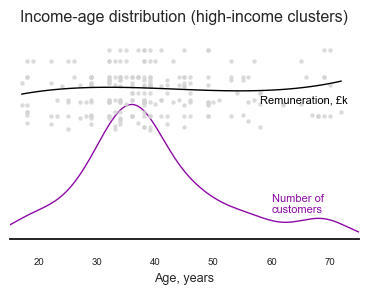

In [320]:
# high income clusters
data = customers_full[(customers_full['cluster'] == '4') | (customers_full['cluster'] == '1')]

# set theme
custom_params = {"axes.spines.right": False, "axes.spines.left": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params)

# Create the figure and axis once
fig, ax1 = plt.subplots(figsize=(4.5,2.5))

# Plot the number of customers by age distribution the first axis
sns.kdeplot(data=data, x='age', ax=ax1, color='#8D0BA5', linewidth=1)

# Create a second y-axis for the line plot and plot polynomial regression if 3rd degree for 'remuneration' 
ax2 = ax1.twinx()

sns.regplot(data=data, x='age', y='remuneration', order=3, ci=None,
            scatter=True, color='black', line_kws={'linewidth': 1},
            scatter_kws={'s': 10, 'color': '#D3D3D3'})

# Set the limits for the x and y axes
ax1.set_xlim(15, 75)  
ax1.set_ylim(0, 0.06)
ax2.set_ylim(0, 100) 

# Add annotation
ax2.text(x=60, y=20, s='Number of', color='#8D0BA5', fontsize=8, ha='left')
ax2.text(x=60, y=14, s='customers', color='#8D0BA5', fontsize=8, ha='left')
ax2.text(x=58, y=71, s='Remuneration, £k', color='black', fontsize=8, ha='left')

# Format tick labels, tickmarks and axis labels  
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax1.tick_params(axis='y', which='both', length=0)
ax2.tick_params(axis='y', which='both', length=0)
ax1.tick_params(axis='x', labelsize = 7) 
ax1.set_xlabel('Age, years', fontsize=9)  
ax1.set_ylabel('')
ax2.set_ylabel('')
plt.title('Income-age distribution (high-income clusters)\n', fontsize=11.5)

# Save the plot to a file (example as PNG)
plt.savefig('remuneration_vs_count_by_age_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Observation: 

Remuneration does not vary significantly by age and at the same time customers older than 40 seem to be underrepresented in high earning clusters. This can potentially be an opportunity to grow high-value segment.


### 8. Update customers_full.scv

In [323]:
# update 'customers_full.csv'
customers_full.to_csv('customers_full.csv', index=False)

In [324]:
# define a variable with the set of columns to identify unique clients 
col_to_merge_on = ['gender', 'age', 'remuneration', 'spending_score', 'loyalty_points', 'education']

In [325]:
reviews.head()

gender  age  remuneration  spending_score  loyalty_points education  \
0    Male   18     12.300000              39             210  Graduate   
1    Male   23     12.300000              81             524  Graduate   
2  Female   22     13.120000               6              40  Graduate   
3  Female   25     13.120000              77             562  Graduate   
4  Female   33     13.940000              40             366  Graduate   

                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:

Your unpainted...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary  
0  The fact that 50% of this space is wasted on a...  
1  Another worthless Dungeon Master's screen from...  
2                    pretty, but also pretty useless  
3                                         Five Stars  
4                                         Money trap

In [326]:
# update reviews_full with all data
reviews_full = reviews.merge(customers_full, how='inner', left_on=col_to_merge_on, right_on=col_to_merge_on, left_index=False, right_index=False)
#customers_full.drop(columns='predicted_class', inplace=True)

reviews_full.shape

(2000, 15)

In [327]:
# view columns
reviews_full.columns

Index(['gender', 'age', 'remuneration', 'spending_score', 'loyalty_points',
       'education', 'review', 'summary', 'customer_ID', 'age_group', 'cluster',
       'predicted_class', 'remuneration_cat', 'spending_score_cat',
       'remuneration_gr'],
      dtype='object')

In [328]:
# reorder columns
reviews_full = reviews_full[['gender', 'age', 'remuneration', 'spending_score', 'loyalty_points',
       'education', 'customer_ID', 'cluster', 'remuneration_cat',
       'spending_score_cat', 'review', 'summary']]

In [329]:
reviews_full.head()

gender  age  remuneration  spending_score  loyalty_points education  \
0    Male   18     12.300000              39             210  Graduate   
1    Male   23     12.300000              81             524  Graduate   
2  Female   22     13.120000               6              40  Graduate   
3  Female   25     13.120000              77             562  Graduate   
4  Female   33     13.940000              40             366  Graduate   

  customer_ID cluster remuneration_cat spending_score_cat  \
0         191       0                1                  1   
1         133       2                1                  3   
2         194       0                1                  1   
3         149       2                1                  3   
4          42       0                1                  1   

                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:

Your unpainted...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary  
0  The fact that 50% of this space is wasted on a...  
1  Another worthless Dungeon Master's screen from...  
2                    pretty, but also pretty useless  
3                                         Five Stars  
4                                         Money trap

In [330]:
# update 'reviews_full.csv'
reviews_full.to_csv('reviews_full.csv', index=False)

### 9. Insights and observations

Customers can be grouped into five clusters based on spending score & remuneration and three groups based on spending score category:

1) ‘High’ spending score:
- Cluster 4: High-Value Customers (high-income)
- Cluster 2: Limited-Potential Customers (low-income)

2) ‘Moderate’ spending score:
  - Cluster 3: Moderate spenders (average income)

3) ‘Low’ spending score:
- Cluster 1: High-Potential Customers (high-income)
- Cluster 0: Low-Value Customers (low-income)

#   

# MLR by spending score category

### 1 Approach

**Approach:**

Evaluate linear regression models for each spending_score_cat:

- high (clusters 2 & 4) (spending_score_cat=3)
- medium (cluster3) (spending_score_cat=2)
- low (cluster 0 & 1) (spending_score_cat=1)

In [337]:
customers_full.head()

customer_ID  gender  age  remuneration  spending_score  loyalty_points  \
0          25  Female   37     14.760000               6              61   
1          29  Female   37     17.220000              35             417   
2          42  Female   33     13.940000              40             366   
3          43  Female   53     22.960000              14             238   
4          71    Male   37     19.680000              35             476   

      education age_group cluster predicted_class remuneration_cat  \
0   High-school     30-40       0               0                1   
1      Graduate     30-40       0               0                1   
2      Graduate     30-40       0               0                1   
3      Graduate     50-60       0               0                1   
4  Postgraduate     30-40       0               0                1   

  spending_score_cat remuneration_gr  
0                  1            0-20  
1                  1            0-20  
2                  1            0-20  
3                  1           20-30  
4                  1            0-20

In [338]:
# Convert the numeric column to string
customers_full['spending_score_cat'] = customers_full['spending_score_cat'].astype(str)

In [339]:
# split the dataset by spending_score_cat and assign varuables 
customers_full_ss_high = customers_full[customers_full['spending_score_cat'] == '3']
customers_full__ss_avg = customers_full[customers_full['spending_score_cat'] == '2']
customers_full_ss_low = customers_full[customers_full['spending_score_cat'] == '1']

### 2 LR_3_rem: spending_score_cat=3 (clusters 2 & 4)

#### Evaluate relationships between features

In [342]:
# view the dataset
customers_full_ss_high.head()

customer_ID  gender  age  remuneration  spending_score  loyalty_points  \
251          27  Female   37     15.580000              99            1067   
252          31    Male   29     22.960000              82            1150   
253          59  Female   37     18.860000              98            1278   
254          67    Male   37     22.960000              61             969   
255         113    Male   33     20.500000              73             982   

        education age_group cluster predicted_class remuneration_cat  \
251  Postgraduate     30-40       2               2                1   
252  Postgraduate     20-30       2               2                1   
253  Postgraduate     30-40       2               2                1   
254      Graduate     30-40       2               2                1   
255           PhD     30-40       2               2                1   

    spending_score_cat remuneration_gr  
251                  3            0-20  
252                  3           20-30  
253                  3            0-20  
254                  3           20-30  
255                  3           20-30

In [343]:
customers_full_ss_high.shape

(248, 13)

To evaluate possible linear relationships between features and loyalty point balances we visualised relationships between features and loyalty point balances using sns.pairplot(), analysed descriptive statistics and Pearson correlation coefficients.

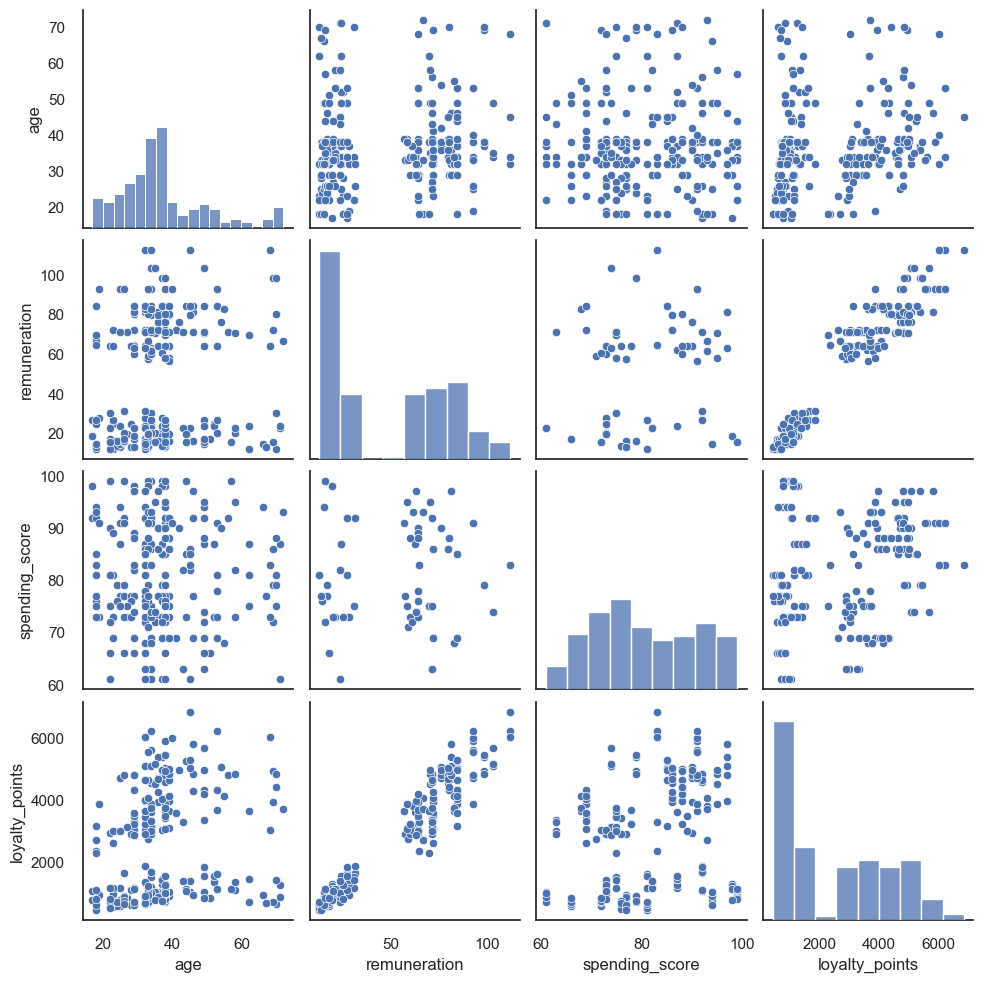

In [345]:
# visualise the distributions & relationships beetween numeric variables   
sns.pairplot(customers_full_ss_high)

In [346]:
# calculate descriptive statistics for customers_full_ss_high df
customers_desc_stat = desc_stat_summary(customers_full_ss_high)
customers_desc_stat

age  remuneration  spending_score  \
count                         248.000000    248.000000      248.000000   
mean                           37.125000     47.728629       80.798387   
std                            12.118364     30.793471       10.047241   
min                            17.000000     12.300000       61.000000   
25%                            29.000000     17.220000       73.000000   
50%                            34.000000     30.340000       79.000000   
75%                            39.000000     73.185000       90.000000   
max                            72.000000    112.340000       99.000000   
range                          55.000000    100.040000       38.000000   
IQR                            10.000000     55.965000       17.000000   
skewness (n=0)                  1.012570      0.291106        0.097448   
kurtosis (n=3)                  3.968043      1.530027        2.054574   
Shapiro-Wilk, stat (n=1)        0.912367      0.852759        0.964898   
Shapiro-Wilk, p-value (>0.05)   0.000000      0.000000        0.000009   

                               loyalty_points  
count                              248.000000  
mean                              2549.862903  
std                               1759.491415  
min                                436.000000  
25%                                932.500000  
50%                               1658.000000  
75%                               4036.250000  
max                               6847.000000  
range                             6411.000000  
IQR                               3103.750000  
skewness (n=0)                       0.428791  
kurtosis (n=3)                       1.726927  
Shapiro-Wilk, stat (n=1)             0.874407  
Shapiro-Wilk, p-value (>0.05)        0.000000

Distribution: 

- remuneration: Clear evidence of non-normality; **SW stat of 0.85 is largely explained by the 'missing' average remuneration segment** in the high spending score category.
- loyalty_points: We note **significant improvement in the loyalty points SW stat compared to the full dataset** (0.87 vs. 0.81) slightly right-tailed distribution and flatter compared to a normal distribution 
- spending_score & age: roughly similar to the full dataset. 


**Action:** evaluate potential effect from loyalty points transformation  

In [349]:
# Pearson correlation to evaluate linear relationships
customers_full_ss_high.corr(method='pearson', numeric_only=True)

age  remuneration  spending_score  loyalty_points
age             1.000000      0.107074       -0.009535        0.186361
remuneration    0.107074      1.000000        0.076360        0.965946
spending_score -0.009535      0.076360        1.000000        0.229860
loyalty_points  0.186361      0.965946        0.229860        1.000000

The Pearson correlation coefficient of 0.97 indicates a very strong positive correlation in the 'remuneration ¬ loyalty points'

Unlike the full dataset, the 'spending score ¬ loyalty points' pair has a weak Pearson correlation coefficient of 0.23, which makes sense given the split approach.

Age¬loyalty_points of 0.19 is weak, but stronger than based on the full dataset 


In [351]:
# Spearman rank correlation to capture possible non-linear but monotonic relationships (e.g. exponential, logarithmic)
customers_full_ss_high.corr(method='spearman', numeric_only=True)

age  remuneration  spending_score  loyalty_points
age             1.000000      0.155120       -0.004583        0.313691
remuneration    0.155120      1.000000        0.028755        0.939001
spending_score -0.004583      0.028755        1.000000        0.267934
loyalty_points  0.313691      0.939001        0.267934        1.000000

High Spearman rank correlation coefficients suggest that non-linear models are worth testing and can potentially perform stronger.

Recognising that the 'loyalty_points' variable is right-skewed we test log and root transformation to achieve a distribution closer to normal.

In [354]:
# apply log, square-root and cube-root transformation to y
customers_full_ss_high.loc[:, 'loyalty_points_log'] = customers_full_ss_high['loyalty_points'].apply(lambda x: np.log(x))
customers_full_ss_high.loc[:, 'loyalty_points_2rt'] = customers_full_ss_high['loyalty_points'].apply(lambda x: math.sqrt(x))
customers_full_ss_high.loc[:, 'loyalty_points_5rt'] = customers_full_ss_high['loyalty_points'].apply(lambda x: math.pow(x, 1/5))

# calculate descriptive statistics for customers df
customers_desc_stat = desc_stat_summary(customers_full_ss_high)
customers_desc_stat

age  remuneration  spending_score  \
count                         248.000000    248.000000      248.000000   
mean                           37.125000     47.728629       80.798387   
std                            12.118364     30.793471       10.047241   
min                            17.000000     12.300000       61.000000   
25%                            29.000000     17.220000       73.000000   
50%                            34.000000     30.340000       79.000000   
75%                            39.000000     73.185000       90.000000   
max                            72.000000    112.340000       99.000000   
range                          55.000000    100.040000       38.000000   
IQR                            10.000000     55.965000       17.000000   
skewness (n=0)                  1.012570      0.291106        0.097448   
kurtosis (n=3)                  3.968043      1.530027        2.054574   
Shapiro-Wilk, stat (n=1)        0.912367      0.852759        0.964898   
Shapiro-Wilk, p-value (>0.05)   0.000000      0.000000        0.000009   

                               loyalty_points  loyalty_points_log  \
count                              248.000000          248.000000   
mean                              2549.862903            7.559835   
std                               1759.491415            0.789125   
min                                436.000000            6.077642   
25%                                932.500000            6.837869   
50%                               1658.000000            7.413367   
75%                               4036.250000            8.303069   
max                               6847.000000            8.831566   
range                             6411.000000            2.753924   
IQR                               3103.750000            1.465200   
skewness (n=0)                       0.428791           -0.061515   
kurtosis (n=3)                       1.726927            1.450019   
Shapiro-Wilk, stat (n=1)             0.874407            0.898062   
Shapiro-Wilk, p-value (>0.05)        0.000000            0.000000   

                               loyalty_points_2rt  loyalty_points_5rt  
count                                  248.000000          248.000000  
mean                                    47.244729            4.591891  
std                                     17.862954            0.717598  
min                                     20.880613            3.372076  
25%                                     30.536860            3.925814  
50%                                     40.718546            4.404706  
75%                                     63.531448            5.262540  
max                                     82.746601            5.849248  
range                                   61.865988            2.477173  
IQR                                     32.994588            1.336726  
skewness (n=0)                           0.186011            0.040580  
kurtosis (n=3)                           1.463295            1.422303  
Shapiro-Wilk, stat (n=1)                 0.889578            0.895662  
Shapiro-Wilk, p-value (>0.05)            0.000000            0.000000

In [355]:
# Pearson correlation to evaluate linear relationships
customers_full_ss_high.corr(method='pearson', numeric_only=True)

age  remuneration  spending_score  loyalty_points  \
age                 1.000000      0.107074       -0.009535        0.186361   
remuneration        0.107074      1.000000        0.076360        0.965946   
spending_score     -0.009535      0.076360        1.000000        0.229860   
loyalty_points      0.186361      0.965946        0.229860        1.000000   
loyalty_points_log  0.194856      0.958396        0.216428        0.970549   
loyalty_points_2rt  0.188230      0.970692        0.221904        0.992954   
loyalty_points_5rt  0.191557      0.965560        0.218283        0.981466   

                    loyalty_points_log  loyalty_points_2rt  loyalty_points_5rt  
age                           0.194856            0.188230            0.191557  
remuneration                  0.958396            0.970692            0.965560  
spending_score                0.216428            0.221904            0.218283  
loyalty_points                0.970549            0.992954            0.981466  
loyalty_points_log            1.000000            0.992001            0.998657  
loyalty_points_2rt            0.992001            1.000000            0.997188  
loyalty_points_5rt            0.998657            0.997188            1.000000

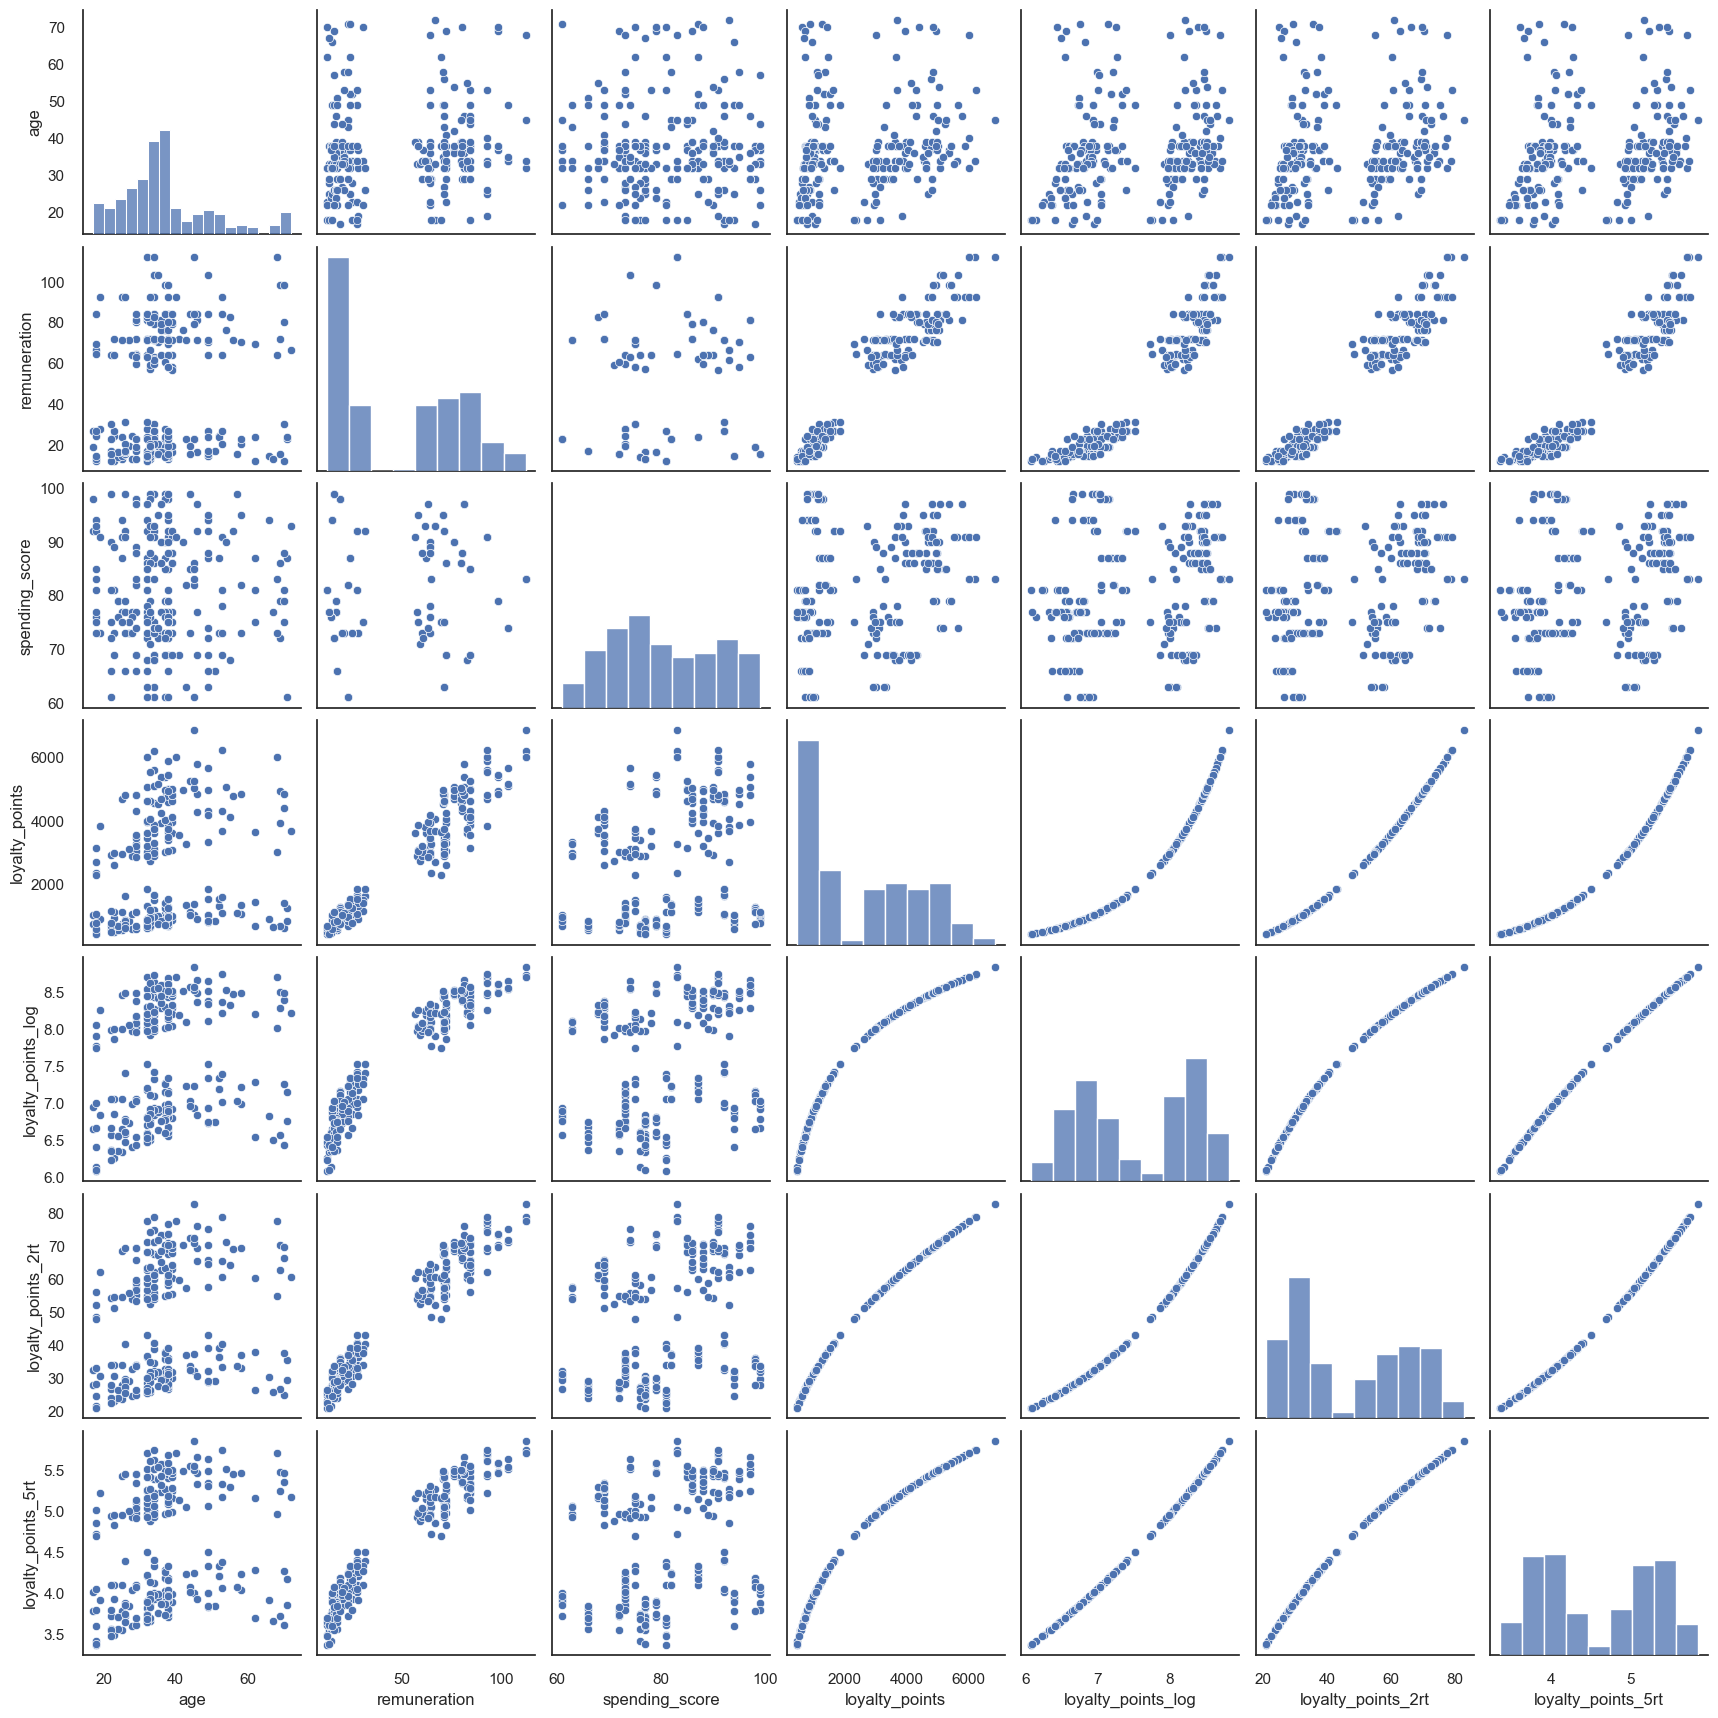

In [356]:
# visualise the distributions & relationships beetween numeric variables   
sns.pairplot(customers_full_ss_high)

Transformations slightly improve the normality of loyalty points distribution (S-W stat) with no meaningful improvement in correlation coefficients

At the same time, visual exploration suggests that root transformations result in patterns with more even variance addressing inherent heteroscedasticity.

**Note:** The assumption of linearity is not fully met. 

**Decision:** Apply cube-root transformation to loyalty_points

In [358]:
# drop redundant columns
customers_full_ss_high.drop(columns = ['loyalty_points_log', 'loyalty_points_2rt'], inplace=True)

Observation:

The most significant feature is remuneration with 0.97 Pearson correlation.


**Decision:** continue with X = remuneration and Y = loyalty points 5th root transformation

#### Create and fit the model

In [361]:
# define variables
y_tr = customers_full_ss_high['loyalty_points_5rt'] 
y = customers_full_ss_high['loyalty_points'] 
X = customers_full_ss_high[['remuneration']]

Recognising the relatively large dataset size of 782 observations, allocated 0.8 to the train set. The random_state parameter of 42 is used for reproducibility.

In [363]:
#Split the data in 'train' (80%) and 'test' (20%) sets.
X_train, X_test, Y_tr_train, Y_tr_test, Y_obs_train, Y_obs_test = sklearn.model_selection.train_test_split(X, y_tr, y,
                                                                            test_size = 0.20,
                                                                            random_state = 42)

# view the underlying shape of the train and test data sets 
print(Y_tr_train.describe(), Y_tr_test.describe())

count   198.000000
mean      4.568026
std       0.703765
min       3.372076
25%       3.919689
50%       4.404706
75%       5.221152
max       5.740180
Name: loyalty_points_5rt, dtype: float64 count   50.000000
mean     4.686394
std      0.770119
min      3.547703
25%      3.989163
50%      4.419771
75%      5.447856
max      5.849248
Name: loyalty_points_5rt, dtype: float64


Central tendency stats are comparable - no issues 

Used the statsmodels ols method to create and fit linear regression model 

In [366]:
# Create & fit the model
mlr_model = sm.OLS(Y_tr_train, sm.add_constant(X_train)).fit()

LR_3_rem = mlr_model

#  print summary of metrics
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:     loyalty_points_5rt   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     2697.
Date:                Wed, 22 Jan 2025   Prob (F-statistic):          1.56e-116
Time:                        13:42:20   Log-Likelihood:                 55.627
No. Observations:                 198   AIC:                            -107.3
Df Residuals:                     196   BIC:                            -100.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.5141      0.024    145.652   

Observation: 

- All features are significant with p< 0.05 and explain 96.6% of the variability in the **transformed** dependent variable
- The independent variables' coefficients have expected signs, but are not interpretable for the transformation applied


Decision:

Continue with the model - prepare a summary of linear regression assumptions & analyse them, assess accuracy and test how the model generalises on unseen data 

In [368]:
# Predict the training set values
Y_tr_train_pred = mlr_model.predict(sm.add_constant(X_train)) 

# apply backward transformation 
Y_train_pred = Y_tr_train_pred.apply(lambda x: math.pow(x, 5))

# Predict the test set values
Y_tr_test_pred = mlr_model.predict(sm.add_constant(X_test)) 

# apply backward transformation 
Y_test_pred = Y_tr_test_pred.apply(lambda x: math.pow(x, 5))

#### Check linear regression assumptions

Accept the significance level (alpha) of 0.05

In [371]:
# view model statistics 
LR_stat_summary = LR_stat_summary.merge(LR_statistics(mlr_model, X_train, 'LR_3_rem'), how='outer', left_index=True, right_index=True)
LR_stat_summary

MLR_all LR_3_rem
Durbin-Watson statistic (1.5-2.5) 1.933877 2.298320
F statistic p-value (< 0.05)      0.000000 0.000000
JB Probability (> 0.05)           0.000000 0.192341
LM Test p-value (> 0.05)          0.578577 0.165024
Resid. vs remuneration corr          -0.00    -0.00
Resid. vs spending_score corr        -0.00      NaN
VIF Factor: remuneration (<10)    1.000195 1.000000
VIF Factor: spending_score (<10)  1.000195      NaN

F-statistic p-value < 0.05 indicates that the regression model is statistically significant.

LR assumptions are satisfied based on the criteria stated in the table above.

Note that this is the only model with the optional Normality of error terms satisfied.

##### Residuals vs. X-Variable(s) Plot (linearity assumption)

Residuals vs. X-Variable(s) Plot checks the linearity assumption for each predictor individually. It shows the relationship between residuals and each independent variable (X).


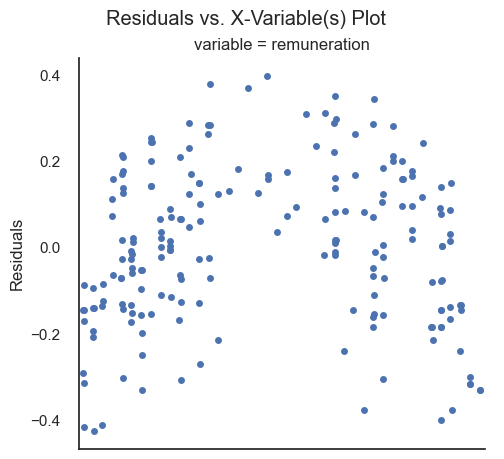

In [375]:
# prepare data for the residuals vs. X visualisation
res_plot = X_train.copy()
res_plot['Residuals'] = mlr_model.resid
res_plot = res_plot.melt(id_vars='Residuals')

# Plot the residuals versus the x-values.
g = sns.catplot(res_plot, y='Residuals', x='value', col='variable')
g.fig.suptitle("Residuals vs. X-Variable(s) Plot", y=1.02)

# Remove x-axis labels, tick labels, and tick marks for each subplot
for ax in g.axes.flat:
    ax.set_xlabel("") 
    ax.set_xticks([])
    ax.set_xticklabels([])
plt.show()

Observation: 

- No strong patterns were identified, which together with the patterns observed on pairplots and Pearson correlation coefficients suggests a strong linear relationship.

##### Residuals vs. Fitted Values Plot (linearity, homoscedasticity, autocorrelation)

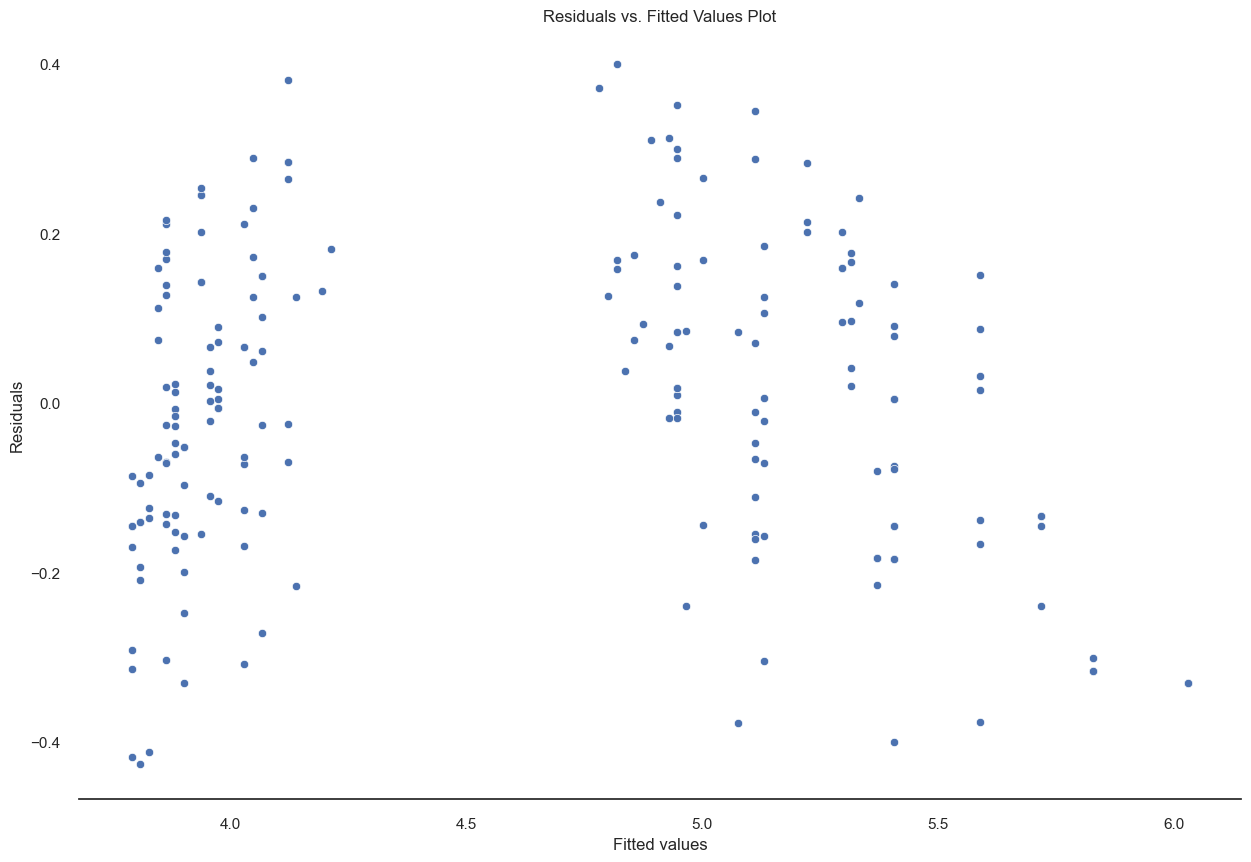

In [378]:
# Plot the residuals versus the predicted values on the train dataset.
sns.scatterplot(y = mlr_model.resid, x= Y_tr_train_pred)
plt.ylabel("Residuals")
plt.xlabel("Fitted values")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

The scatter slightly deviates from perfect 'white noise', but no strong patterns.  

##### Residuals Q-Q plot (Normality of error terms)

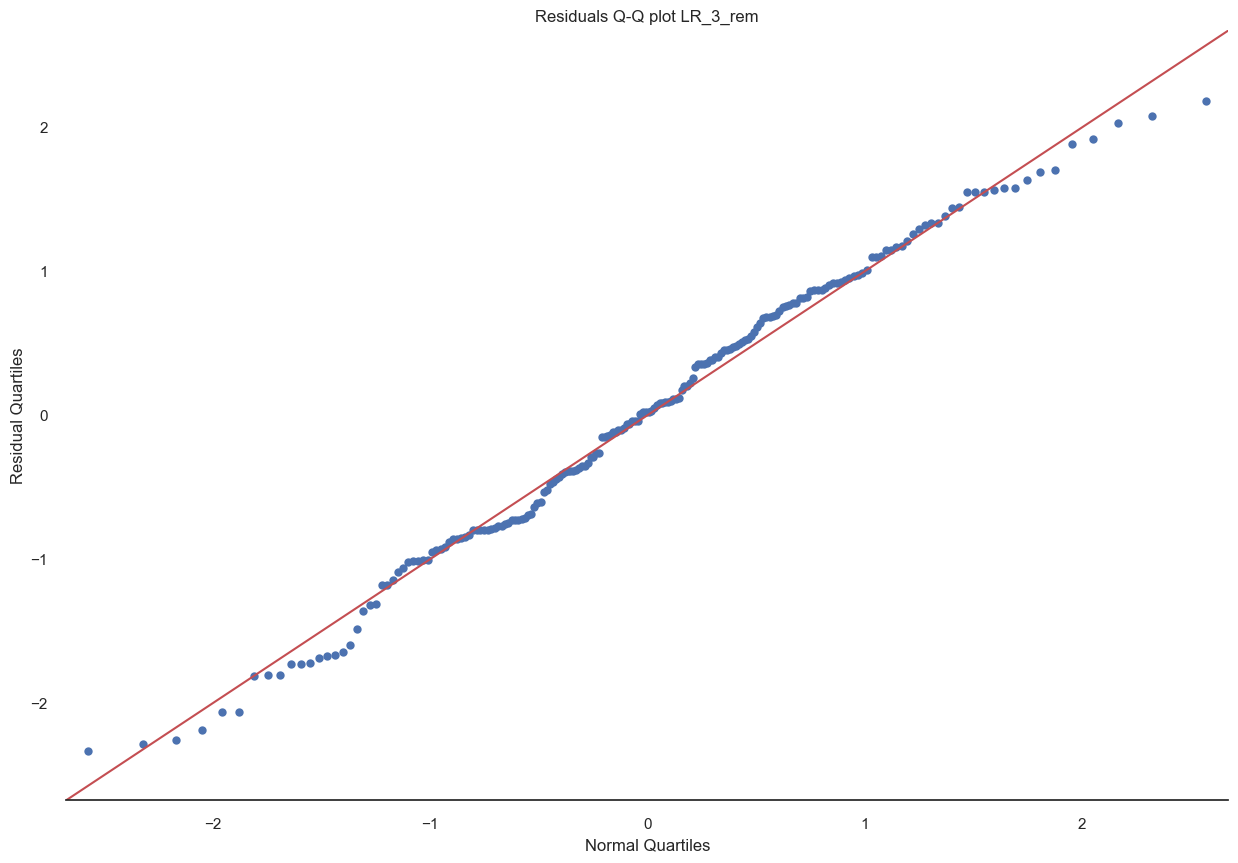

In [381]:
# Plot the quartiles of the residuals versus the quartiles of the N(0,1)
# The fit=True argument first Standardises the observed data (Residuals) before plotting them
sm.qqplot(mlr_model.resid, fit=True, line='45')
plt.ylabel("Residual Quartiles")
plt.xlabel("Normal Quartiles")
plt.title("Residuals Q-Q plot LR_3_rem")
plt.show()

Observation: 

The optional assumption of Normality of error terms is satisfied.

#### Assess accuracy & test how the model generalises on unseen data 

Calculate and analyse goodness-of-fit measures:
- On the trainind dataset to evaluate the model's capacity to learn from the data. Helps identify underfitting (e.g., high training error or low R2).
- On the Test Dataset to assess how well the model generalises to unseen data.  Helps identify overfitting (e.g., much better metrics on training data than on test data).


In [385]:
# summarise goodness of fit measures for train dataset 
MLR_gof_summary = goodness_of_fit(Y_obs_train, Y_train_pred,  mlr_model, 'LR_3_rem_train')

# add GOF for test dataset 
MLR_gof_summary = MLR_gof_summary.merge(goodness_of_fit(Y_obs_test, Y_test_pred,  mlr_model, 'LR_3_rem_test'), left_index=True, right_index=True)

# print the summary
MLR_gof_summary

LR_3_rem_train  LR_3_rem_test
R2                     0.890409       0.869809
R2 (train)             0.932260       0.932260
Adj. R2 (train)        0.931914       0.931914
RMSE                 556.926425     717.926025
MAE                  390.353951     537.882979
MAPE, %               16.670551      19.523268
q1 (y_real)          925.250000    1010.250000
q3 (y_real)         3880.000000    4798.750000
mean (y_real)       2469.545455    2867.920000

Observation: 

FAIR FOR BOTH TRAIN & TEST

- The R-squared is strong and explains slightly more than 90% of the dependent variable (both on train & test).
- MAE & RMSE are smaller than the mean value of Y with MAPE slightly above 25%
- The difference between RMSE and MAE is moderate/small, which suggests that the model's prediction errors are relatively consistent and that there are few extreme outliers.

The model's performance is noted. To be compared with other models.


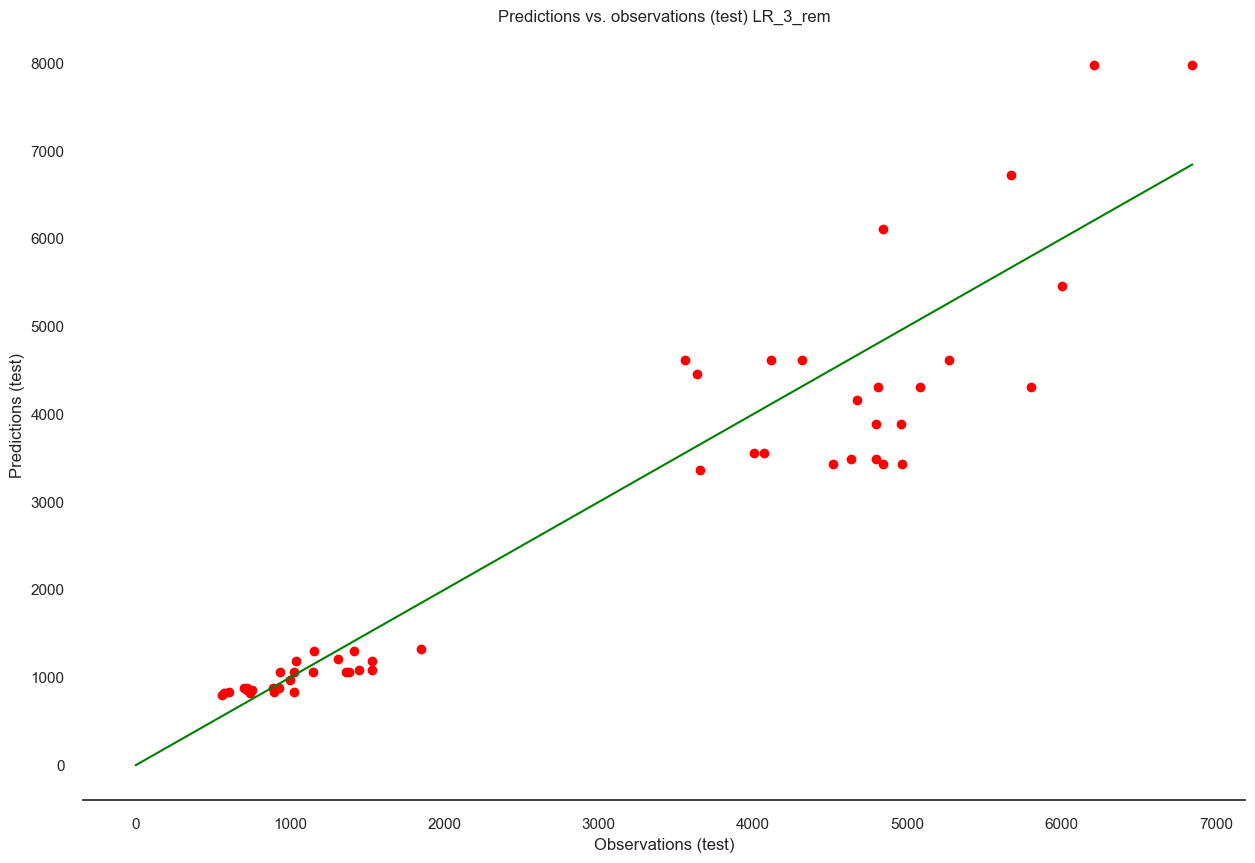

In [387]:
# Plot Predictions (y) vs. observations (x) on the test dataset
X_var = Y_obs_test
Y_var = Y_test_pred

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_var, Y_var, color='red')

# Add a diagonal line
plt.plot([0, X_var.max()], [0, X_var.max()], color='green')

# Labeling the axes
ax.set_xlabel('Observations (test)')
ax.set_ylabel('Predictions (test)')
ax.set_title('Predictions vs. observations (test) LR_3_rem')

plt.show()

Supports the observations above

In [389]:
# update and print the goodness of fit summary
gof_summary = gof_summary.merge(MLR_gof_summary['LR_3_rem_test'], left_index=True, right_index=True)

# view 
gof_summary

DT_prunned_test DT_fin_test    MLR_test  LR_3_rem_test
R2                     0.908051    0.902689    0.906427       0.869809
R2 (train)                 None        None    0.891825       0.932260
Adj. R2 (train)            None        None    0.891478       0.931914
RMSE                 390.108166  401.321993  393.538048     717.926025
MAE                  274.656903  296.629368  318.451350     537.882979
MAPE, %               23.133588   27.254099   26.413167      19.523268
q1 (y_real)          777.000000  777.000000  777.000000    1010.250000
q3 (y_real)         1686.000000 1686.000000 1686.000000    4798.750000
mean (y_real)       1529.000000 1529.000000 1529.000000    2867.920000

Given the linear regression assumptions are satisfied, models can be used to predict loyalty points with the accuracy as described in the summary above.

### 3 MLR_2 (square-root): spending_score_cat=2 (cluster 3)

#### Evaluate relationships between features

In [393]:
# view the dataset
customers_full__ss_avg.head()

customer_ID  gender  age  remuneration  spending_score  loyalty_points  \
378           0  Female   33     32.800000              42             904   
379           2  Female   50     36.080000              50            1338   
380           3  Female   38     49.200000              40            1376   
381           4  Female   36     47.560000              60            1951   
382           5  Female   49     44.280000              42            1379   

        education age_group cluster predicted_class remuneration_cat  \
378      Graduate     30-40       3               3                2   
379  Postgraduate     40-50       3               3                2   
380           PhD     30-40       3               3                2   
381           PhD     30-40       3               3                2   
382      Graduate     40-50       3               3                2   

    spending_score_cat remuneration_gr  
378                  2           30-40  
379                  2           30-40  
380                  2           40-50  
381                  2           40-50  
382                  2           40-50

In [394]:
customers_full__ss_avg.shape

(283, 13)

To evaluate possible linear relationships between features and loyalty point balances we visualised relationships between features and loyalty point balances using sns.pairplot(), analysed descriptive statistics and Pearson correlation coefficients.

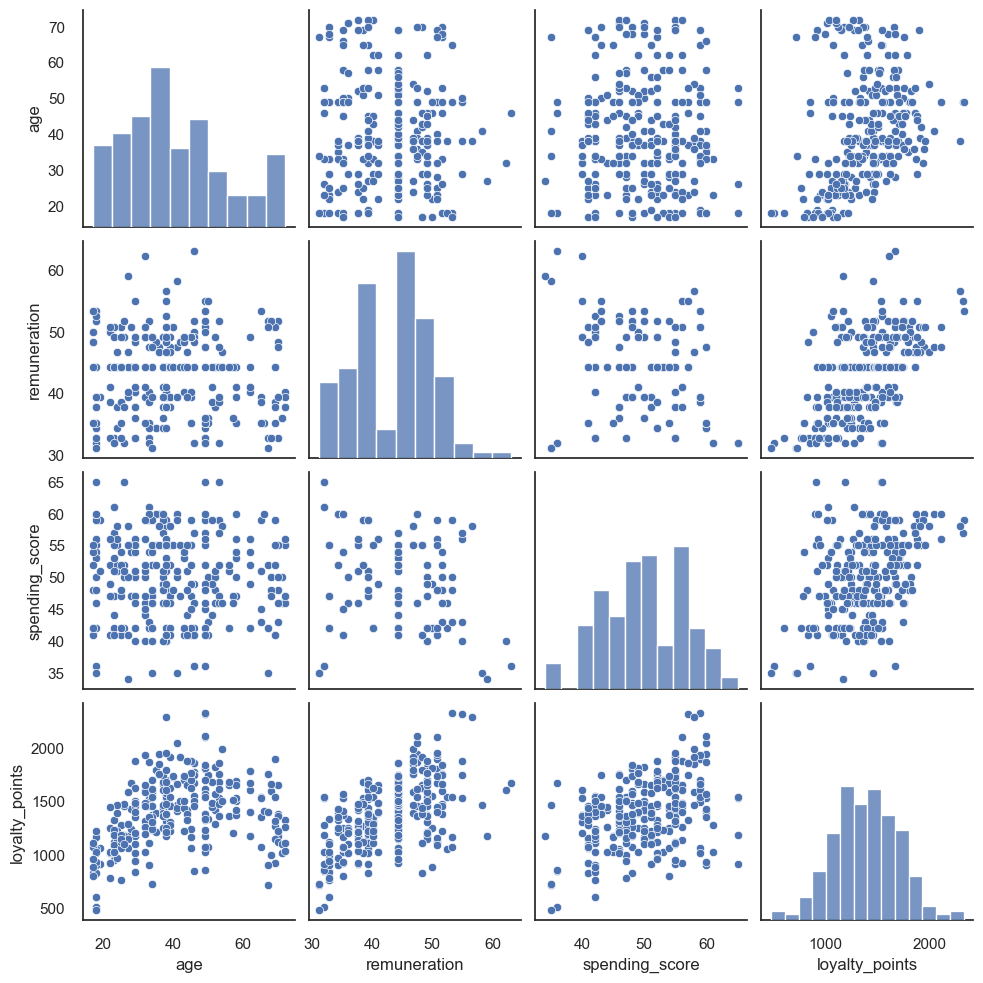

In [396]:
# visualise the distributions & relationships beetween numeric variables   
sns.pairplot(customers_full__ss_avg)

In [397]:
# calculate descriptive statistics for df
customers_desc_stat = desc_stat_summary(customers_full__ss_avg)
customers_desc_stat

age  remuneration  spending_score  \
count                         283.000000    283.000000      283.000000   
mean                           40.310954     42.947138       49.893993   
std                            14.664164      6.497970        6.579255   
min                            17.000000     31.160000       34.000000   
25%                            29.000000     37.720000       46.000000   
50%                            38.000000     44.280000       50.000000   
75%                            49.000000     48.380000       55.000000   
max                            72.000000     63.140000       65.000000   
range                          55.000000     31.980000       31.000000   
IQR                            20.000000     10.660000        9.000000   
skewness (n=0)                  0.462103      0.151877       -0.104848   
kurtosis (n=3)                  2.442123      2.486520        2.350634   
Shapiro-Wilk, stat (n=1)        0.956272      0.969325        0.978556   
Shapiro-Wilk, p-value (>0.05)   0.000000      0.000010        0.000296   

                               loyalty_points  
count                              283.000000  
mean                              1389.890459  
std                                318.982767  
min                                478.000000  
25%                               1176.000000  
50%                               1395.000000  
75%                               1619.500000  
max                               2332.000000  
range                             1854.000000  
IQR                                443.500000  
skewness (n=0)                       0.036918  
kurtosis (n=3)                       3.047252  
Shapiro-Wilk, stat (n=1)             0.996618  
Shapiro-Wilk, p-value (>0.05)        0.812760

Distribution: 

- loyalty_points: are normally distributed with SW stat of 0.99; mesokurtic symmetrical distribution (skewness of 0 and kurtosis of 3).  
- remuneration & spending_score: symmetrical distributions, slightly heavy-tailed but reasonably close to normal distribution. 
- age: slightly deviates from normality (slight right-skew and flatter than normal)


**Action:** Evaluate potential effect of loyalty points transformation to address heteroscedasticity 

In [400]:
# Pearson correlation to evaluate linear relationships
customers_full__ss_avg.corr(method='pearson', numeric_only=True)

age  remuneration  spending_score  loyalty_points
age             1.000000     -0.045529       -0.045160        0.318068
remuneration   -0.045529      1.000000       -0.165671        0.576787
spending_score -0.045160     -0.165671        1.000000        0.428491
loyalty_points  0.318068      0.576787        0.428491        1.000000

The Pearson correlation coefficient of 0.57 indicates a moderate positive correlation in the 'remuneration ¬ loyalty points'

'spending score ¬ loyalty points' and 'Age¬loyalty_points' pairs have weak coefficients of 42.8% and 31.8 respectively.

Based on visual inspection we observe strong evidence of a linear relationship in the  'remuneration ¬ loyalty points' & 'spending score ¬ loyalty points' pairs, given the three variables are normally distributed. The respective moderate Pearson correlation coefficients support this. 
Since age deviates from normality and the pattern of the relationship differs from linear with a lower correlation compared to other variables, we will test the following options: 

test:
- X = remuneration & spending_score & age and Y = loyalty points root tranormation

In [402]:
# Spearman rank correlation to capture possible non-linear but monotonic relationships (e.g. exponential, logarithmic)
customers_full__ss_avg.corr(method='spearman', numeric_only=True)

age  remuneration  spending_score  loyalty_points
age             1.000000     -0.027703       -0.057088        0.397038
remuneration   -0.027703      1.000000       -0.149405        0.558502
spending_score -0.057088     -0.149405        1.000000        0.410911
loyalty_points  0.397038      0.558502        0.410911        1.000000

Spearman rank correlation coefficients suggest that non-linear models are worth testing and can potentially perform stronger.

Test log and square-root transformation to address heteroscedasticity

In [405]:
# apply log, square-root and cube-root transformation to y
customers_full__ss_avg.loc[:, 'loyalty_points_log'] = customers_full__ss_avg['loyalty_points'].apply(lambda x: np.log(x))
customers_full__ss_avg.loc[:, 'loyalty_points_2rt'] = customers_full__ss_avg['loyalty_points'].apply(lambda x: math.sqrt(x))
customers_full__ss_avg.loc[:, 'loyalty_points_3rt'] = customers_full__ss_avg['loyalty_points'].apply(lambda x: math.pow(x, 1/3))

# calculate descriptive statistics for customers df
customers_desc_stat = desc_stat_summary(customers_full__ss_avg)
customers_desc_stat

age  remuneration  spending_score  \
count                         283.000000    283.000000      283.000000   
mean                           40.310954     42.947138       49.893993   
std                            14.664164      6.497970        6.579255   
min                            17.000000     31.160000       34.000000   
25%                            29.000000     37.720000       46.000000   
50%                            38.000000     44.280000       50.000000   
75%                            49.000000     48.380000       55.000000   
max                            72.000000     63.140000       65.000000   
range                          55.000000     31.980000       31.000000   
IQR                            20.000000     10.660000        9.000000   
skewness (n=0)                  0.462103      0.151877       -0.104848   
kurtosis (n=3)                  2.442123      2.486520        2.350634   
Shapiro-Wilk, stat (n=1)        0.956272      0.969325        0.978556   
Shapiro-Wilk, p-value (>0.05)   0.000000      0.000010        0.000296   

                               loyalty_points  loyalty_points_log  \
count                              283.000000          283.000000   
mean                              1389.890459            7.208402   
std                                318.982767            0.247010   
min                                478.000000            6.169611   
25%                               1176.000000            7.069874   
50%                               1395.000000            7.240650   
75%                               1619.500000            7.389872   
max                               2332.000000            7.754482   
range                             1854.000000            1.584871   
IQR                                443.500000            0.319998   
skewness (n=0)                       0.036918           -0.806980   
kurtosis (n=3)                       3.047252            4.398668   
Shapiro-Wilk, stat (n=1)             0.996618            0.965371   
Shapiro-Wilk, p-value (>0.05)        0.812760            0.000003   

                               loyalty_points_2rt  loyalty_points_3rt  
count                                  283.000000          283.000000  
mean                                    37.023824           11.090693  
std                                      4.381182            0.886196  
min                                     21.863211            7.818846  
25%                                     34.292853           10.555263  
50%                                     37.349699           11.173556  
75%                                     40.243000           11.743391  
max                                     48.290786           13.260997  
range                                   26.427575            5.442152  
IQR                                      5.950147            1.188128  
skewness (n=0)                          -0.350095           -0.492351  
kurtosis (n=3)                           3.333056            3.581760  
Shapiro-Wilk, stat (n=1)                 0.990215            0.984169  
Shapiro-Wilk, p-value (>0.05)            0.054947            0.003217

In [406]:
# Pearson correlation to evaluate linear relationships
customers_full__ss_avg.corr(method='pearson', numeric_only=True)

age  remuneration  spending_score  loyalty_points  \
age                 1.000000     -0.045529       -0.045160        0.318068   
remuneration       -0.045529      1.000000       -0.165671        0.576787   
spending_score     -0.045160     -0.165671        1.000000        0.428491   
loyalty_points      0.318068      0.576787        0.428491        1.000000   
loyalty_points_log  0.333694      0.573348        0.424942        0.982700   
loyalty_points_2rt  0.327365      0.577527        0.427699        0.996004   
loyalty_points_3rt  0.329853      0.576747        0.427024        0.992709   

                    loyalty_points_log  loyalty_points_2rt  loyalty_points_3rt  
age                           0.333694            0.327365            0.329853  
remuneration                  0.573348            0.577527            0.576747  
spending_score                0.424942            0.427699            0.427024  
loyalty_points                0.982700            0.996004            0.992709  
loyalty_points_log            1.000000            0.995256            0.997823  
loyalty_points_2rt            0.995256            1.000000            0.999503  
loyalty_points_3rt            0.997823            0.999503            1.000000

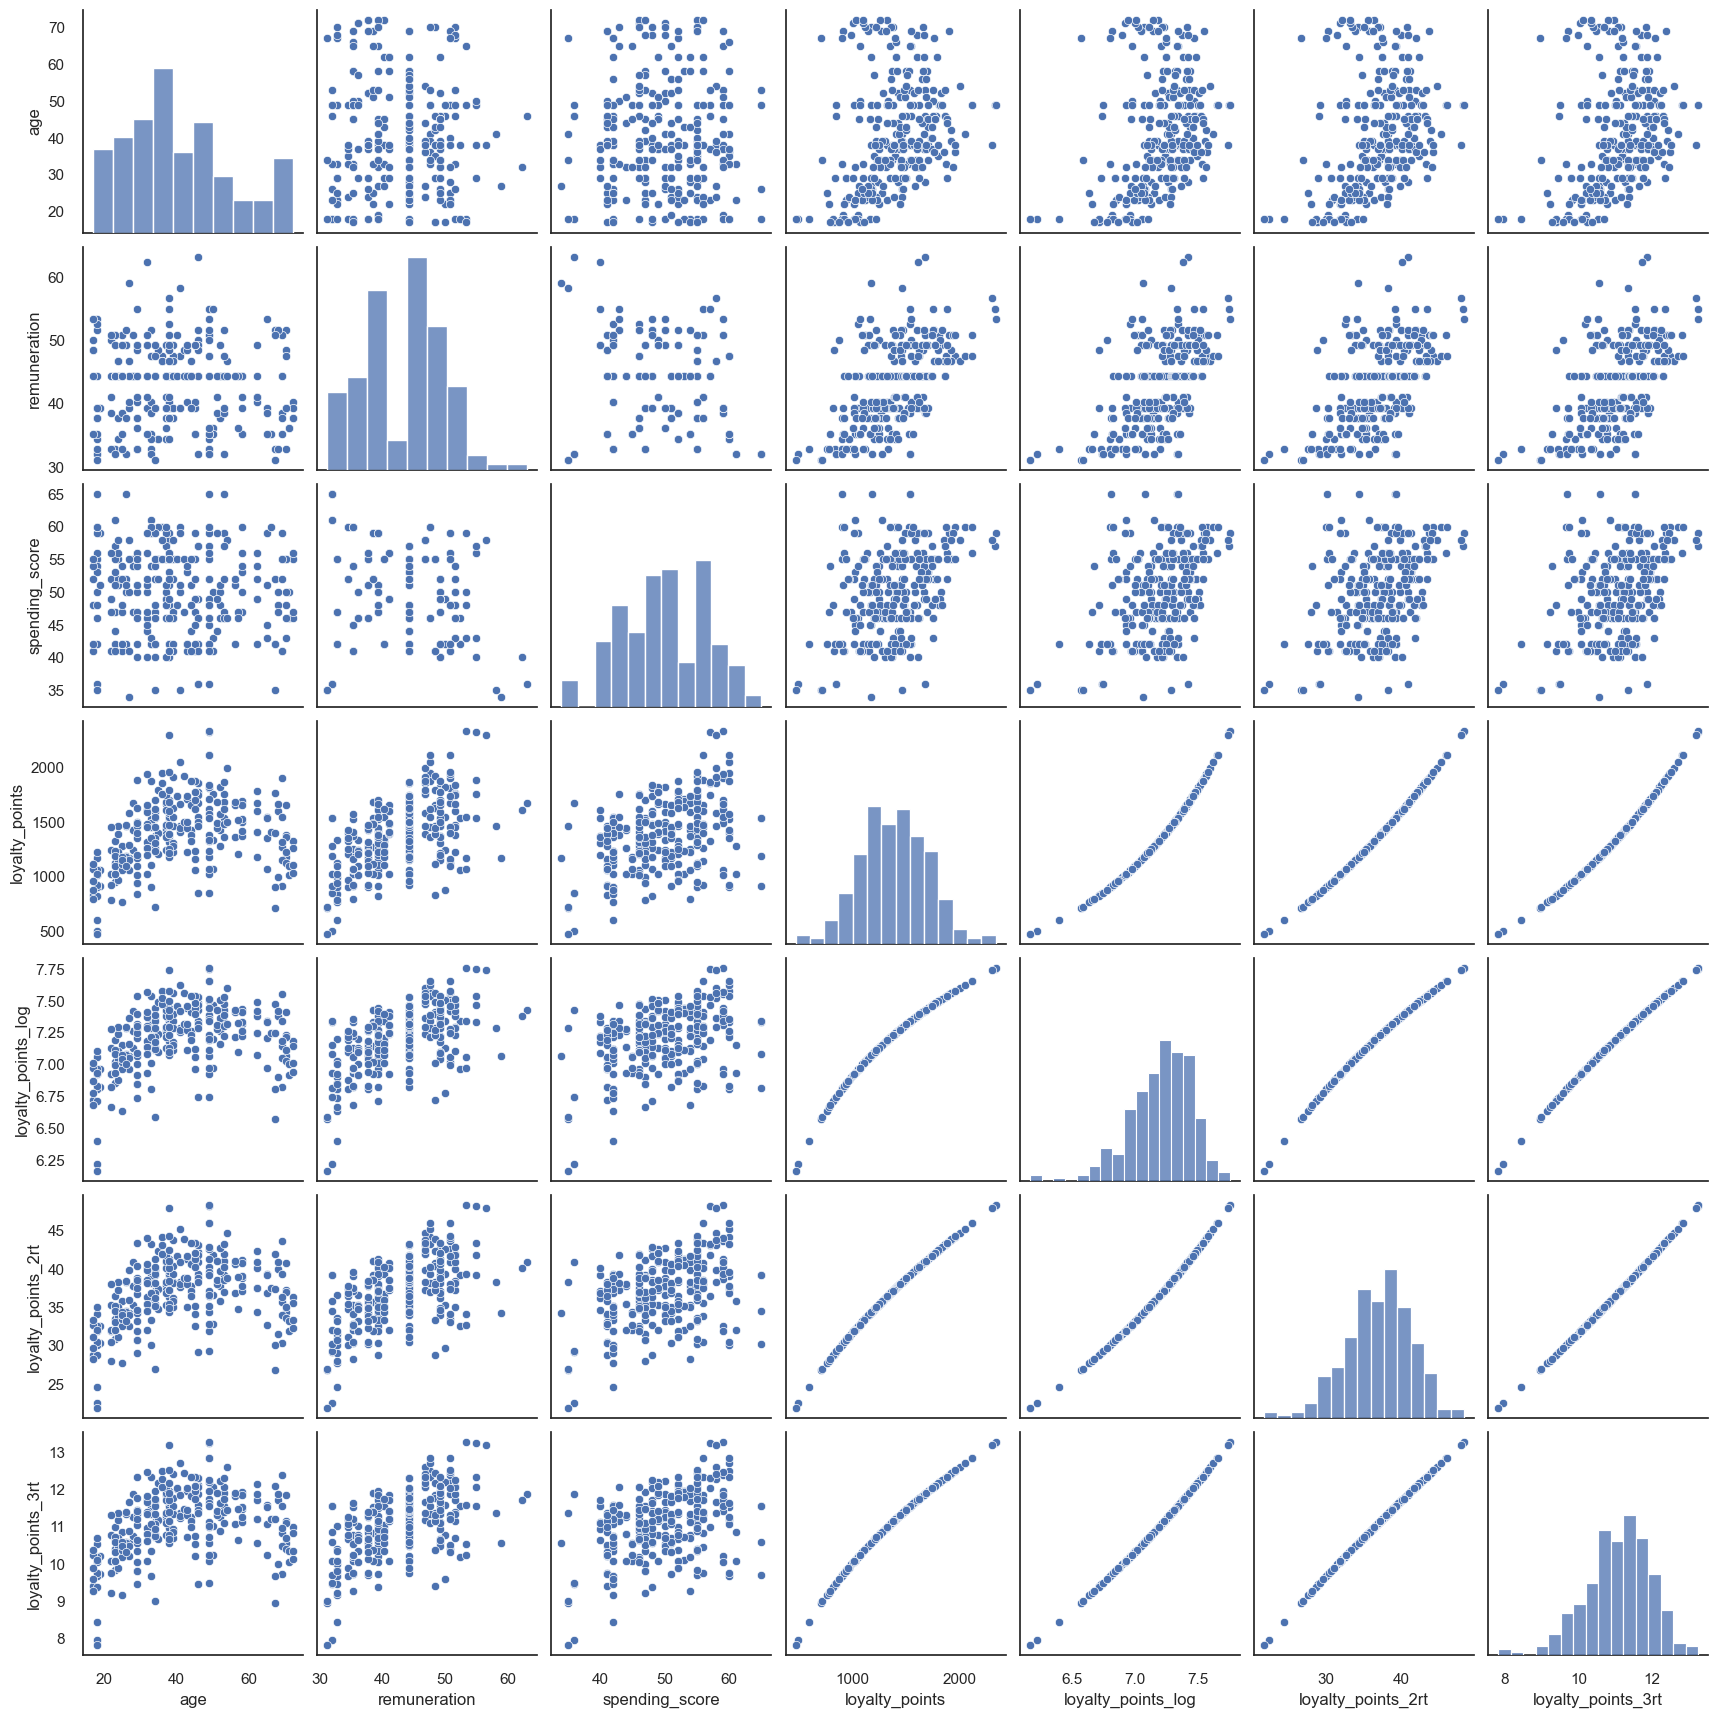

In [407]:
# visualise the distributions & relationships beetween numeric variables   
sns.pairplot(customers_full__ss_avg)

No obvious change in patterns, but square-root transformation results in the homoscedasticity assumption being satisfied.

**Decision:** Apply square-root transformation to loyalty_points

In [409]:
# drop redundant columns
customers_full__ss_avg.drop(columns = ['loyalty_points_log', 'loyalty_points_3rt'], inplace=True)

Observation:

select featires with corr > 30%

**Decision:** continue with X = remuneration & spending_score & age and Y = loyalty points 

#### Create and fit the model

In [412]:
# define variables
y_tr = customers_full__ss_avg['loyalty_points_2rt'] 
y = customers_full__ss_avg['loyalty_points'] 
X = customers_full__ss_avg[['remuneration', 'spending_score', 'age']]

Recognising the relatively large dataset size of 782 observations, allocated 0.8 to the train set. The random_state parameter of 42 is used for reproducibility.

In [414]:
#Split the data in 'train' (80%) and 'test' (20%) sets.
X_train, X_test, Y_tr_train, Y_tr_test, Y_obs_train, Y_obs_test = sklearn.model_selection.train_test_split(X, y_tr, y,
                                                                            test_size = 0.20,
                                                                            random_state = 42)

# view the underlying shape of the train and test data sets 
print(Y_tr_train.describe(), Y_tr_test.describe())

count   226.000000
mean     37.025419
std       4.392797
min      21.863211
25%      34.186957
50%      37.536649
75%      40.274061
max      48.290786
Name: loyalty_points_2rt, dtype: float64 count   57.000000
mean    37.017500
std      4.373559
min     22.449944
25%     34.856850
50%     37.242449
75%     39.899875
max     45.254834
Name: loyalty_points_2rt, dtype: float64


Central tendency stats are comparable - no issues 

Used the statsmodels ols method to create and fit linear regression model 

In [417]:
# Create & fit the model
mlr_model = sm.OLS(Y_tr_train, sm.add_constant(X_train)).fit()

#  print summary of metrics
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:     loyalty_points_2rt   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     244.5
Date:                Wed, 22 Jan 2025   Prob (F-statistic):           4.63e-70
Time:                        13:42:34   Log-Likelihood:                -489.74
No. Observations:                 226   AIC:                             987.5
Df Residuals:                     222   BIC:                             1001.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -5.6437      1.637     -3.

###### Observation: 

- All features are significant with p< 0.05 and explain 76.8% of the variability in the **transformed** dependent variable
- The independent variables' coefficients have expected signs, but are not interpretable for the transformation applied


Decision:

Continue with the model - prepare a summary of linear regression assumptions & analyse them, assess accuracy and test how the model generalises on unseen data 

In [419]:
# Predict the training set values
Y_tr_train_pred = mlr_model.predict(sm.add_constant(X_train)) 

# apply backward transformation 
Y_train_pred = Y_tr_train_pred.apply(lambda x: math.pow(x, 2))

# Predict the test set values
Y_tr_test_pred = mlr_model.predict(sm.add_constant(X_test)) 

# apply backward transformation 
Y_test_pred = Y_tr_test_pred.apply(lambda x: math.pow(x, 2))

#### Check linear regression assumptions

Accept the significance level (alpha) of 0.05

In [422]:
# view model statistics 
LR_stat_summary = LR_stat_summary.merge(LR_statistics(mlr_model, X_train, 'MLR_2'), how='outer', left_index=True, right_index=True)
LR_stat_summary

MLR_all LR_3_rem    MLR_2
Durbin-Watson statistic (1.5-2.5) 1.933877 2.298320 1.982308
F statistic p-value (< 0.05)      0.000000 0.000000 0.000000
JB Probability (> 0.05)           0.000000 0.192341 0.000000
LM Test p-value (> 0.05)          0.578577 0.165024 0.126928
Resid. vs age corr                     NaN      NaN     0.00
Resid. vs remuneration corr          -0.00    -0.00    -0.00
Resid. vs spending_score corr        -0.00      NaN    -0.00
VIF Factor: age (<10)                  NaN      NaN 1.000956
VIF Factor: remuneration (<10)    1.000195 1.000000 1.042453
VIF Factor: spending_score (<10)  1.000195      NaN 1.041482

F-statistic p-value < 0.05 indicates that the regression model is statistically significant.

Metrics above indicate that LR assumptions are satisfied with the following exception:

- Normality of error terms (optional); JB probability < 0.05 suggests that the residuals significantly deviate from normality. This is supported by the "Residuals Q-Q plot" below.



##### Residuals vs. X-Variable(s) Plot (linearity assumption)

Residuals vs. X-Variable(s) Plot checks the linearity assumption for each predictor individually. It shows the relationship between residuals and each independent variable (X).


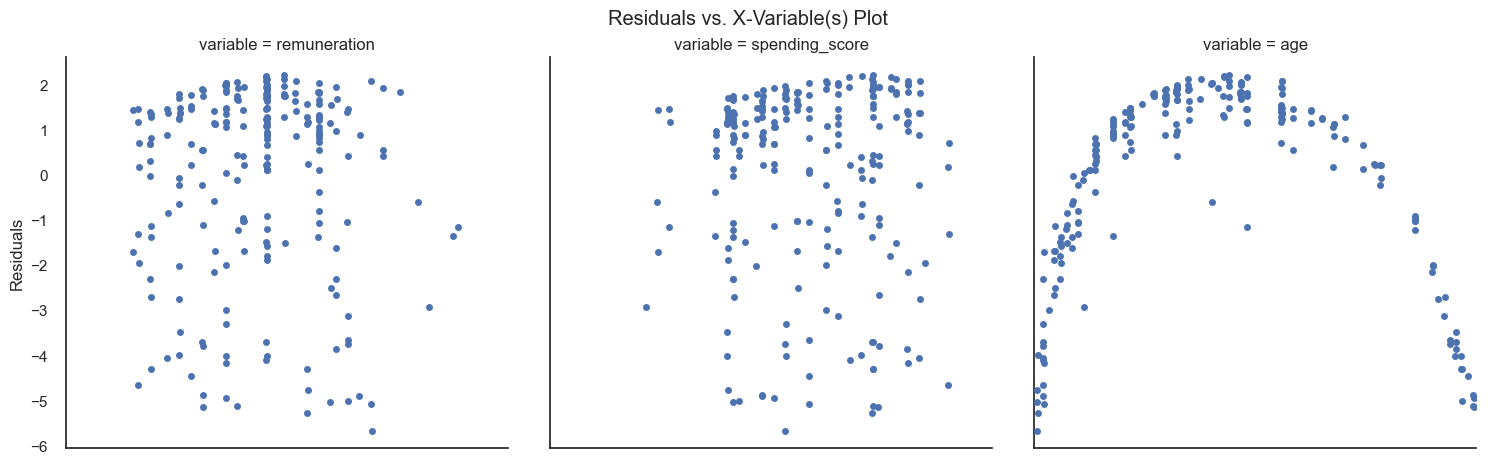

In [426]:
# prepare data for the residuals vs. X visualisation
res_plot = X_train.copy()
res_plot['Residuals'] = mlr_model.resid
res_plot = res_plot.melt(id_vars='Residuals')

# Plot the residuals versus the x-values.
g = sns.catplot(res_plot, y='Residuals', x='value', col='variable')
g.fig.suptitle("Residuals vs. X-Variable(s) Plot", y=1.02)

# Remove x-axis labels, tick labels, and tick marks for each subplot
for ax in g.axes.flat:
    ax.set_xlabel("") 
    ax.set_xticks([])
    ax.set_xticklabels([])
plt.show()

Observation: 

- No strong patterns were identified in remuneration and spending_score. Reverse U-shape pattern for age - linearity violation. - exclude the variable 

##### Residuals vs. Fitted Values Plot (linearity, homoscedasticity, autocorrelation)

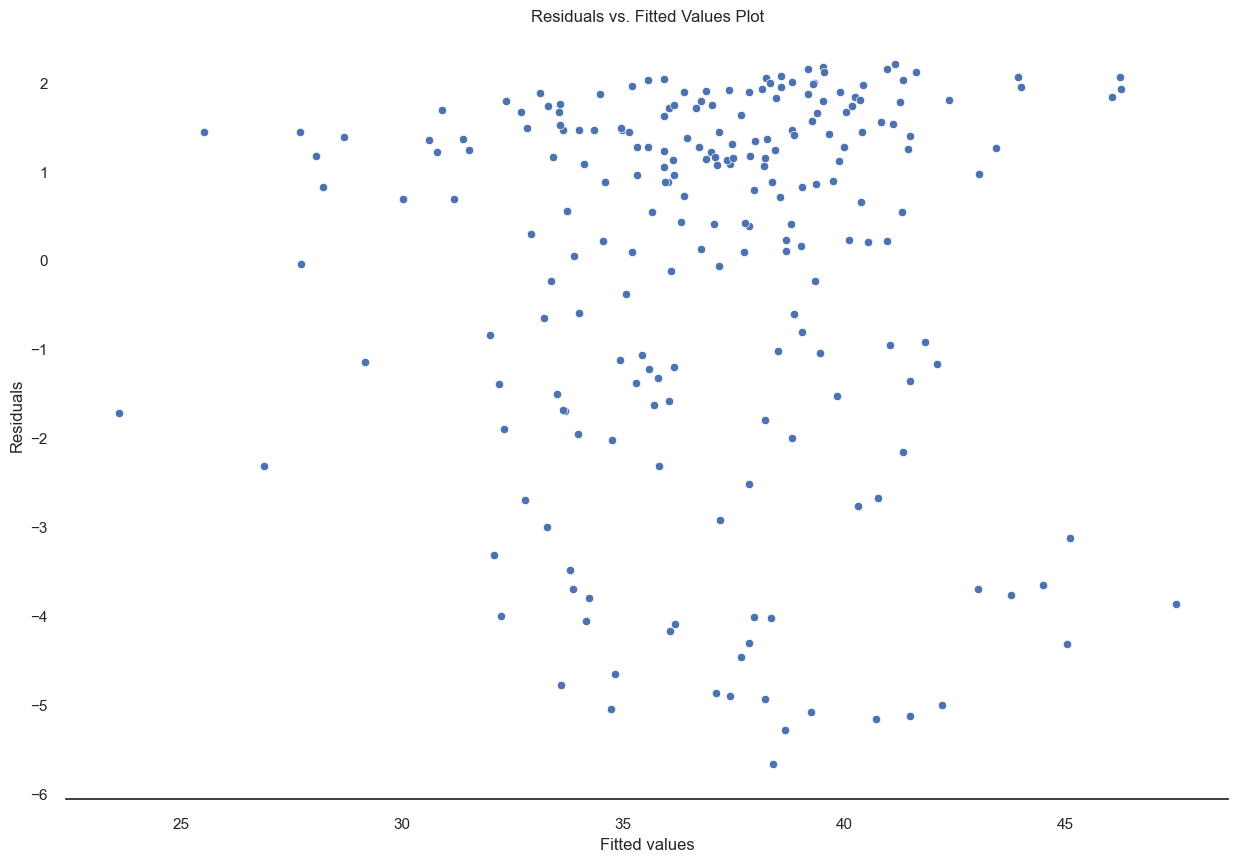

In [429]:
# Plot the residuals versus the predicted values on the train dataset.
sns.scatterplot(y = mlr_model.resid, x= Y_tr_train_pred)
plt.ylabel("Residuals")
plt.xlabel("Fitted values")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

The scatter slightly deviates from perfect 'white noise', but no strong patterns.  

##### Residuals Q-Q plot (Normality of error terms)

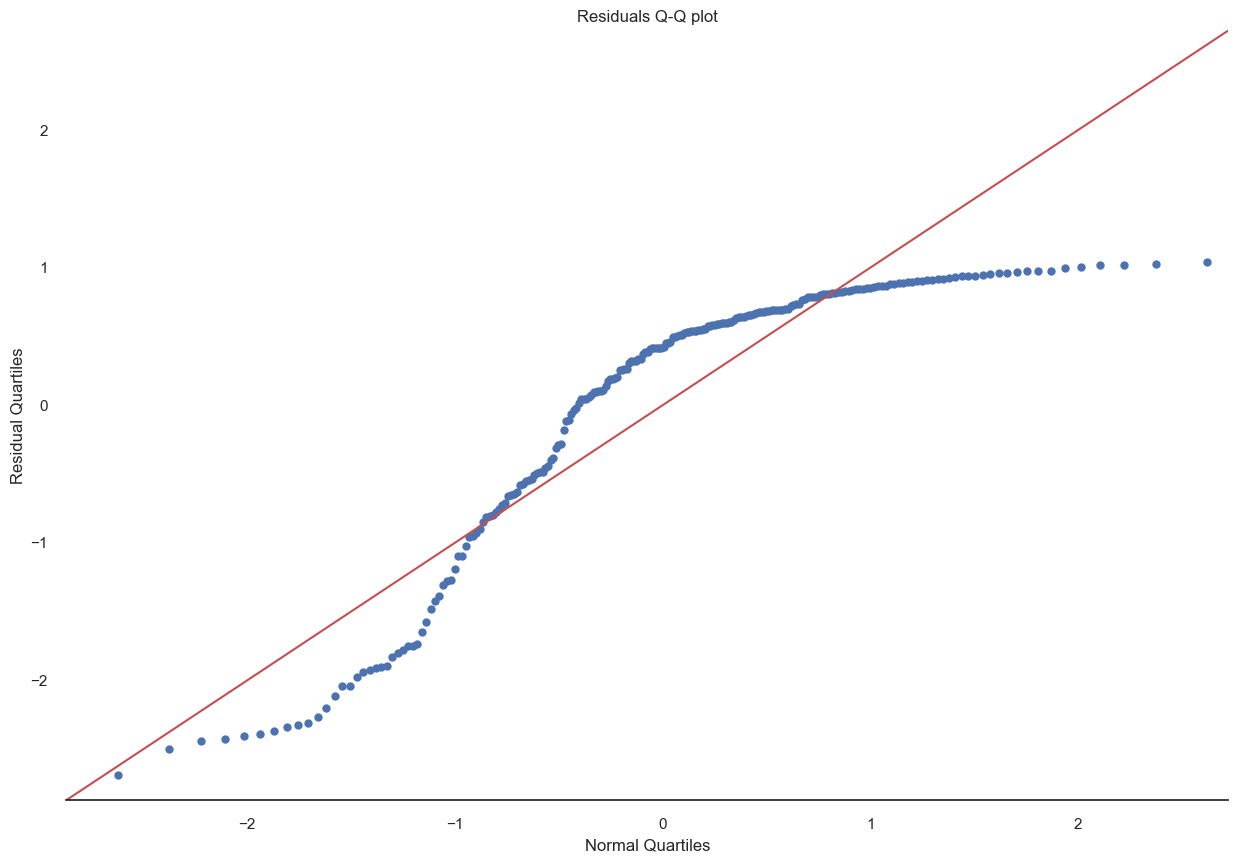

In [432]:
# Plot the quartiles of the residuals versus the quartiles of the N(0,1)
# The fit=True argument first Standardises the observed data (Residuals) before plotting them
sm.qqplot(mlr_model.resid, fit=True, line='45')
plt.ylabel("Residual Quartiles")
plt.xlabel("Normal Quartiles")
plt.title("Residuals Q-Q plot")
plt.show()

Observation: 

The optional assumption of Normality of error terms is violated.

 OLS does not require that the error term follows a normal distribution to produce unbiased estimates with the minimum variance. However, satisfying this assumption allows you to perform statistical hypothesis testing and generate reliable confidence intervals and prediction intervals.

#### Assess accuracy & test how the model generalises on unseen data 

Calculate and analyse goodness-of-fit measures:
- On the trainind dataset to evaluate the model's capacity to learn from the data. Helps identify underfitting (e.g., high training error or low R2).
- On the Test Dataset to assess how well the model generalises to unseen data.  Helps identify overfitting (e.g., much better metrics on training data than on test data).


In [436]:
# summarise goodness of fit measures for training dataset 
MLR_gof_summary = goodness_of_fit(Y_obs_train, Y_train_pred,  mlr_model, 'MLR_2_train')

# add GOF for the test dataset 
MLR_gof_summary = MLR_gof_summary.merge(goodness_of_fit(Y_obs_test, Y_test_pred,  mlr_model, 'MLR_2_test'), left_index=True, right_index=True)

# print the summary
MLR_gof_summary

MLR_2_train  MLR_2_test
R2                  0.762496    0.724945
R2 (train)          0.767631    0.767631
Adj. R2 (train)     0.764491    0.764491
RMSE              155.894753  163.907850
MAE               128.741268  135.886796
MAPE, %             9.277706    9.783861
q1 (y_real)      1168.750000 1215.000000
q3 (y_real)      1622.000000 1592.000000
mean (y_real)    1390.092920 1389.087719

Observation: 

NOT RELEVANT AS LINEARITY FOR AGE IS VIOLATED - SEE 9d

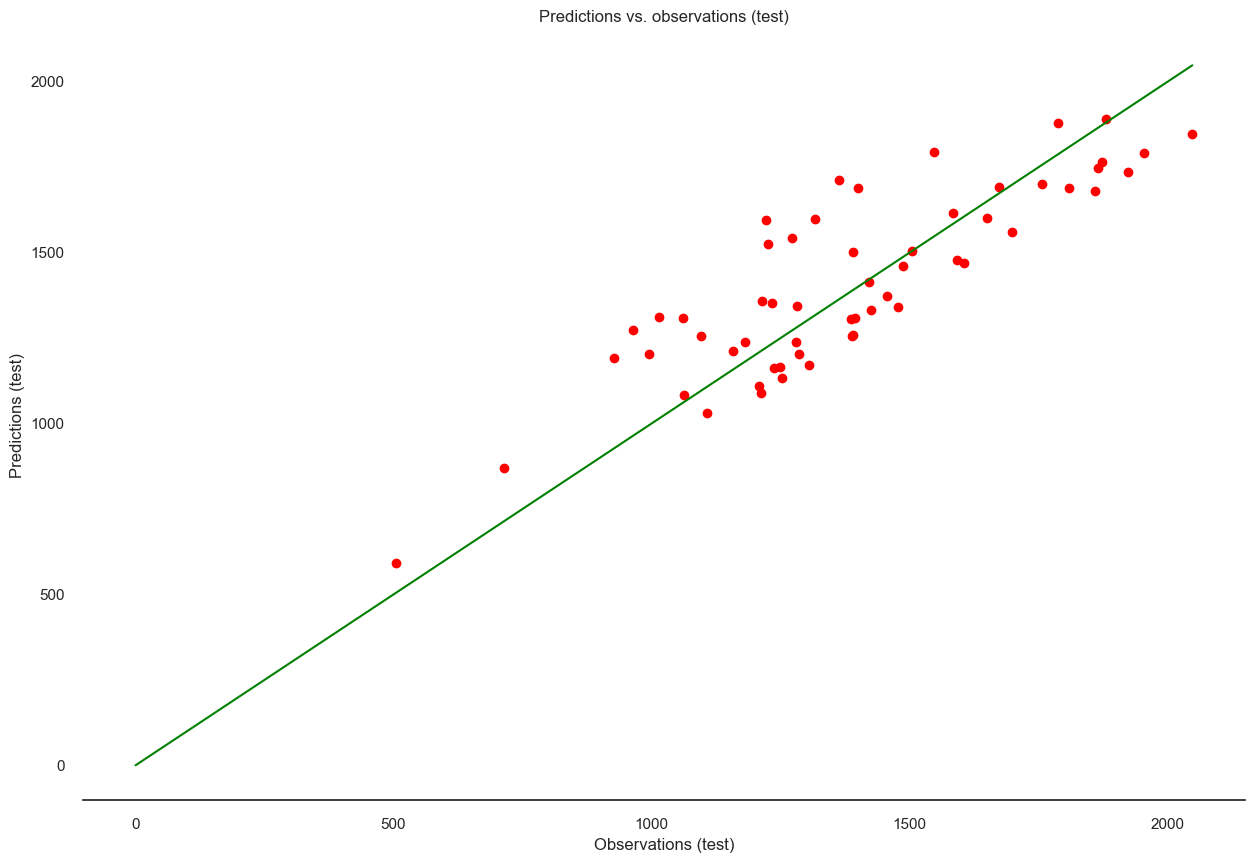

In [438]:
# Plot Predictions (y) vs. observations (x) on the test dataset
X_var = Y_obs_test
Y_var = Y_test_pred

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_var, Y_var, color='red')

# Add a diagonal line
plt.plot([0, X_var.max()], [0, X_var.max()], color='green')

# Labeling the axes
ax.set_xlabel('Observations (test)')
ax.set_ylabel('Predictions (test)')
ax.set_title('Predictions vs. observations (test)')

plt.show()

In [439]:
# update and print the goodness of fit summary
gof_summary = gof_summary.merge(MLR_gof_summary['MLR_2_test'], left_index=True, right_index=True)

# view 
gof_summary

DT_prunned_test DT_fin_test    MLR_test  LR_3_rem_test  \
R2                     0.908051    0.902689    0.906427       0.869809   
R2 (train)                 None        None    0.891825       0.932260   
Adj. R2 (train)            None        None    0.891478       0.931914   
RMSE                 390.108166  401.321993  393.538048     717.926025   
MAE                  274.656903  296.629368  318.451350     537.882979   
MAPE, %               23.133588   27.254099   26.413167      19.523268   
q1 (y_real)          777.000000  777.000000  777.000000    1010.250000   
q3 (y_real)         1686.000000 1686.000000 1686.000000    4798.750000   
mean (y_real)       1529.000000 1529.000000 1529.000000    2867.920000   

                 MLR_2_test  
R2                 0.724945  
R2 (train)         0.767631  
Adj. R2 (train)    0.764491  
RMSE             163.907850  
MAE              135.886796  
MAPE, %            9.783861  
q1 (y_real)     1215.000000  
q3 (y_real)     1592.000000  
mean (y_real)   1389.087719

### 4 MLR_1: spending_score_cat=1 (clusters 0 & 1)

#### Evaluate relationships between features

In [442]:
# view the dataset
customers_full_ss_low.head()

customer_ID  gender  age  remuneration  spending_score  loyalty_points  \
0          25  Female   37     14.760000               6              61   
1          29  Female   37     17.220000              35             417   
2          42  Female   33     13.940000              40             366   
3          43  Female   53     22.960000              14             238   
4          71    Male   37     19.680000              35             476   

      education age_group cluster predicted_class remuneration_cat  \
0   High-school     30-40       0               0                1   
1      Graduate     30-40       0               0                1   
2      Graduate     30-40       0               0                1   
3      Graduate     50-60       0               0                1   
4  Postgraduate     30-40       0               0                1   

  spending_score_cat remuneration_gr  
0                  1            0-20  
1                  1            0-20  
2                  1            0-20  
3                  1           20-30  
4                  1            0-20

In [443]:
customers_full_ss_low.shape

(251, 13)

To evaluate possible linear relationships between features and loyalty point balances we visualised relationships between features and loyalty point balances using sns.pairplot(), analysed descriptive statistics and Pearson correlation coefficients.

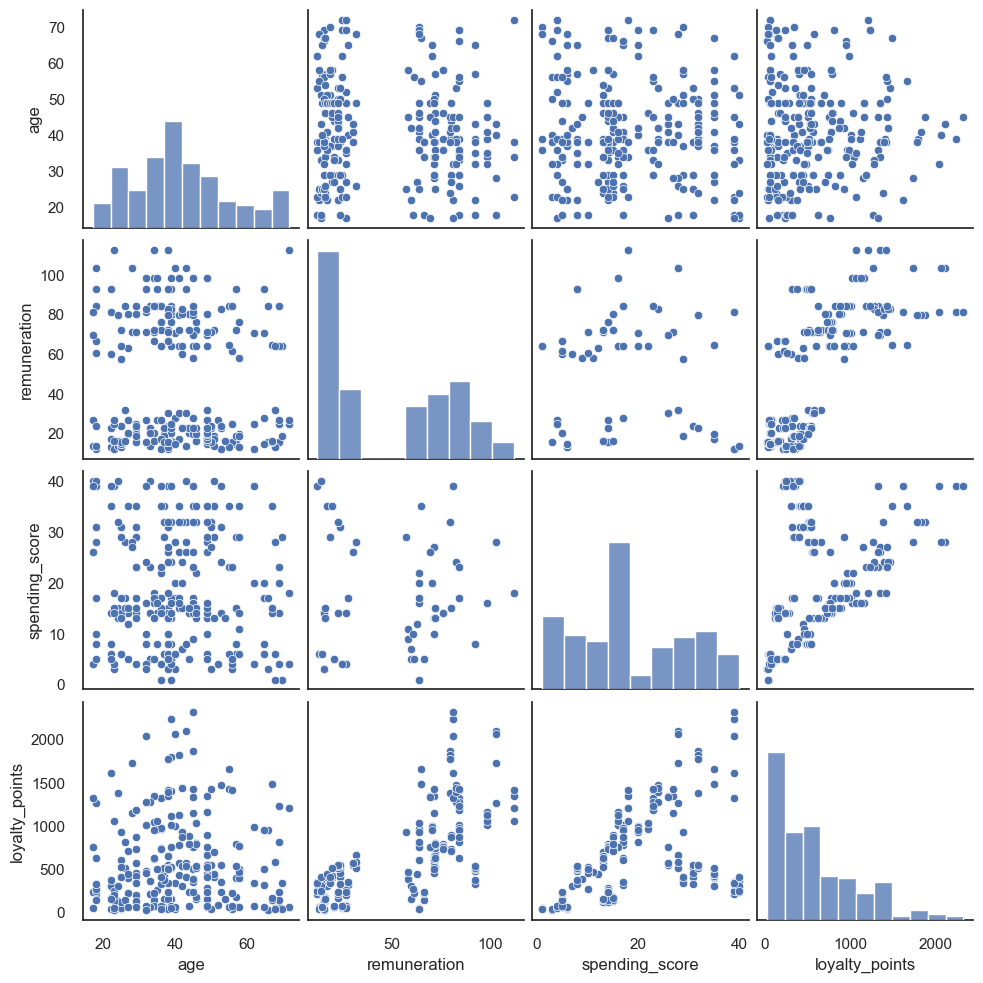

In [445]:
# visualise the distributions & relationships beetween numeric variables   
sns.pairplot(customers_full_ss_low)

In [446]:
# calculate descriptive statistics for the df
customers_desc_stat = desc_stat_summary(customers_full_ss_low)
customers_desc_stat

age  remuneration  spending_score  \
count                         251.000000    251.000000      251.000000   
mean                           41.103586     47.916096       18.458167   
std                            13.672353     31.464744       11.020401   
min                            17.000000     12.300000        1.000000   
25%                            32.000000     17.220000       10.000000   
50%                            39.000000     27.880000       15.000000   
75%                            49.000000     77.900000       28.000000   
max                            72.000000    112.340000       40.000000   
range                          55.000000    100.040000       39.000000   
IQR                            17.000000     60.680000       18.000000   
skewness (n=0)                  0.395143      0.319524        0.389527   
kurtosis (n=3)                  2.546315      1.501808        2.029907   
Shapiro-Wilk, stat (n=1)        0.967704      0.845462        0.935699   
Shapiro-Wilk, p-value (>0.05)   0.000019      0.000000        0.000000   

                               loyalty_points  
count                              251.000000  
mean                               578.745020  
std                                504.999547  
min                                 25.000000  
25%                                157.000000  
50%                                450.000000  
75%                                845.500000  
max                               2325.000000  
range                             2300.000000  
IQR                                688.500000  
skewness (n=0)                       1.115255  
kurtosis (n=3)                       3.730760  
Shapiro-Wilk, stat (n=1)             0.886047  
Shapiro-Wilk, p-value (>0.05)        0.000000

Distribution: 

- remuneration: Clear evidence of non-normality; **SW stat of 0.85 is largely explained by the 'missing' average remuneration segment** in the high spending score category.

**Action:** evaluate potential effect from loyalty points transformation  

In [449]:
# Pearson correlation to evaluate linear relationships
customers_full_ss_low.corr(method='pearson', numeric_only=True)

age  remuneration  spending_score  loyalty_points
age             1.000000     -0.056461       -0.080117        0.010688
remuneration   -0.056461      1.000000       -0.032804        0.748220
spending_score -0.080117     -0.032804        1.000000        0.480902
loyalty_points  0.010688      0.748220        0.480902        1.000000

The Pearson correlation coefficient of 0.74 indicates a strong positive correlation in the 'remuneration ¬ loyalty points'

 'spending score ¬ loyalty points' pair has a moderate Pearson correlation coefficient of 0.48.

Age¬loyalty_points of - no correlation 



In [451]:
# Spearman rank correlation to capture possible non-linear but monotonic relationships (e.g. exponential, logarithmic)
customers_full_ss_low.corr(method='spearman', numeric_only=True)

age  remuneration  spending_score  loyalty_points
age             1.000000     -0.039907       -0.028426        0.048163
remuneration   -0.039907      1.000000        0.058629        0.764358
spending_score -0.028426      0.058629        1.000000        0.610508
loyalty_points  0.048163      0.764358        0.610508        1.000000

High Spearman rank correlation coefficients suggest that non-linear models are worth testing and can potentially perform stronger.

Recognising that the 'loyalty_points' variable is right-skewed we test log and square-root transformation to achieve a distribution closer to normal.

In [454]:
# apply log, square-root and cube-root transformation to y
customers_full_ss_low.loc[:, 'loyalty_points_log'] = customers_full_ss_low['loyalty_points'].apply(lambda x: np.log(x))
customers_full_ss_low.loc[:, 'loyalty_points_2rt'] = customers_full_ss_low['loyalty_points'].apply(lambda x: math.sqrt(x))
customers_full_ss_low.loc[:, 'loyalty_points_3rt'] = customers_full_ss_low['loyalty_points'].apply(lambda x: math.pow(x, 1/3))

# calculate descriptive statistics for customers df
customers_desc_stat = desc_stat_summary(customers_full_ss_low)
customers_desc_stat

age  remuneration  spending_score  \
count                         251.000000    251.000000      251.000000   
mean                           41.103586     47.916096       18.458167   
std                            13.672353     31.464744       11.020401   
min                            17.000000     12.300000        1.000000   
25%                            32.000000     17.220000       10.000000   
50%                            39.000000     27.880000       15.000000   
75%                            49.000000     77.900000       28.000000   
max                            72.000000    112.340000       40.000000   
range                          55.000000    100.040000       39.000000   
IQR                            17.000000     60.680000       18.000000   
skewness (n=0)                  0.395143      0.319524        0.389527   
kurtosis (n=3)                  2.546315      1.501808        2.029907   
Shapiro-Wilk, stat (n=1)        0.967704      0.845462        0.935699   
Shapiro-Wilk, p-value (>0.05)   0.000019      0.000000        0.000000   

                               loyalty_points  loyalty_points_log  \
count                              251.000000          251.000000   
mean                               578.745020            5.870976   
std                                504.999547            1.121244   
min                                 25.000000            3.218876   
25%                                157.000000            5.056246   
50%                                450.000000            6.109248   
75%                                845.500000            6.739473   
max                               2325.000000            7.751475   
range                             2300.000000            4.532599   
IQR                                688.500000            1.683227   
skewness (n=0)                       1.115255           -0.527306   
kurtosis (n=3)                       3.730760            2.286762   
Shapiro-Wilk, stat (n=1)             0.886047            0.946445   
Shapiro-Wilk, p-value (>0.05)        0.000000            0.000000   

                               loyalty_points_2rt  loyalty_points_3rt  
count                                  251.000000          251.000000  
mean                                    21.647915            7.550284  
std                                     10.514430            2.558080  
min                                      5.000000            2.924018  
25%                                     12.529964            5.394691  
50%                                     21.213203            7.663094  
75%                                     29.074176            9.454980  
max                                     48.218254           13.247715  
range                                   43.218254           10.323698  
IQR                                     16.544212            4.060290  
skewness (n=0)                           0.322820            0.041834  
kurtosis (n=3)                           2.261839            2.093801  
Shapiro-Wilk, stat (n=1)                 0.964708            0.971953  
Shapiro-Wilk, p-value (>0.05)            0.000008            0.000074

In [455]:
# Pearson correlation to evaluate linear relationships
customers_full_ss_low.corr(method='pearson', numeric_only=True)

age  remuneration  spending_score  loyalty_points  \
age                 1.000000     -0.056461       -0.080117        0.010688   
remuneration       -0.056461      1.000000       -0.032804        0.748220   
spending_score     -0.080117     -0.032804        1.000000        0.480902   
loyalty_points      0.010688      0.748220        0.480902        1.000000   
loyalty_points_log -0.015383      0.707259        0.603741        0.875808   
loyalty_points_2rt  0.001712      0.763212        0.544490        0.971978   
loyalty_points_3rt -0.003288      0.753119        0.566558        0.947687   

                    loyalty_points_log  loyalty_points_2rt  loyalty_points_3rt  
age                          -0.015383            0.001712           -0.003288  
remuneration                  0.707259            0.763212            0.753119  
spending_score                0.603741            0.544490            0.566558  
loyalty_points                0.875808            0.971978            0.947687  
loyalty_points_log            1.000000            0.962732            0.982824  
loyalty_points_2rt            0.962732            1.000000            0.996024  
loyalty_points_3rt            0.982824            0.996024            1.000000

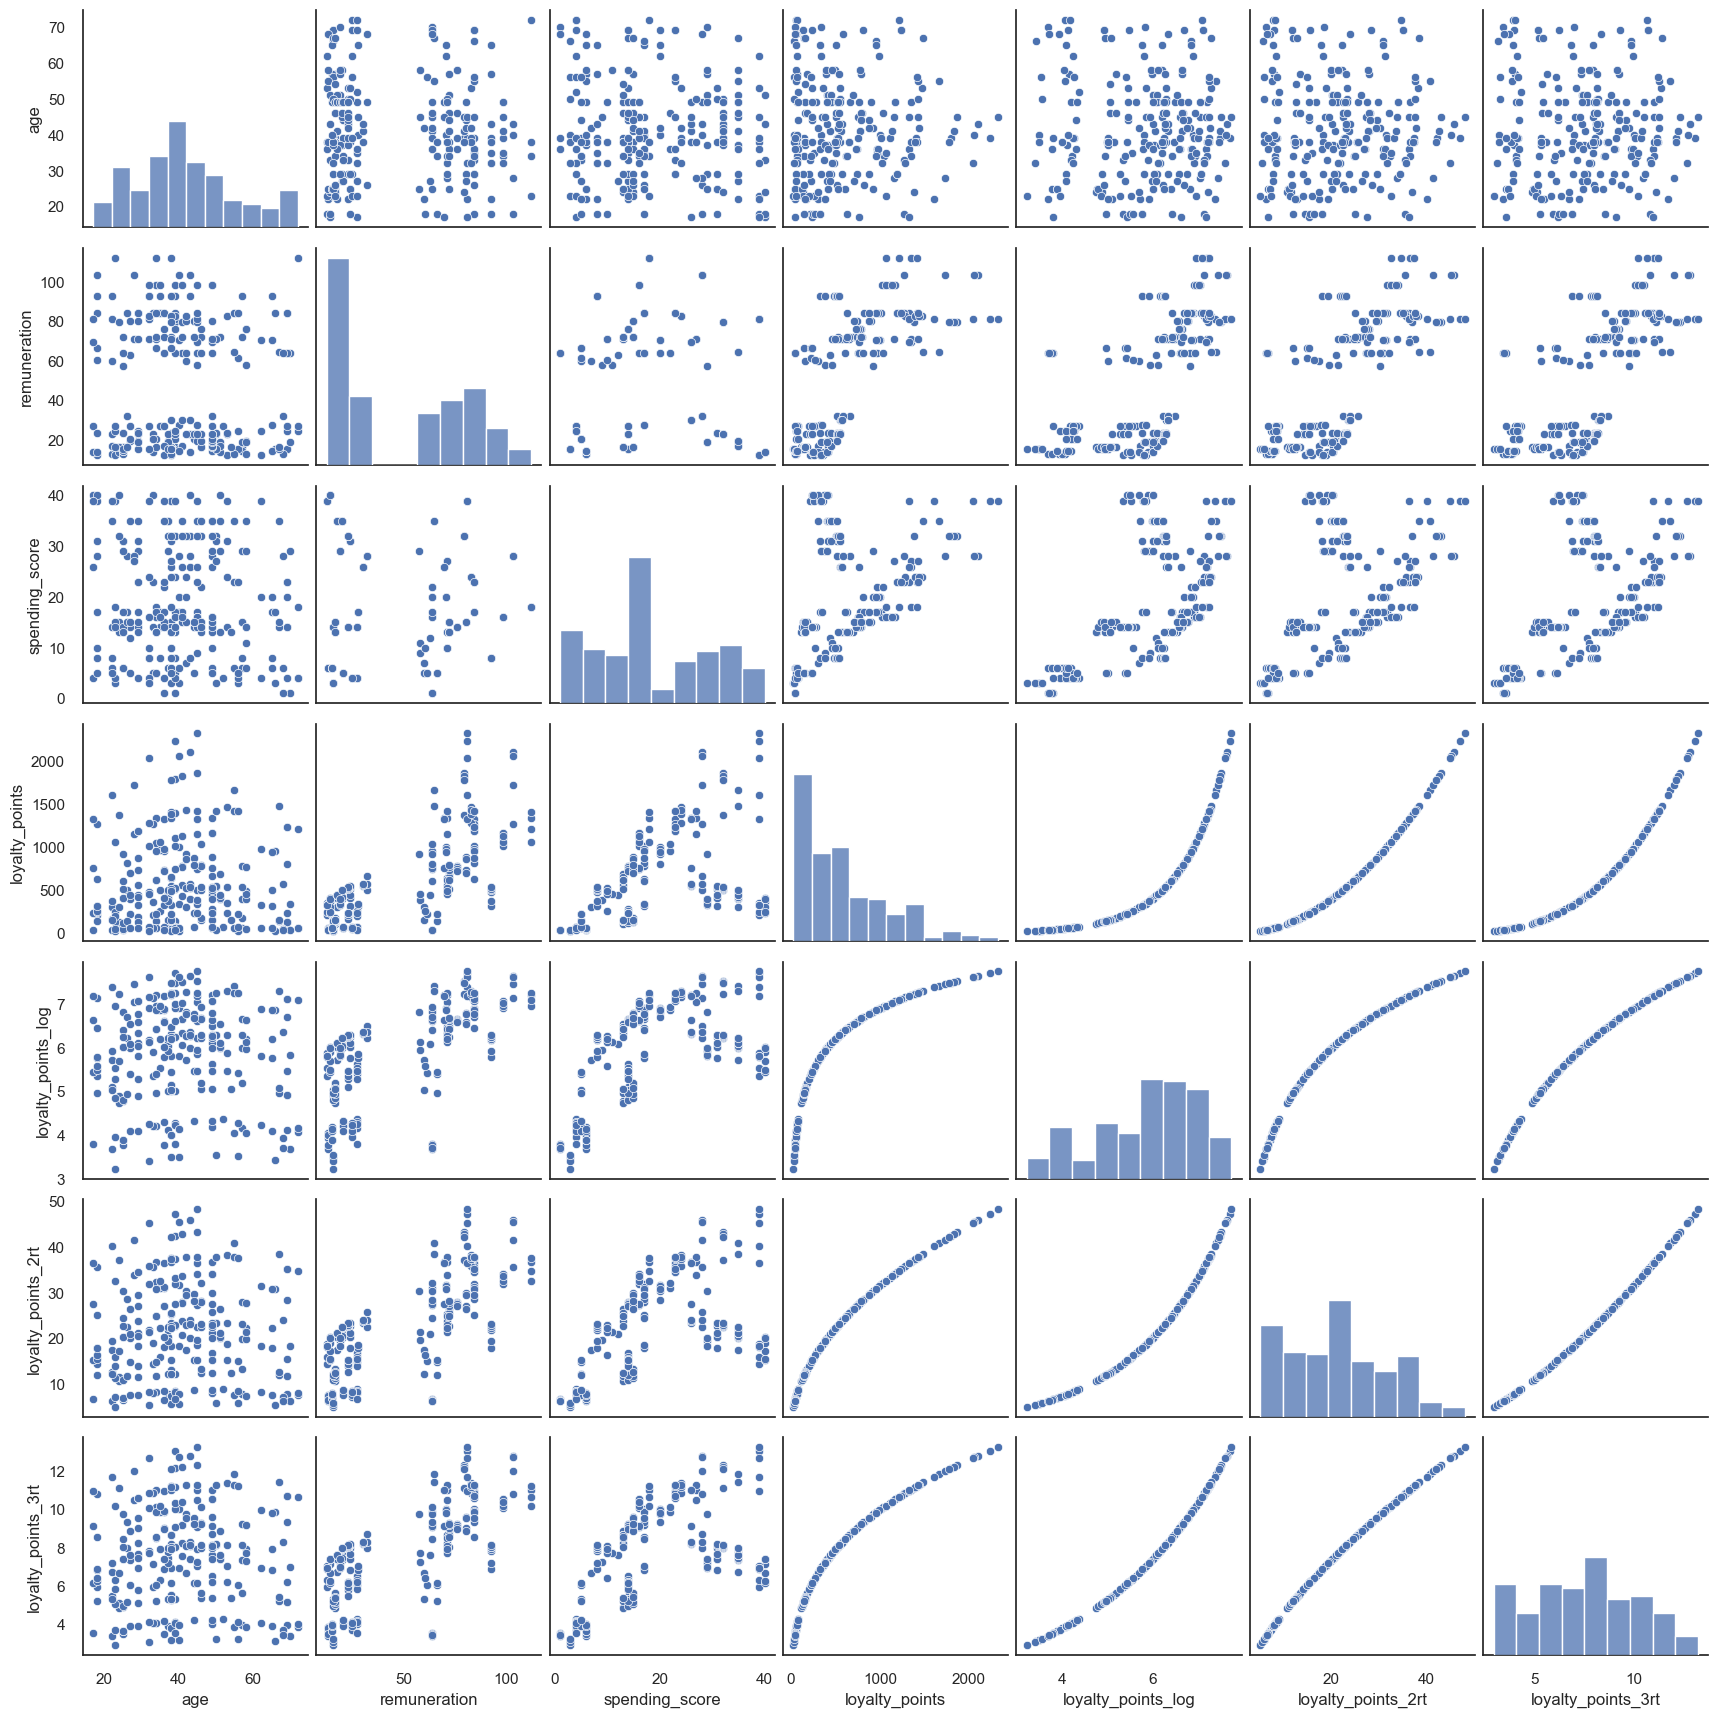

In [456]:
# visualise the distributions & relationships beetween numeric variables   
sns.pairplot(customers_full_ss_low)

Transformations slightly improve the normality of loyalty points distribution (S-W stat) with no meaningful improvement in correlation coefficients

At the same time, visual exploration suggests that root transformations result in patterns with more even variance addressing inherent heteroscedasticity.

**Note:** The assumption of linearity is not fully met. 

**Decision:** Apply cube-root transformation to loyalty_points

In [458]:
# drop redundant columns
customers_full_ss_low.drop(columns = ['loyalty_points_log', 'loyalty_points_2rt'], inplace=True)


**Decision:** continue with X = remuneration & spending_score and Y = loyalty points cube-root

#### Create and fit the model

In [461]:
# define variables
y_tr = customers_full_ss_low['loyalty_points_3rt'] 
y = customers_full_ss_low['loyalty_points'] 
X = customers_full_ss_low[['remuneration', 'spending_score']]

Recognising the relatively large dataset size of 782 observations, allocated 0.8 to the train set. The random_state parameter of 42 is used for reproducibility.

In [463]:
#Split the data in 'train' (80%) and 'test' (20%) sets.
X_train, X_test, Y_tr_train, Y_tr_test, Y_obs_train, Y_obs_test = sklearn.model_selection.train_test_split(X, y_tr, y,
                                                                            test_size = 0.20,
                                                                            random_state = 42)

# view the underlying shape of the train and test data sets 
print(Y_tr_train.describe(), Y_tr_test.describe())

count   200.000000
mean      7.611848
std       2.616243
min       2.924018
25%       5.394691
50%       7.646027
75%       9.769582
max      13.247715
Name: loyalty_points_3rt, dtype: float64 count   51.000000
mean     7.308858
std      2.324268
min      3.141381
25%      5.303886
50%      7.824294
75%      8.876428
max     12.224924
Name: loyalty_points_3rt, dtype: float64


Central tendency stats are comparable - no issues 

Used the statsmodels ols method to create and fit linear regression model 

In [466]:
# Create & fit the model
mlr_model = sm.OLS(Y_tr_train, sm.add_constant(X_train)).fit()

#  print summary of metrics
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:     loyalty_points_3rt   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     1101.
Date:                Wed, 22 Jan 2025   Prob (F-statistic):          1.15e-107
Time:                        13:42:52   Log-Likelihood:                -225.65
No. Observations:                 200   AIC:                             457.3
Df Residuals:                     197   BIC:                             467.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.0526      0.132     15.

Observation: 

- All features are significant with p< 0.05 and explain 91.8% of the variability in the **transformed** dependent variable
- The independent variables' coefficients have expected signs, but are not interpretable for the transformation applied


Decision:

Continue with the model - prepare a summary of linear regression assumptions & analyse them, assess accuracy and test how the model generalises on unseen data 

In [468]:
# Predict the training set values
Y_tr_train_pred = mlr_model.predict(sm.add_constant(X_train)) 

# apply backward transformation 
Y_train_pred = Y_tr_train_pred.apply(lambda x: math.pow(x, 3))

# Predict the test set values
Y_tr_test_pred = mlr_model.predict(sm.add_constant(X_test)) 

# apply backward transformation 
Y_test_pred = Y_tr_test_pred.apply(lambda x: math.pow(x, 3))

#### Check linear regression assumptions

Accept the significance level (alpha) of 0.05

In [471]:
# view model statistics 
LR_stat_summary = LR_stat_summary.merge(LR_statistics(mlr_model, X_train, 'MLR_1'), how='outer', left_index=True, right_index=True)
LR_stat_summary

MLR_all LR_3_rem    MLR_2    MLR_1
Durbin-Watson statistic (1.5-2.5) 1.933877 2.298320 1.982308 1.805602
F statistic p-value (< 0.05)      0.000000 0.000000 0.000000 0.000000
JB Probability (> 0.05)           0.000000 0.192341 0.000000 0.000000
LM Test p-value (> 0.05)          0.578577 0.165024 0.126928 0.291067
Resid. vs age corr                     NaN      NaN     0.00      NaN
Resid. vs remuneration corr          -0.00    -0.00    -0.00    -0.00
Resid. vs spending_score corr        -0.00      NaN    -0.00     0.00
VIF Factor: age (<10)                  NaN      NaN 1.000956      NaN
VIF Factor: remuneration (<10)    1.000195 1.000000 1.042453 1.000360
VIF Factor: spending_score (<10)  1.000195      NaN 1.041482 1.000360

F-statistic p-value < 0.05 indicates that the regression model is statistically significant.

LR assumptions are satisfied except for the optional Normality of error terms (optional); JB probability < 0.05 suggests that the residuals significantly deviate from normality. This is supported by the "Residuals Q-Q plot" below.

##### Residuals vs. X-Variable(s) Plot (linearity assumption)

Residuals vs. X-Variable(s) Plot checks the linearity assumption for each predictor individually. It shows the relationship between residuals and each independent variable (X).


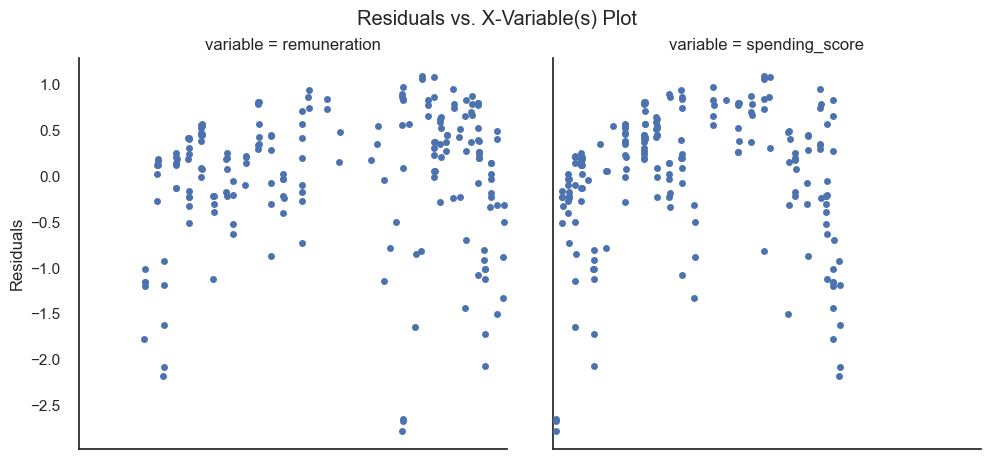

In [475]:
# prepare data for the residuals vs. X visualisation
res_plot = X_train.copy()
res_plot['Residuals'] = mlr_model.resid
res_plot = res_plot.melt(id_vars='Residuals')

# Plot the residuals versus the x-values.
g = sns.catplot(res_plot, y='Residuals', x='value', col='variable')
g.fig.suptitle("Residuals vs. X-Variable(s) Plot", y=1.02)

# Remove x-axis labels, tick labels, and tick marks for each subplot
for ax in g.axes.flat:
    ax.set_xlabel("") 
    ax.set_xticks([])
    ax.set_xticklabels([])
plt.show()

Observation: 

- No strong patterns were identified, which together with the patterns observed on pairplots and Pearson correlation coefficients suggests a strong linear relationship.

##### Residuals vs. Fitted Values Plot (linearity, homoscedasticity, autocorrelation)

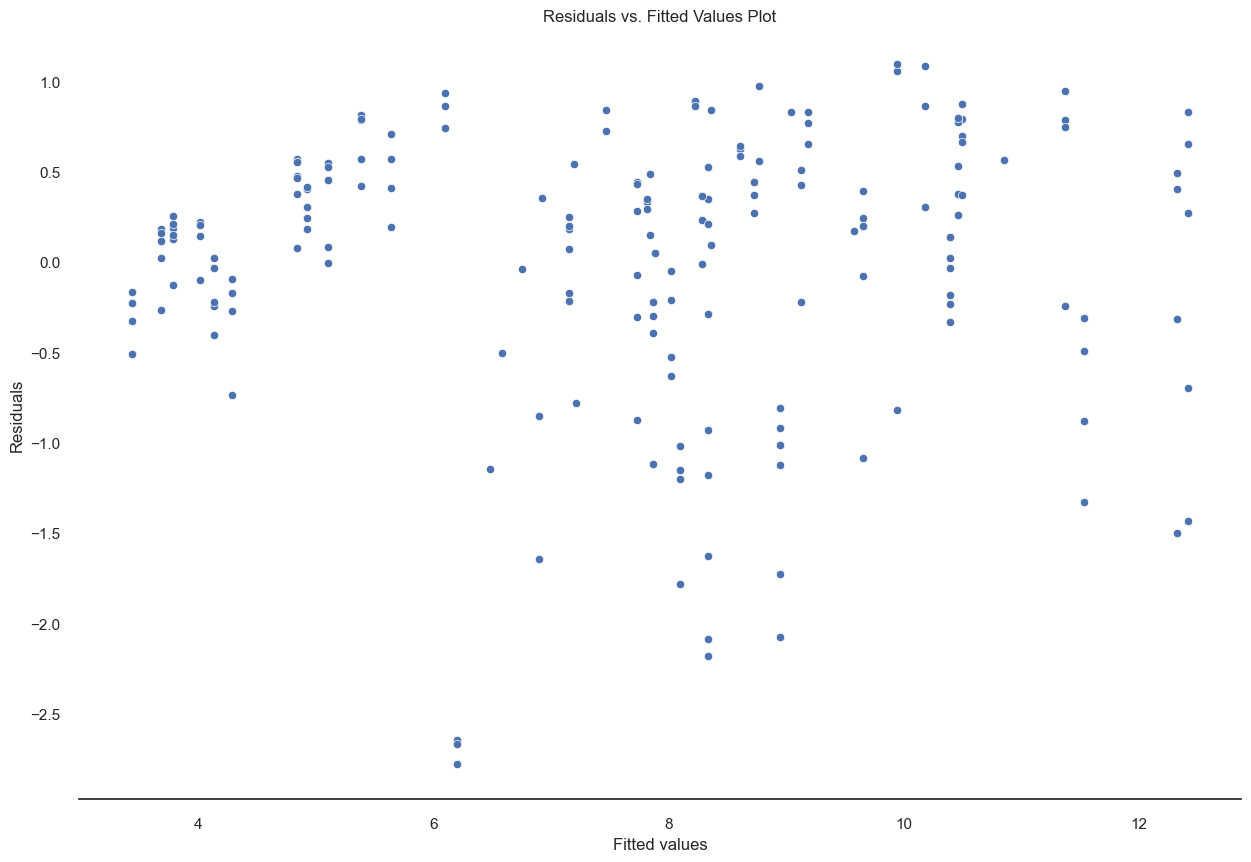

In [478]:
# Plot the residuals versus the predicted values on the train dataset.
sns.scatterplot(y = mlr_model.resid, x= Y_tr_train_pred)
plt.ylabel("Residuals")
plt.xlabel("Fitted values")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

The scatter slightly deviates from perfect 'white noise', but no strong patterns.  

##### Residuals Q-Q plot (Normality of error terms)

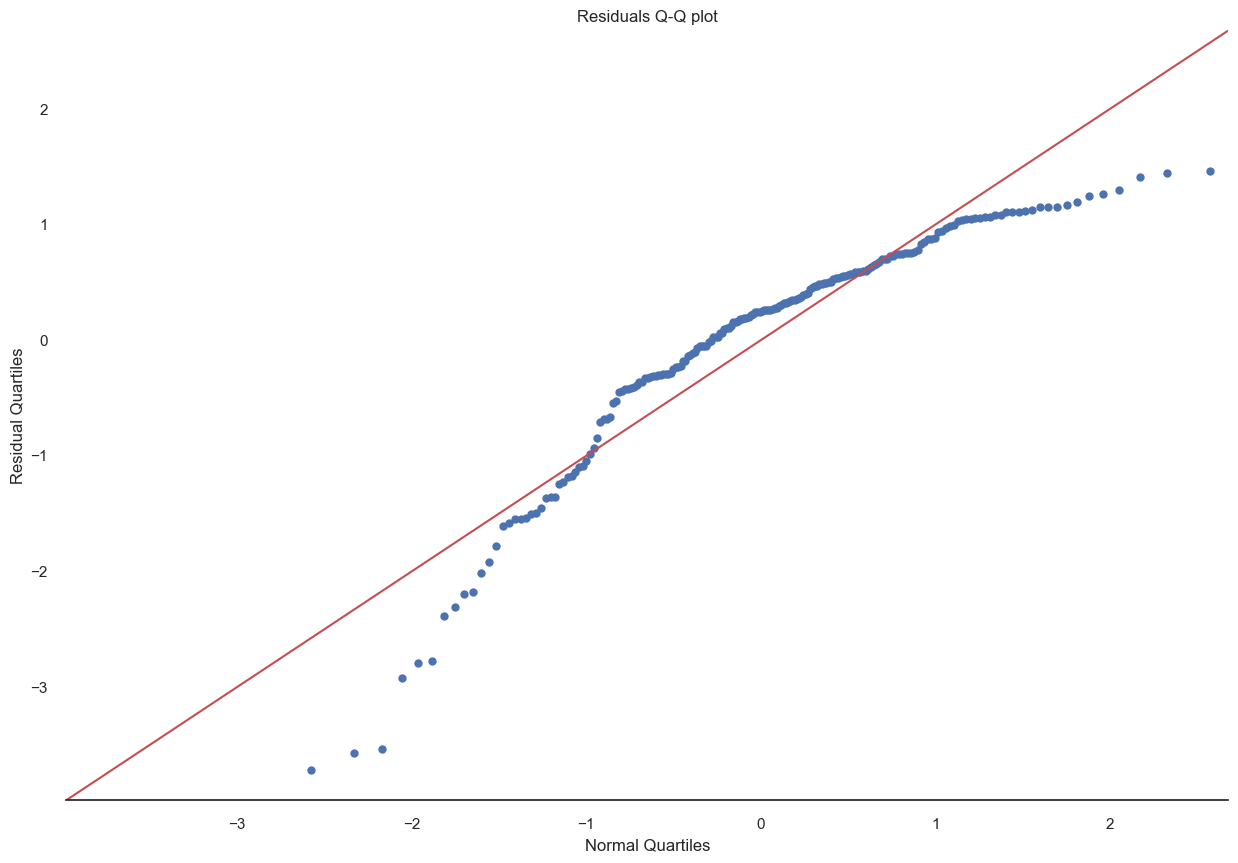

In [481]:
# Plot the quartiles of the residuals versus the quartiles of the N(0,1)
# The fit=True argument first Standardises the observed data (Residuals) before plotting them
sm.qqplot(mlr_model.resid, fit=True, line='45')
plt.ylabel("Residual Quartiles")
plt.xlabel("Normal Quartiles")
plt.title("Residuals Q-Q plot")
plt.show()

Observation: 

The optional assumption of Normality of error terms is violated.

 OLS does not require that the error term follows a normal distribution to produce unbiased estimates with the minimum variance. However, satisfying this assumption allows you to perform statistical hypothesis testing and generate reliable confidence intervals and prediction intervals.

#### Assess accuracy & test how the model generalises on unseen data 

Calculate and analyse goodness-of-fit measures:
- On the trainind dataset to evaluate the model's capacity to learn from the data. Helps identify underfitting (e.g., high training error or low R2).
- On the Test Dataset to assess how well the model generalises to unseen data.  Helps identify overfitting (e.g., much better metrics on training data than on test data).


In [485]:
# summarise goodness of fit measures for train dataset 
MLR_gof_summary = goodness_of_fit(Y_obs_train, Y_train_pred,  mlr_model, 'MLR_1_train')

# add GOF for test dataset 
MLR_gof_summary = MLR_gof_summary.merge(goodness_of_fit(Y_obs_test, Y_test_pred,  mlr_model, 'MLR_1_test'), left_index=True, right_index=True)

# print the summary
MLR_gof_summary

MLR_1_train  MLR_1_test
R2                  0.902000    0.899409
R2 (train)          0.917904    0.917904
Adj. R2 (train)     0.917070    0.917070
RMSE              164.178589  128.713884
MAE               115.709054   83.708104
MAPE, %            21.780194   16.627255
q1 (y_real)       157.000000  149.500000
q3 (y_real)       932.500000  700.000000
mean (y_real)     597.525000  505.098039

Observation: 

FAIR FOR BOTH TRAIN & TEST

- The R-squared is strong and explains slightly c.90% of the dependent variable (both on train & test).
- MAE & RMSE are smaller than the mean value of Y with MAPE 21 - 16%
- The difference between RMSE and MAE is moderate/small, which suggests that the model's prediction errors are relatively consistent and that there are few extreme outliers.


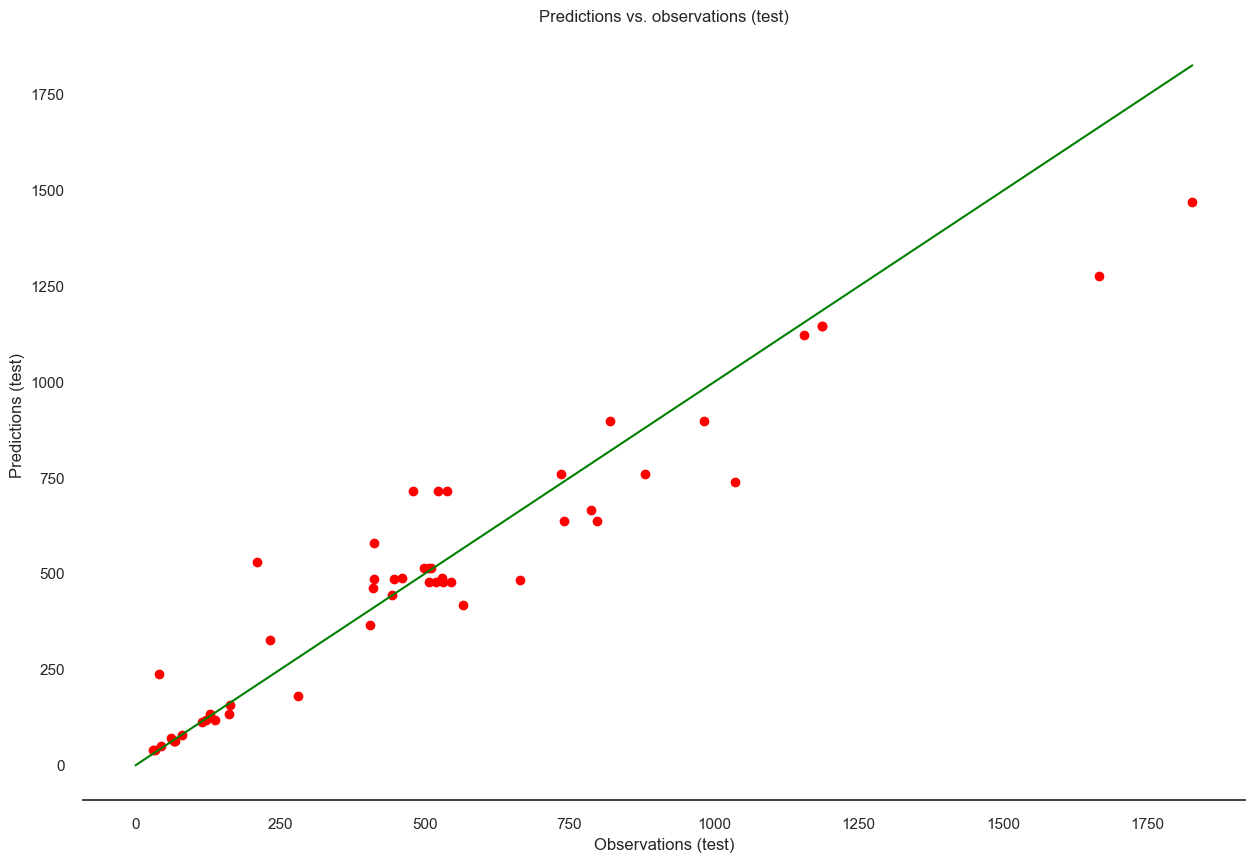

In [487]:
# Plot Predictions (y) vs. observations (x) on the test dataset
X_var = Y_obs_test
Y_var = Y_test_pred

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_var, Y_var, color='red')

# Add a diagonal line
plt.plot([0, X_var.max()], [0, X_var.max()], color='green')

# Labeling the axes
ax.set_xlabel('Observations (test)')
ax.set_ylabel('Predictions (test)')
ax.set_title('Predictions vs. observations (test)')

plt.show()

Supports the observations above

In [489]:
# update and print the goodness of fit summary
gof_summary = gof_summary.merge(MLR_gof_summary['MLR_1_test'], left_index=True, right_index=True)

# view 
gof_summary

DT_prunned_test DT_fin_test    MLR_test  LR_3_rem_test  \
R2                     0.908051    0.902689    0.906427       0.869809   
R2 (train)                 None        None    0.891825       0.932260   
Adj. R2 (train)            None        None    0.891478       0.931914   
RMSE                 390.108166  401.321993  393.538048     717.926025   
MAE                  274.656903  296.629368  318.451350     537.882979   
MAPE, %               23.133588   27.254099   26.413167      19.523268   
q1 (y_real)          777.000000  777.000000  777.000000    1010.250000   
q3 (y_real)         1686.000000 1686.000000 1686.000000    4798.750000   
mean (y_real)       1529.000000 1529.000000 1529.000000    2867.920000   

                 MLR_2_test  MLR_1_test  
R2                 0.724945    0.899409  
R2 (train)         0.767631    0.917904  
Adj. R2 (train)    0.764491    0.917070  
RMSE             163.907850  128.713884  
MAE              135.886796   83.708104  
MAPE, %            9.783861   16.627255  
q1 (y_real)     1215.000000  149.500000  
q3 (y_real)     1592.000000  700.000000  
mean (y_real)   1389.087719  505.098039

### 5 MLR_2 (square-root; remuneration & spending_score): spending_score_cat=2 (cluster 3)

In [491]:
# view the dataset
# drop redundant columns
customers_full__ss_avg.drop(columns = ['loyalty_points_2rt'], inplace=True)
customers_full__ss_avg.head()

customer_ID  gender  age  remuneration  spending_score  loyalty_points  \
378           0  Female   33     32.800000              42             904   
379           2  Female   50     36.080000              50            1338   
380           3  Female   38     49.200000              40            1376   
381           4  Female   36     47.560000              60            1951   
382           5  Female   49     44.280000              42            1379   

        education age_group cluster predicted_class remuneration_cat  \
378      Graduate     30-40       3               3                2   
379  Postgraduate     40-50       3               3                2   
380           PhD     30-40       3               3                2   
381           PhD     30-40       3               3                2   
382      Graduate     40-50       3               3                2   

    spending_score_cat remuneration_gr  
378                  2           30-40  
379                  2           30-40  
380                  2           40-50  
381                  2           40-50  
382                  2           40-50

In [492]:
customers_full__ss_avg.shape

(283, 13)

#### Evaluate relationships between features

To evaluate possible linear relationships between features and loyalty point balances we visualised relationships between features and loyalty point balances using sns.pairplot(), analysed descriptive statistics and Pearson correlation coefficients.

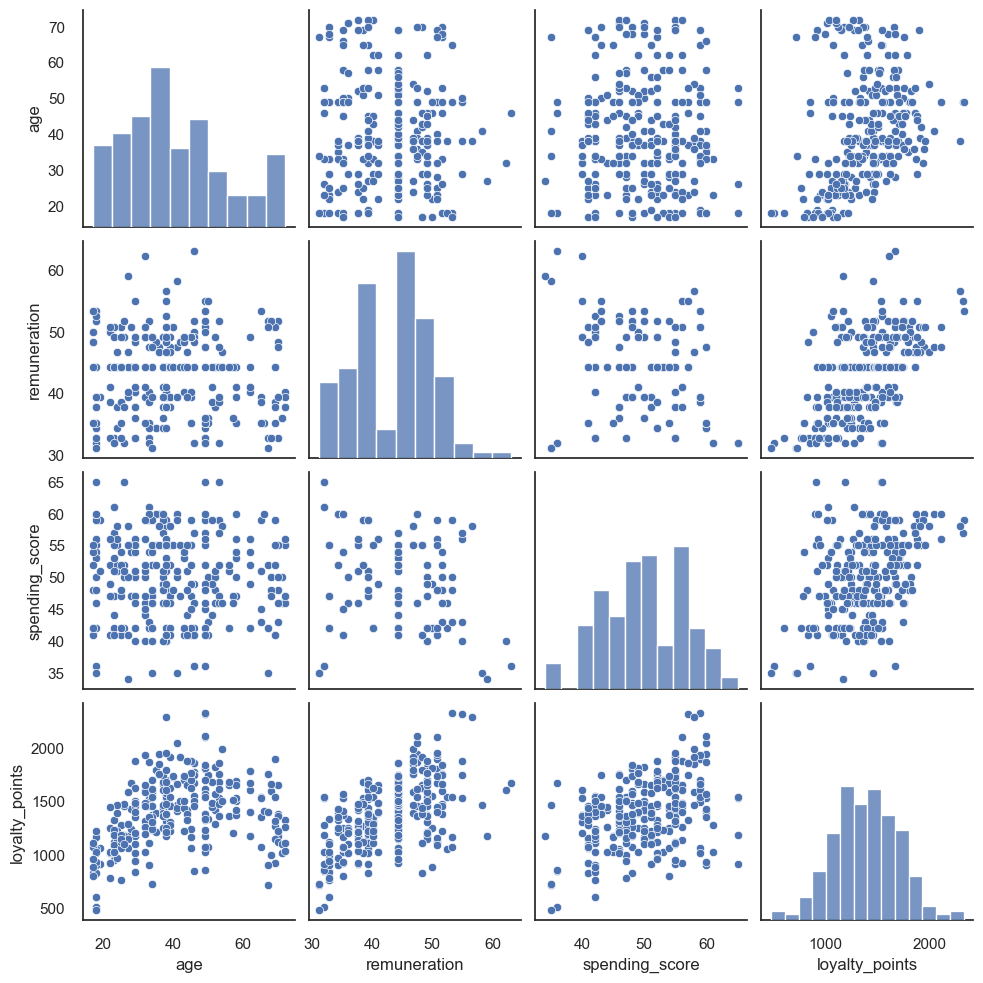

In [495]:
# visualise the distributions & relationships beetween numeric variables   
sns.pairplot(customers_full__ss_avg)

In [496]:
# calculate descriptive statistics for df
customers_desc_stat = desc_stat_summary(customers_full__ss_avg)
customers_desc_stat

age  remuneration  spending_score  \
count                         283.000000    283.000000      283.000000   
mean                           40.310954     42.947138       49.893993   
std                            14.664164      6.497970        6.579255   
min                            17.000000     31.160000       34.000000   
25%                            29.000000     37.720000       46.000000   
50%                            38.000000     44.280000       50.000000   
75%                            49.000000     48.380000       55.000000   
max                            72.000000     63.140000       65.000000   
range                          55.000000     31.980000       31.000000   
IQR                            20.000000     10.660000        9.000000   
skewness (n=0)                  0.462103      0.151877       -0.104848   
kurtosis (n=3)                  2.442123      2.486520        2.350634   
Shapiro-Wilk, stat (n=1)        0.956272      0.969325        0.978556   
Shapiro-Wilk, p-value (>0.05)   0.000000      0.000010        0.000296   

                               loyalty_points  
count                              283.000000  
mean                              1389.890459  
std                                318.982767  
min                                478.000000  
25%                               1176.000000  
50%                               1395.000000  
75%                               1619.500000  
max                               2332.000000  
range                             1854.000000  
IQR                                443.500000  
skewness (n=0)                       0.036918  
kurtosis (n=3)                       3.047252  
Shapiro-Wilk, stat (n=1)             0.996618  
Shapiro-Wilk, p-value (>0.05)        0.812760

Distribution: 

- loyalty_points: are normally distributed with SW stat of 0.99; mesokurtic symmetrical distribution (skewness of 0 and kurtosis of 3).  
- remuneration & spending_score: symmetrical distributions, slightly heavy-tailed but reasonably close to normal distribution. 
- age: slightly deviates from normality (slight right-skew and flatter than normal)


**Action:** Evaluate potential effect of loyalty points transformation to address heteroscedasticity 

In [499]:
# Pearson correlation to evaluate linear relationships
customers_full__ss_avg.corr(method='pearson', numeric_only=True)

age  remuneration  spending_score  loyalty_points
age             1.000000     -0.045529       -0.045160        0.318068
remuneration   -0.045529      1.000000       -0.165671        0.576787
spending_score -0.045160     -0.165671        1.000000        0.428491
loyalty_points  0.318068      0.576787        0.428491        1.000000

The Pearson correlation coefficient of 0.57 indicates a moderate positive correlation in the 'remuneration ¬ loyalty points'

'spending score ¬ loyalty points' and 'Age¬loyalty_points' pairs have weak coefficients of 42.8% and 31.8 respectively.

Test: 
- X = remuneration & spending_score and Y = loyalty points_square-root (exclude age for non-linearity and add transformation for heteroscedasticity)

In [501]:
# Spearman rank correlation to capture possible non-linear but monotonic relationships (e.g. exponential, logarithmic)
customers_full__ss_avg.corr(method='spearman', numeric_only=True)

age  remuneration  spending_score  loyalty_points
age             1.000000     -0.027703       -0.057088        0.397038
remuneration   -0.027703      1.000000       -0.149405        0.558502
spending_score -0.057088     -0.149405        1.000000        0.410911
loyalty_points  0.397038      0.558502        0.410911        1.000000

Spearman rank correlation coefficients suggest that non-linear models are worth testing and can potentially perform stronger.

Test log and square-root transformation to address heteroscedasticity

In [504]:
# apply log, square-root and cube-root transformation to y
customers_full__ss_avg.loc[:, 'loyalty_points_log'] = customers_full__ss_avg['loyalty_points'].apply(lambda x: np.log(x))
customers_full__ss_avg.loc[:, 'loyalty_points_2rt'] = customers_full__ss_avg['loyalty_points'].apply(lambda x: math.sqrt(x))
customers_full__ss_avg.loc[:, 'loyalty_points_3rt'] = customers_full__ss_avg['loyalty_points'].apply(lambda x: math.pow(x, 1/3))

# calculate descriptive statistics for customers df
customers_desc_stat = desc_stat_summary(customers_full__ss_avg)
customers_desc_stat

age  remuneration  spending_score  \
count                         283.000000    283.000000      283.000000   
mean                           40.310954     42.947138       49.893993   
std                            14.664164      6.497970        6.579255   
min                            17.000000     31.160000       34.000000   
25%                            29.000000     37.720000       46.000000   
50%                            38.000000     44.280000       50.000000   
75%                            49.000000     48.380000       55.000000   
max                            72.000000     63.140000       65.000000   
range                          55.000000     31.980000       31.000000   
IQR                            20.000000     10.660000        9.000000   
skewness (n=0)                  0.462103      0.151877       -0.104848   
kurtosis (n=3)                  2.442123      2.486520        2.350634   
Shapiro-Wilk, stat (n=1)        0.956272      0.969325        0.978556   
Shapiro-Wilk, p-value (>0.05)   0.000000      0.000010        0.000296   

                               loyalty_points  loyalty_points_log  \
count                              283.000000          283.000000   
mean                              1389.890459            7.208402   
std                                318.982767            0.247010   
min                                478.000000            6.169611   
25%                               1176.000000            7.069874   
50%                               1395.000000            7.240650   
75%                               1619.500000            7.389872   
max                               2332.000000            7.754482   
range                             1854.000000            1.584871   
IQR                                443.500000            0.319998   
skewness (n=0)                       0.036918           -0.806980   
kurtosis (n=3)                       3.047252            4.398668   
Shapiro-Wilk, stat (n=1)             0.996618            0.965371   
Shapiro-Wilk, p-value (>0.05)        0.812760            0.000003   

                               loyalty_points_2rt  loyalty_points_3rt  
count                                  283.000000          283.000000  
mean                                    37.023824           11.090693  
std                                      4.381182            0.886196  
min                                     21.863211            7.818846  
25%                                     34.292853           10.555263  
50%                                     37.349699           11.173556  
75%                                     40.243000           11.743391  
max                                     48.290786           13.260997  
range                                   26.427575            5.442152  
IQR                                      5.950147            1.188128  
skewness (n=0)                          -0.350095           -0.492351  
kurtosis (n=3)                           3.333056            3.581760  
Shapiro-Wilk, stat (n=1)                 0.990215            0.984169  
Shapiro-Wilk, p-value (>0.05)            0.054947            0.003217

In [505]:
# Pearson correlation to evaluate linear relationships
customers_full__ss_avg.corr(method='pearson', numeric_only=True)

age  remuneration  spending_score  loyalty_points  \
age                 1.000000     -0.045529       -0.045160        0.318068   
remuneration       -0.045529      1.000000       -0.165671        0.576787   
spending_score     -0.045160     -0.165671        1.000000        0.428491   
loyalty_points      0.318068      0.576787        0.428491        1.000000   
loyalty_points_log  0.333694      0.573348        0.424942        0.982700   
loyalty_points_2rt  0.327365      0.577527        0.427699        0.996004   
loyalty_points_3rt  0.329853      0.576747        0.427024        0.992709   

                    loyalty_points_log  loyalty_points_2rt  loyalty_points_3rt  
age                           0.333694            0.327365            0.329853  
remuneration                  0.573348            0.577527            0.576747  
spending_score                0.424942            0.427699            0.427024  
loyalty_points                0.982700            0.996004            0.992709  
loyalty_points_log            1.000000            0.995256            0.997823  
loyalty_points_2rt            0.995256            1.000000            0.999503  
loyalty_points_3rt            0.997823            0.999503            1.000000

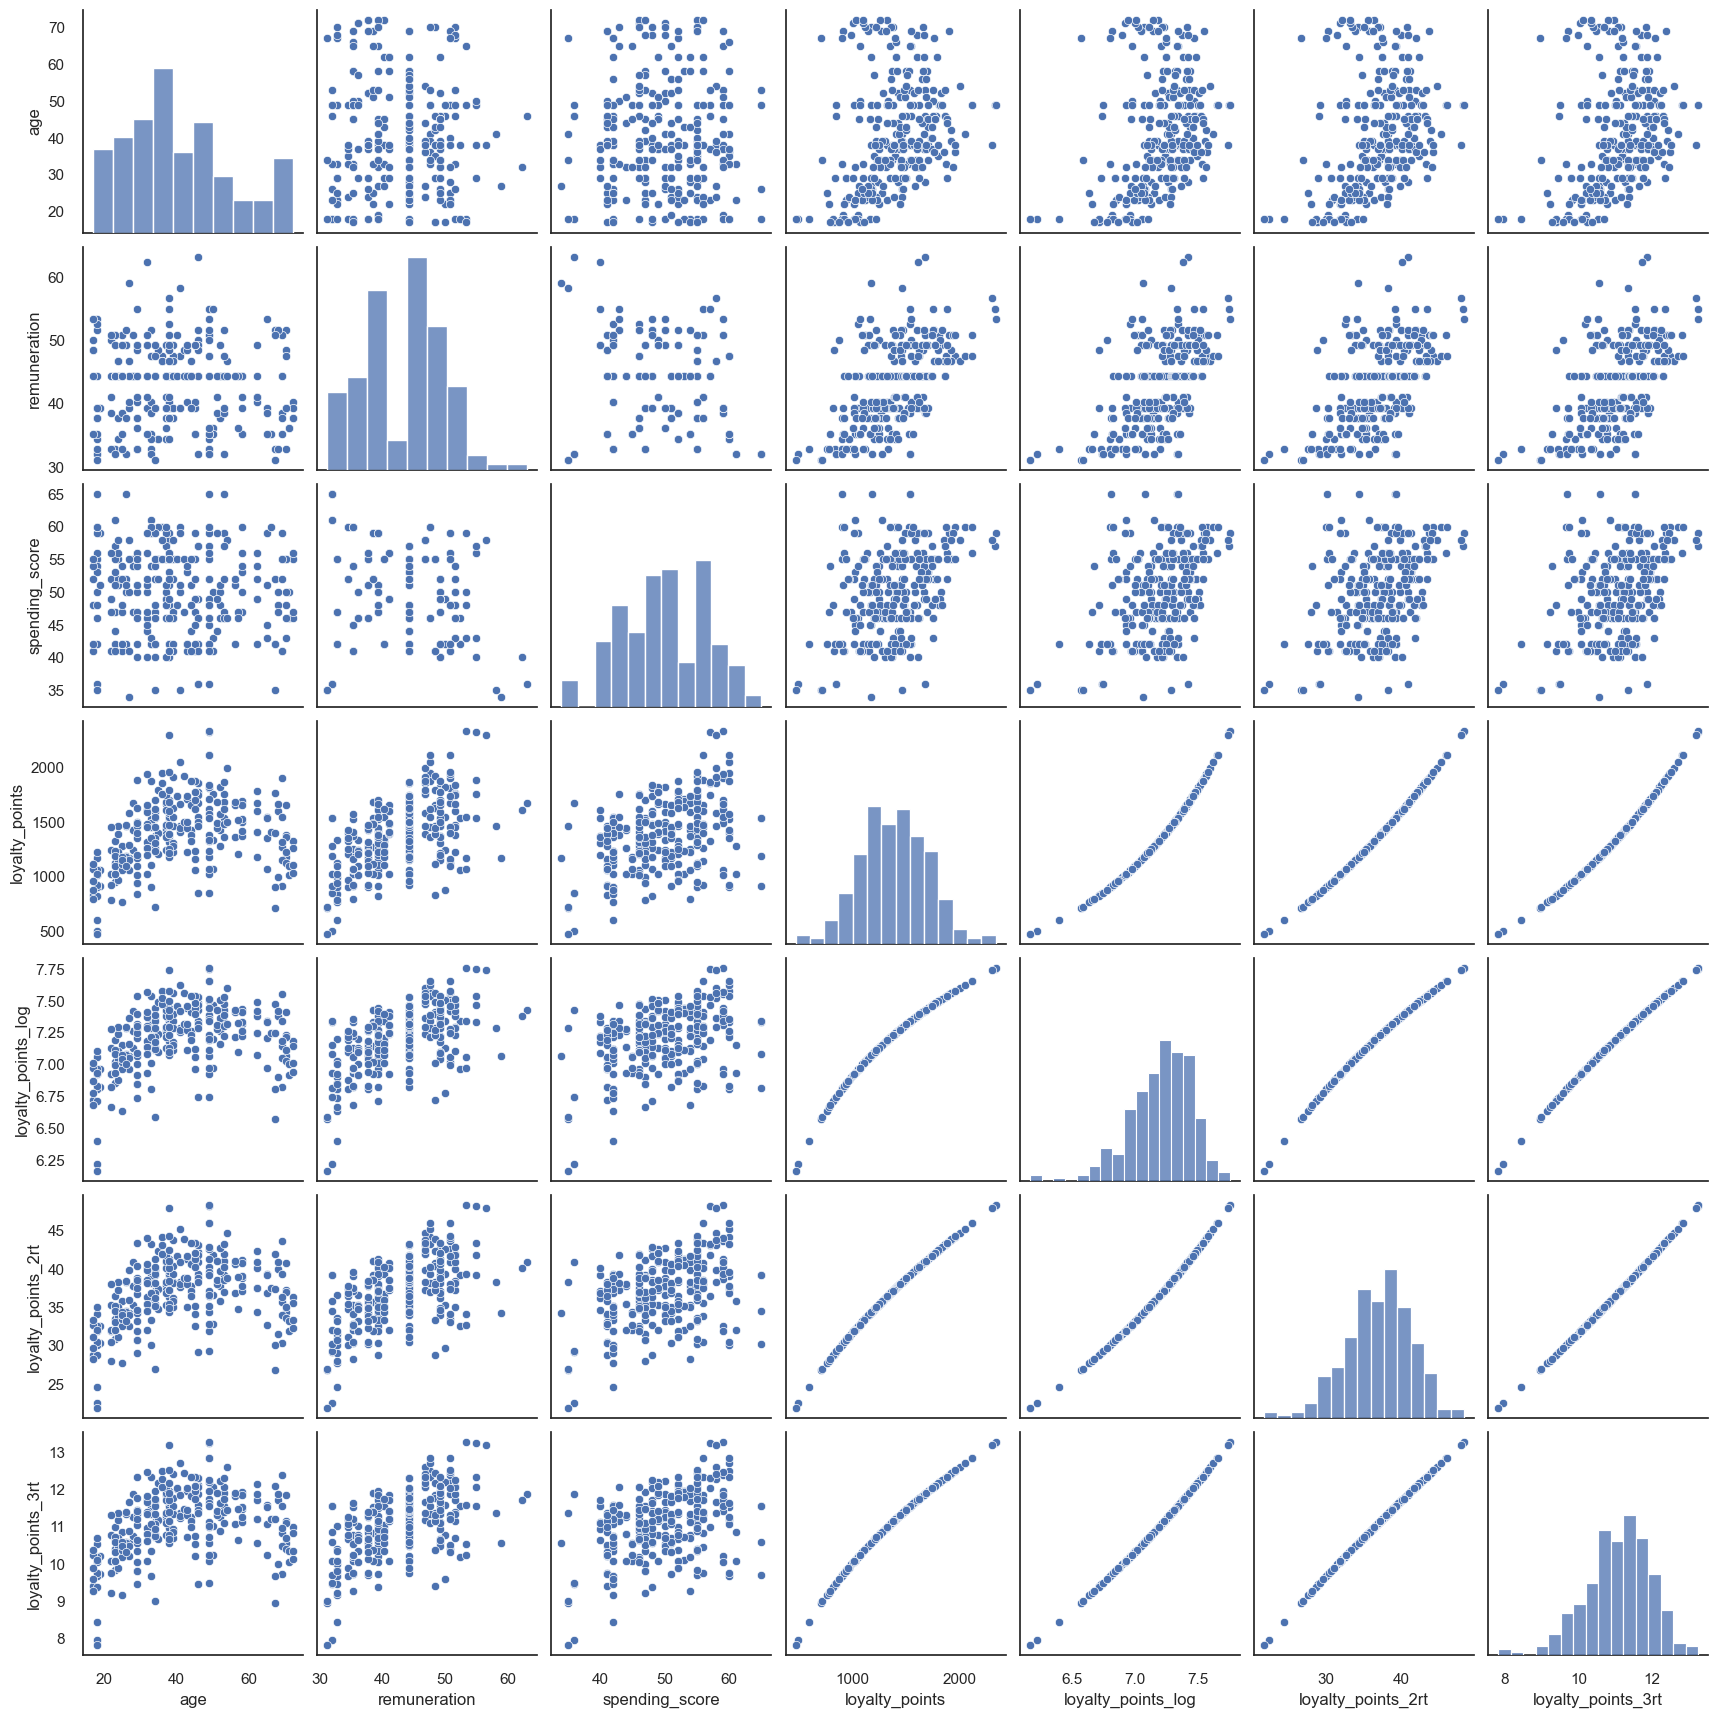

In [506]:
# visualise the distributions & relationships beetween numeric variables   
sns.pairplot(customers_full__ss_avg)

Transformations slightly improve the normality of loyalty points distribution (S-W stat) with no meaningful improvement in correlation coefficients

At the same time, visual exploration suggests that root transformations result in patterns with more even variance addressing inherent heteroscedasticity.

**Note:** The assumption of linearity is not fully met. 

**Decision:** Apply cube-root transformation to loyalty_points

In [508]:
# drop redundant columns
customers_full__ss_avg.drop(columns = ['loyalty_points_log', 'loyalty_points_3rt'], inplace=True)

Observation:

The most significant features are remuneration and spending_score

**Decision:** continue with X = remuneration & spending_score and Y = loyalty points 2nd root

#### Create and fit the model

In [511]:
# define variables
y_tr = customers_full__ss_avg['loyalty_points_2rt'] 
y = customers_full__ss_avg['loyalty_points'] 
X = customers_full__ss_avg[['remuneration', 'spending_score']]

Recognising the relatively large dataset size of 782 observations, allocated 0.8 to the train set. The random_state parameter of 42 is used for reproducibility.

In [513]:
#Split the data in 'train' (80%) and 'test' (20%) sets.
X_train, X_test, Y_tr_train, Y_tr_test, Y_obs_train, Y_obs_test = sklearn.model_selection.train_test_split(X, y_tr, y,
                                                                            test_size = 0.20,
                                                                            random_state = 42)

# view the underlying shape of the train and test data sets 
print(Y_tr_train.describe(), Y_tr_test.describe())

count   226.000000
mean     37.025419
std       4.392797
min      21.863211
25%      34.186957
50%      37.536649
75%      40.274061
max      48.290786
Name: loyalty_points_2rt, dtype: float64 count   57.000000
mean    37.017500
std      4.373559
min     22.449944
25%     34.856850
50%     37.242449
75%     39.899875
max     45.254834
Name: loyalty_points_2rt, dtype: float64


Central tendency stats are comparable - no issues 

Used the statsmodels ols method to create and fit linear regression model 

In [516]:
# Create & fit the model
mlr_model = sm.OLS(Y_tr_train, sm.add_constant(X_train)).fit()

MLR_2_remss = mlr_model

#  print summary of metrics
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:     loyalty_points_2rt   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     178.1
Date:                Wed, 22 Jan 2025   Prob (F-statistic):           6.10e-47
Time:                        13:43:10   Log-Likelihood:                -546.81
No. Observations:                 226   AIC:                             1100.
Df Residuals:                     223   BIC:                             1110.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4373      2.029     -0.

Observation: 

- All features are significant with p< 0.05 and explain 61.5% of the variability in the **transformed** dependent variable
- The independent variables' coefficients have expected signs, but are not interpretable for the transformation applied


Decision:

Continue with the model - prepare a summary of linear regression assumptions & analyse them, assess accuracy and test how the model generalises on unseen data 

In [518]:
# Predict the training set values
Y_tr_train_pred = mlr_model.predict(sm.add_constant(X_train)) 

# apply backward transformation 
Y_train_pred = Y_tr_train_pred.apply(lambda x: math.pow(x, 2))

# Predict the test set values
Y_tr_test_pred = mlr_model.predict(sm.add_constant(X_test)) 

# apply backward transformation 
Y_test_pred = Y_tr_test_pred.apply(lambda x: math.pow(x, 2))

#### Check linear regression assumptions

Accept the significance level (alpha) of 0.05

In [521]:
# view model statistics 
LR_stat_summary = LR_stat_summary.merge(LR_statistics(mlr_model, X_train, 'MLR_2_remss'), how='outer', left_index=True, right_index=True)
LR_stat_summary

MLR_all LR_3_rem    MLR_2    MLR_1  \
Durbin-Watson statistic (1.5-2.5) 1.933877 2.298320 1.982308 1.805602   
F statistic p-value (< 0.05)      0.000000 0.000000 0.000000 0.000000   
JB Probability (> 0.05)           0.000000 0.192341 0.000000 0.000000   
LM Test p-value (> 0.05)          0.578577 0.165024 0.126928 0.291067   
Resid. vs age corr                     NaN      NaN     0.00      NaN   
Resid. vs remuneration corr          -0.00    -0.00    -0.00    -0.00   
Resid. vs spending_score corr        -0.00      NaN    -0.00     0.00   
VIF Factor: age (<10)                  NaN      NaN 1.000956      NaN   
VIF Factor: remuneration (<10)    1.000195 1.000000 1.042453 1.000360   
VIF Factor: spending_score (<10)  1.000195      NaN 1.041482 1.000360   

                                  MLR_2_remss  
Durbin-Watson statistic (1.5-2.5)    2.094445  
F statistic p-value (< 0.05)         0.000000  
JB Probability (> 0.05)              0.000000  
LM Test p-value (> 0.05)             0.327871  
Resid. vs age corr                        NaN  
Resid. vs remuneration corr             -0.00  
Resid. vs spending_score corr           -0.00  
VIF Factor: age (<10)                     NaN  
VIF Factor: remuneration (<10)       1.041479  
VIF Factor: spending_score (<10)     1.041479

F-statistic p-value < 0.05 indicates that the regression model is statistically significant.

LR assumptions are satisfied with the only exception - Normality of error terms (optional); JB probability < 0.05 suggests that the residuals significantly deviate from normality. This is supported by the "Residuals Q-Q plot" below.

##### Residuals vs. X-Variable(s) Plot (linearity assumption)

Residuals vs. X-Variable(s) Plot checks the linearity assumption for each predictor individually. It shows the relationship between residuals and each independent variable (X).


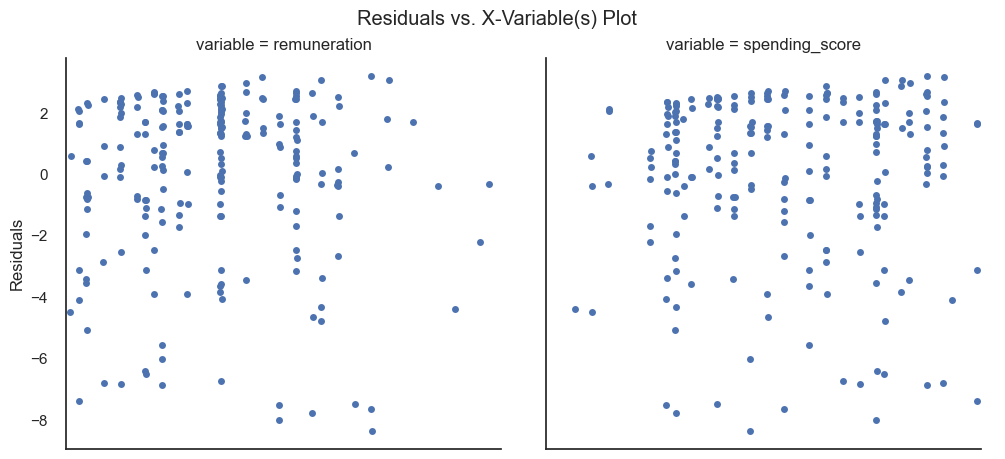

In [525]:
# prepare data for the residuals vs. X visualisation
res_plot = X_train.copy()
res_plot['Residuals'] = mlr_model.resid
res_plot = res_plot.melt(id_vars='Residuals')

# Plot the residuals versus the x-values.
g = sns.catplot(res_plot, y='Residuals', x='value', col='variable')
g.fig.suptitle("Residuals vs. X-Variable(s) Plot", y=1.02)

# Remove x-axis labels, tick labels, and tick marks for each subplot
for ax in g.axes.flat:
    ax.set_xlabel("") 
    ax.set_xticks([])
    ax.set_xticklabels([])
plt.show()

Observation: 

- No strong patterns were identified, which together with the patterns observed on pairplots and Pearson correlation coefficients suggests a moderate/strong linear relationship.

##### Residuals vs. Fitted Values Plot (linearity, homoscedasticity, autocorrelation)

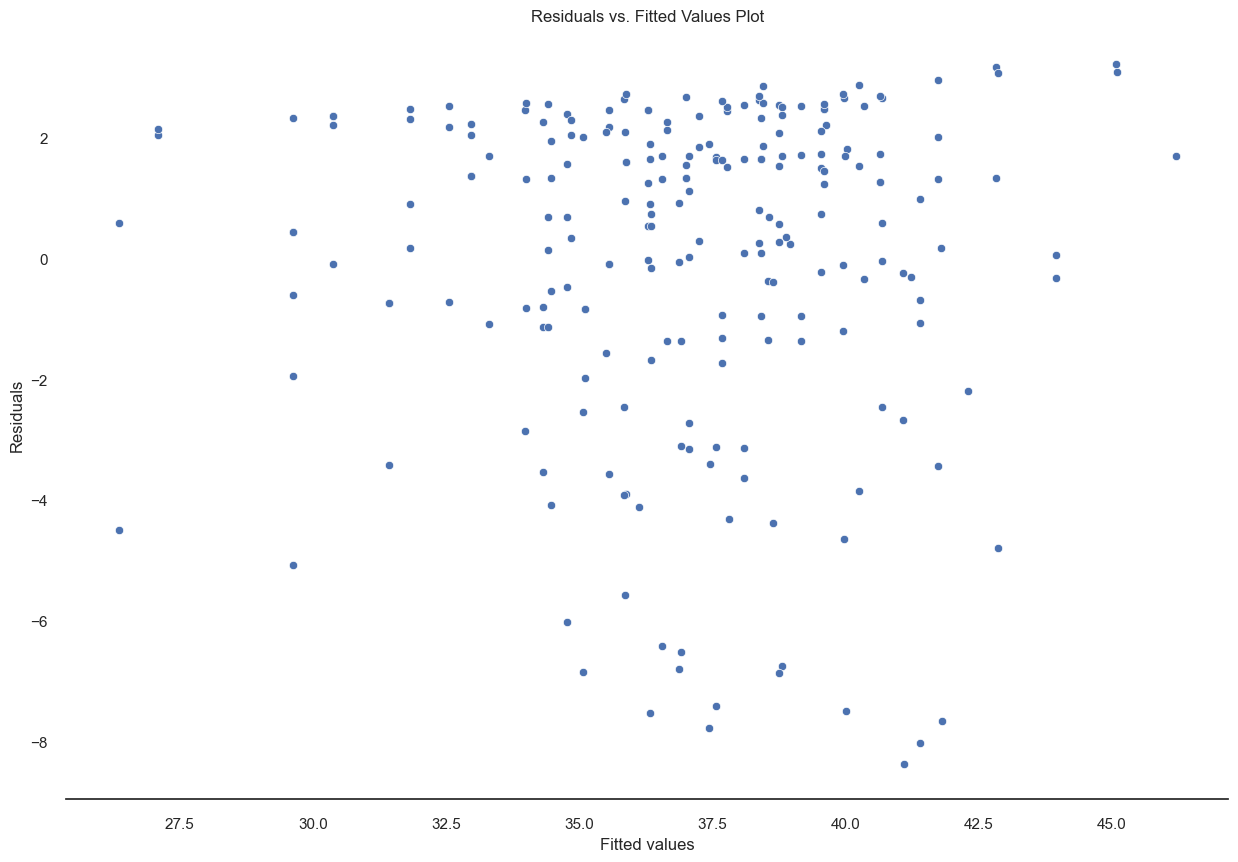

In [528]:
# Plot the residuals versus the predicted values on the train dataset.
sns.scatterplot(y = mlr_model.resid, x= Y_tr_train_pred)
plt.ylabel("Residuals")
plt.xlabel("Fitted values")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

The scatter slightly deviates from perfect 'white noise', but no strong patterns.  

##### Residuals Q-Q plot (Normality of error terms)

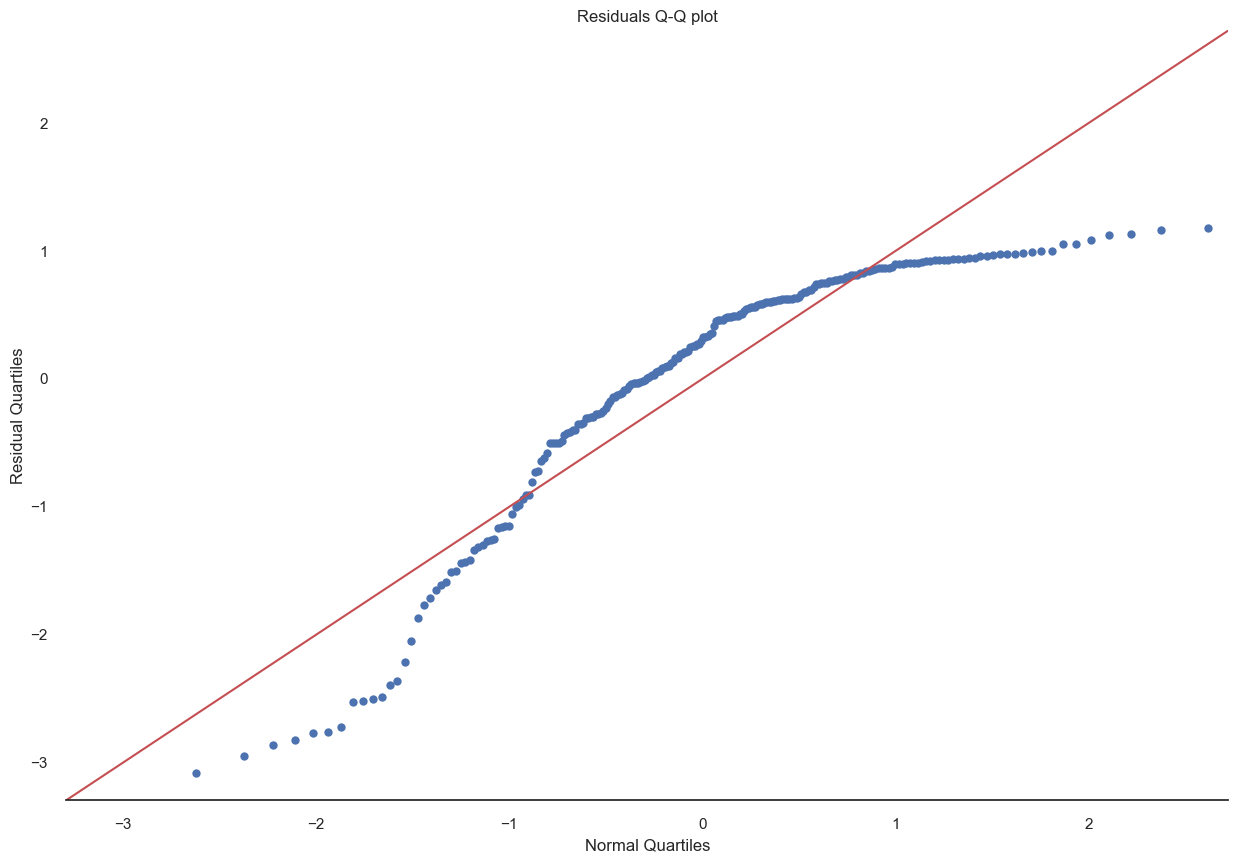

In [531]:
# Plot the quartiles of the residuals versus the quartiles of the N(0,1)
# The fit=True argument first Standardises the observed data (Residuals) before plotting them
sm.qqplot(mlr_model.resid, fit=True, line='45')
plt.ylabel("Residual Quartiles")
plt.xlabel("Normal Quartiles")
plt.title("Residuals Q-Q plot")
plt.show()

Observation: 

The optional assumption of Normality of error terms is violated.

 OLS does not require that the error term follows a normal distribution to produce unbiased estimates with the minimum variance. However, satisfying this assumption allows you to perform statistical hypothesis testing and generate reliable confidence intervals and prediction intervals.

#### Assess accuracy & test how the model generalises on unseen data 

Calculate and analyse goodness-of-fit measures:
- On the trainind dataset to evaluate the model's capacity to learn from the data. Helps identify underfitting (e.g., high training error or low R2).
- On the Test Dataset to assess how well the model generalises to unseen data.  Helps identify overfitting (e.g., much better metrics on training data than on test data).


In [535]:
# summarise goodness of fit measures for train dataset 
MLR_gof_summary = goodness_of_fit(Y_obs_train, Y_train_pred,  mlr_model, 'MLR_2_remss_train')

# add GOF for test dataset 
MLR_gof_summary = MLR_gof_summary.merge(goodness_of_fit(Y_obs_test, Y_test_pred,  mlr_model, 'MLR_2_remss_test'), left_index=True, right_index=True)

# print the summary
MLR_gof_summary

MLR_2_remss_train  MLR_2_remss_test
R2                        0.624550          0.603620
R2 (train)                0.614948          0.614948
Adj. R2 (train)           0.611495          0.611495
RMSE                    196.007377        196.764224
MAE                     155.237136        150.250712
MAPE, %                  11.301402         10.508687
q1 (y_real)            1168.750000       1215.000000
q3 (y_real)            1622.000000       1592.000000
mean (y_real)          1390.092920       1389.087719

Observation: 

FAIR FOR BOTH TRAIN & TEST

- The R-squared is strong and explains c.60% of the dependent variable (both on train & test).
- MAE & RMSE are smaller than the mean value of Y with MAPE c10%
- The difference between RMSE and MAE is moderate/small, which suggests that the model's prediction errors are relatively consistent and that there are few extreme outliers.

The model's performance is noted. To be compared with other models.

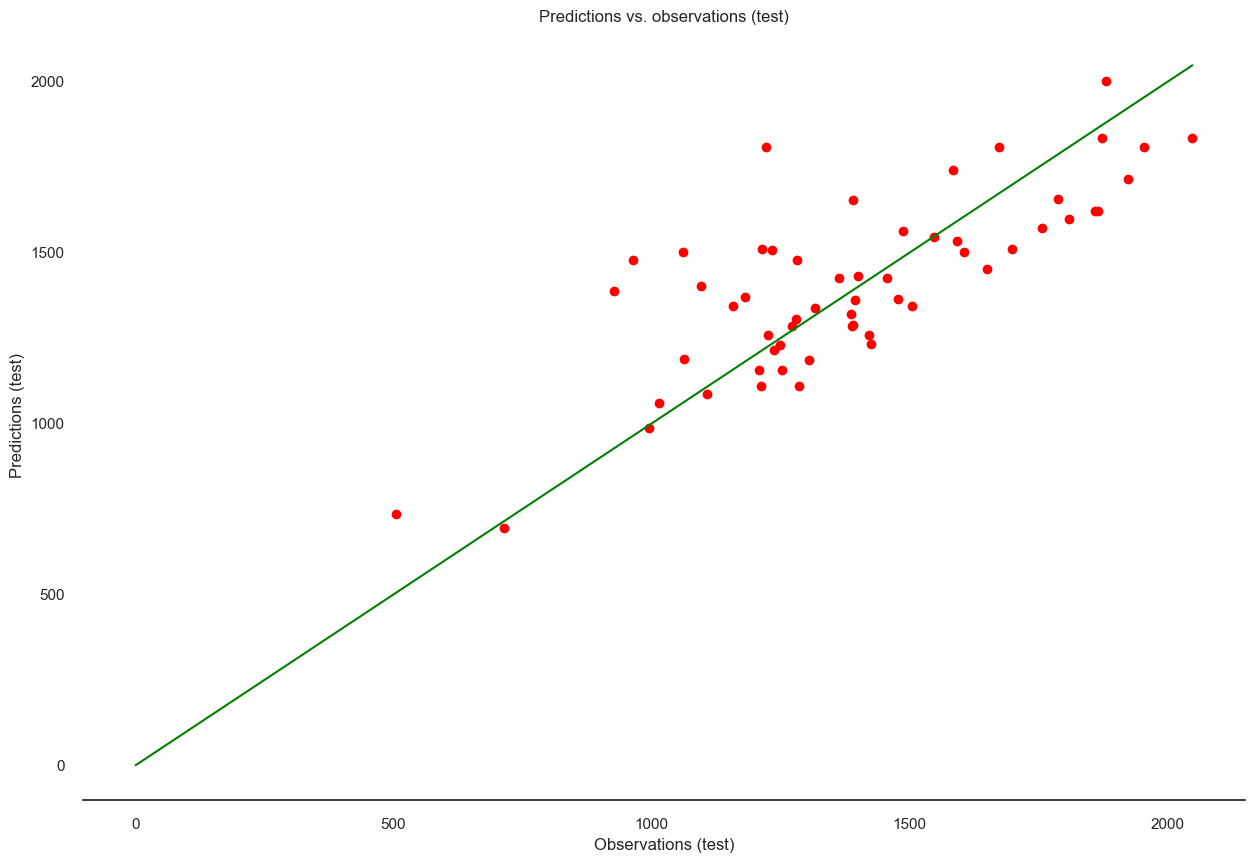

In [537]:
# Plot Predictions (y) vs. observations (x) on the test dataset
X_var = Y_obs_test
Y_var = Y_test_pred

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_var, Y_var, color='red')

# Add a diagonal line
plt.plot([0, X_var.max()], [0, X_var.max()], color='green')

# Labeling the axes
ax.set_xlabel('Observations (test)')
ax.set_ylabel('Predictions (test)')
ax.set_title('Predictions vs. observations (test)')

plt.show()

Supports the observations above

In [539]:
# update and print the goodness of fit summary
gof_summary = gof_summary.merge(MLR_gof_summary['MLR_2_remss_test'], left_index=True, right_index=True)

# view 
gof_summary

DT_prunned_test DT_fin_test    MLR_test  LR_3_rem_test  \
R2                     0.908051    0.902689    0.906427       0.869809   
R2 (train)                 None        None    0.891825       0.932260   
Adj. R2 (train)            None        None    0.891478       0.931914   
RMSE                 390.108166  401.321993  393.538048     717.926025   
MAE                  274.656903  296.629368  318.451350     537.882979   
MAPE, %               23.133588   27.254099   26.413167      19.523268   
q1 (y_real)          777.000000  777.000000  777.000000    1010.250000   
q3 (y_real)         1686.000000 1686.000000 1686.000000    4798.750000   
mean (y_real)       1529.000000 1529.000000 1529.000000    2867.920000   

                 MLR_2_test  MLR_1_test  MLR_2_remss_test  
R2                 0.724945    0.899409          0.603620  
R2 (train)         0.767631    0.917904          0.614948  
Adj. R2 (train)    0.764491    0.917070          0.611495  
RMSE             163.907850  128.713884        196.764224  
MAE              135.886796   83.708104        150.250712  
MAPE, %            9.783861   16.627255         10.508687  
q1 (y_real)     1215.000000  149.500000       1215.000000  
q3 (y_real)     1592.000000  700.000000       1592.000000  
mean (y_real)   1389.087719  505.098039       1389.087719

### 6 Scenario analysis 

Used spending-score-category-specific models to predict loyalty points’ balances in response to the change in customer purchasing behaviour, recognising their stronger error metrics:
- Scenario 1:  Cluster 1 spending score category = ‘2’ (‘medium’); Cluster 2 –   ‘3’ (‘high’)
- Scenario 2: Cluster 1 and Cluster 2 spending score category = ‘3’ (‘high’)

#### Make predictions

In [543]:
customers_full.head()

customer_ID  gender  age  remuneration  spending_score  loyalty_points  \
0          25  Female   37     14.760000               6              61   
1          29  Female   37     17.220000              35             417   
2          42  Female   33     13.940000              40             366   
3          43  Female   53     22.960000              14             238   
4          71    Male   37     19.680000              35             476   

      education age_group cluster predicted_class remuneration_cat  \
0   High-school     30-40       0               0                1   
1      Graduate     30-40       0               0                1   
2      Graduate     30-40       0               0                1   
3      Graduate     50-60       0               0                1   
4  Postgraduate     30-40       0               0                1   

  spending_score_cat remuneration_gr  
0                  1            0-20  
1                  1            0-20  
2                  1            0-20  
3                  1           20-30  
4                  1            0-20

In [544]:
# calculate average spending score per ss_cat
ss_by_sscat = customers_full[['spending_score_cat', 'spending_score']].groupby(by = 'spending_score_cat').mean().reset_index()

# assign variable to ss per the high ss_cat
ss_high_avg = ss_by_sscat['spending_score'][ss_by_sscat['spending_score_cat'] == '3'].values[0]

# assign variable to ss per the average ss_cat
ss_avg_avg = ss_by_sscat['spending_score'][ss_by_sscat['spending_score_cat'] == '2'].values[0]

In [545]:
# scenario 1 cluster 1 moves to avg ss cat;  3 move to high 
customers_full['spending_score_s1'] = customers_full['spending_score']
customers_full['spending_score_s1'][customers_full['cluster'] == '1'] = ss_avg_avg
customers_full['spending_score_s1'][customers_full['cluster'] == '3'] = ss_high_avg

# scenario 2 cluster 1 & 3 move to high ss score  cat
customers_full['spending_score_s2'] = customers_full['spending_score']
customers_full['spending_score_s2'][customers_full['cluster'] == '1'] = ss_high_avg
customers_full['spending_score_s2'][customers_full['cluster'] == '3'] = ss_high_avg

In [546]:
# define x -variable for scenario 2 modelling (remuneration for LR_3_rem)
X_sc2 = customers_full[(customers_full.cluster == '1') | (customers_full.cluster == '3')]['remuneration']
X_sc2

132   80.360000
133   63.960000
134   70.520000
135   63.960000
136   84.460000
         ...   
656   49.200000
657   40.180000
658   39.360000
659   44.280000
660   46.740000
Name: remuneration, Length: 402, dtype: float64

In [547]:
# Scenario 2: Predict loyalty points for cluster 2&3 as if they moved to the high spending score category (apply LR_3_rem)  

# Predict 
Y_sc2_tr = LR_3_rem.predict(sm.add_constant(X_sc2))

# apply backward transformation 
Y_sc2 =  Y_sc2_tr.apply(lambda x: math.pow(x, 5))

Y_sc2.name = 'loyalty_points_sc2'

# view 
Y_sc2

132   4238.702564
133   2962.604435
134   3429.578746
135   2962.604435
136   4617.871322
          ...    
656   2096.310030
657   1675.956427
658   1641.373580
659   1857.724197
660   1974.135136
Name: loyalty_points_sc2, Length: 402, dtype: float64

In [548]:
# add scenario predictions to customers ful
customers_full = customers_full.merge(Y_sc2, how='outer', left_index=True, right_index=True)

# remainig  clusters w/o change in this scenario
customers_full.loc[(customers_full.cluster != '1') & (customers_full.cluster != '3'), 'loyalty_points_sc2'] = customers_full['loyalty_points']

In [549]:
# define x -variable for scenario 1 modelling (remuneration & spending_score for MLR_2_remss)
X_sc1 = customers_full[customers_full.cluster == '1'][['remuneration', 'spending_score_s1']]
X_sc1.columns = ['remuneration', 'spending_score']
X_sc1['const'] = 1
X_sc1 = X_sc1[['const', 'remuneration', 'spending_score']]

X_sc1

const  remuneration  spending_score
132      1     80.360000       49.893993
133      1     63.960000       49.893993
134      1     70.520000       49.893993
135      1     63.960000       49.893993
136      1     84.460000       49.893993
..     ...           ...             ...
246      1     81.180000       49.893993
247      1     84.460000       49.893993
248      1     92.660000       49.893993
249      1     72.160000       49.893993
250      1    112.340000       49.893993

[119 rows x 3 columns]

In [550]:
# Predict 
Y_sc1_tr = MLR_2_remss.predict(X_sc1) 

# apply backward transformation 
Y_sc1 = Y_sc1_tr.apply(lambda x: math.pow(x, 2))

Y_sc1.name = 'loyalty_points_sc1'

# view
Y_sc1

132   2923.777676
133   2174.123840
134   2460.684554
135   2174.123840
136   3128.509911
          ...    
246   2964.169922
247   3128.509911
248   3558.756913
249   2535.095737
250   4704.406689
Name: loyalty_points_sc1, Length: 119, dtype: float64

In [551]:
# add scenario predictions to customers ful
customers_full = customers_full.merge(Y_sc1, how='outer', left_index=True, right_index=True)

# fill in those clusters w/o change in the scenario
customers_full.loc[customers_full.cluster != '1', 'loyalty_points_sc1'] = customers_full['loyalty_points_sc2']

In [552]:
customers_full.columns

Index(['customer_ID', 'gender', 'age', 'remuneration', 'spending_score',
       'loyalty_points', 'education', 'age_group', 'cluster',
       'predicted_class', 'remuneration_cat', 'spending_score_cat',
       'remuneration_gr', 'spending_score_s1', 'spending_score_s2',
       'loyalty_points_sc2', 'loyalty_points_sc1'],
      dtype='object')

In [553]:
customers_full.shape

(782, 17)

In [554]:
customers_full.isna().sum().sum()

0

In [555]:
customers_full.to_csv('customers_full.csv')

#### Summarise predictions

In [557]:
# agregate mean
prediction_mean = customers_full[['cluster', 'remuneration', 'spending_score', 'loyalty_points', 'spending_score_s1', \
'spending_score_s2', 'loyalty_points_sc1', 'loyalty_points_sc2']].groupby(by='cluster').mean()

# agregate sum
prediction_sum = customers_full[['cluster', 'loyalty_points', 'loyalty_points_sc1', 'loyalty_points_sc2']].groupby(by='cluster').sum()

# combine in one summary
prediction = prediction_mean.copy()
prediction = prediction.merge(prediction_sum, left_index=True, right_index=True, suffixes=('_avg', '_sum'))

# view
prediction

remuneration  spending_score  loyalty_points_avg  spending_score_s1  \
cluster                                                                        
0           19.574394       19.037879          246.643939          19.037879   
1           79.353950       17.815126          947.126050          49.893993   
2           19.311969       79.889764          980.519685          79.889764   
3           42.947138       49.893993         1389.890459          80.798387   
4           77.554380       81.752066         4197.024793          81.752066   

         spending_score_s2  loyalty_points_sc1_avg  loyalty_points_sc2_avg  \
cluster                                                                      
0                19.037879              246.643939              246.643939   
1                80.798387             2909.952785             4281.656779   
2                79.889764              980.519685              980.519685   
3                80.798387             1816.040563             1816.040563   
4                81.752066             4197.024793             4197.024793   

         loyalty_points_sum  loyalty_points_sc1_sum  loyalty_points_sc2_sum  
cluster                                                                      
0                     32557            32557.000000            32557.000000  
1                    112708           346284.381427           509517.156735  
2                    124526           124526.000000           124526.000000  
3                    393339           513939.479192           513939.479192  
4                    507840           507840.000000           507840.000000

In [558]:
# reorder columns 
prediction = prediction[['remuneration', 'spending_score', 'spending_score_s1', 'spending_score_s2', \
             'loyalty_points_avg', 'loyalty_points_sc1_avg', 'loyalty_points_sc2_avg', \
             'loyalty_points_sum', 'loyalty_points_sc1_sum', 'loyalty_points_sc2_sum']]

prediction

remuneration  spending_score  spending_score_s1  spending_score_s2  \
cluster                                                                       
0           19.574394       19.037879          19.037879          19.037879   
1           79.353950       17.815126          49.893993          80.798387   
2           19.311969       79.889764          79.889764          79.889764   
3           42.947138       49.893993          80.798387          80.798387   
4           77.554380       81.752066          81.752066          81.752066   

         loyalty_points_avg  loyalty_points_sc1_avg  loyalty_points_sc2_avg  \
cluster                                                                       
0                246.643939              246.643939              246.643939   
1                947.126050             2909.952785             4281.656779   
2                980.519685              980.519685              980.519685   
3               1389.890459             1816.040563             1816.040563   
4               4197.024793             4197.024793             4197.024793   

         loyalty_points_sum  loyalty_points_sc1_sum  loyalty_points_sc2_sum  
cluster                                                                      
0                     32557            32557.000000            32557.000000  
1                    112708           346284.381427           509517.156735  
2                    124526           124526.000000           124526.000000  
3                    393339           513939.479192           513939.479192  
4                    507840           507840.000000           507840.000000

In [559]:
# summary for report
prediction[['remuneration', 'spending_score', 'spending_score_s1', 'spending_score_s2']]

remuneration  spending_score  spending_score_s1  spending_score_s2
cluster                                                                    
0           19.574394       19.037879          19.037879          19.037879
1           79.353950       17.815126          49.893993          80.798387
2           19.311969       79.889764          79.889764          79.889764
3           42.947138       49.893993          80.798387          80.798387
4           77.554380       81.752066          81.752066          81.752066

In [560]:
# summary for report
prediction[['loyalty_points_avg', 'loyalty_points_sc1_avg', 'loyalty_points_sc2_avg', 'loyalty_points_sum', \
            'loyalty_points_sc1_sum', 'loyalty_points_sc2_sum']]

loyalty_points_avg  loyalty_points_sc1_avg  loyalty_points_sc2_avg  \
cluster                                                                       
0                246.643939              246.643939              246.643939   
1                947.126050             2909.952785             4281.656779   
2                980.519685              980.519685              980.519685   
3               1389.890459             1816.040563             1816.040563   
4               4197.024793             4197.024793             4197.024793   

         loyalty_points_sum  loyalty_points_sc1_sum  loyalty_points_sc2_sum  
cluster                                                                      
0                     32557            32557.000000            32557.000000  
1                    112708           346284.381427           509517.156735  
2                    124526           124526.000000           124526.000000  
3                    393339           513939.479192           513939.479192  
4                    507840           507840.000000           507840.000000

In [561]:
# summary for report
prediction[['loyalty_points_sum', 'loyalty_points_sc1_sum', 'loyalty_points_sc2_sum']].sum()

loyalty_points_sum       1170970.000000
loyalty_points_sc1_sum   1525146.860619
loyalty_points_sc2_sum   1688379.635927
dtype: float64

In [562]:
# export to csv to create the waterfall viz in Excel
prediction.to_csv('prediction.csv')

In [563]:
summary

predicted_class  avg_remuneration  avg_spending_score  avg_loyalty_points  \
0               0         19.574394           19.037879          246.643939   
1               1         79.353950           17.815126          947.126050   
2               2         19.311969           79.889764          980.519685   
3               3         42.947138           49.893993         1389.890459   
4               4         77.554380           81.752066         4197.024793   

   sum_loyalty_points  count_customers  revenue_share  customers_share  \
0               32557              132       2.780345        16.879795   
1              112708              119       9.625183        15.217391   
2              124526              127      10.634431        16.240409   
3              393339              283      33.590869        36.189258   
4              507840              121      43.369173        15.473146   

   remuneration_cat  spending_score_cat  
0                 1                   1  
1                 3                   1  
2                 1                   3  
3                 2                   2  
4                 3                   3

### 7 Insights and observations 

Given that the linear regression assumptions are satisfied, models can predict loyalty points based on customers' remuneration and target spending scores. MLR, LR_3_rem and MLR_1 models have very strong predictive power with R-squared of 91%, 87% and 90%, respectively.  MLR_2_remss has strong predictive power with an R-squared of 60%

We note that a small group of observations lies aside from the general linear pattern observed in the spending_score¬loyalty_points scatterplot in the MLR_remss model. We recommend investigating whether those observations can be seen as outliers and excluded from the analysis. This must result in a demonstrably improved R-squared.

If the target spending score levels specific to each scenario are achieved, the total loyalty points balance is projected to increase by 30.2% in Scenario 1 and 10.7% in Scenario 2. Since loyalty points represent the value of purchases, we extrapolate these results to revenue.


In [566]:
LR_stat_summary

MLR_all LR_3_rem    MLR_2    MLR_1  \
Durbin-Watson statistic (1.5-2.5) 1.933877 2.298320 1.982308 1.805602   
F statistic p-value (< 0.05)      0.000000 0.000000 0.000000 0.000000   
JB Probability (> 0.05)           0.000000 0.192341 0.000000 0.000000   
LM Test p-value (> 0.05)          0.578577 0.165024 0.126928 0.291067   
Resid. vs age corr                     NaN      NaN     0.00      NaN   
Resid. vs remuneration corr          -0.00    -0.00    -0.00    -0.00   
Resid. vs spending_score corr        -0.00      NaN    -0.00     0.00   
VIF Factor: age (<10)                  NaN      NaN 1.000956      NaN   
VIF Factor: remuneration (<10)    1.000195 1.000000 1.042453 1.000360   
VIF Factor: spending_score (<10)  1.000195      NaN 1.041482 1.000360   

                                  MLR_2_remss  
Durbin-Watson statistic (1.5-2.5)    2.094445  
F statistic p-value (< 0.05)         0.000000  
JB Probability (> 0.05)              0.000000  
LM Test p-value (> 0.05)             0.327871  
Resid. vs age corr                        NaN  
Resid. vs remuneration corr             -0.00  
Resid. vs spending_score corr           -0.00  
VIF Factor: age (<10)                     NaN  
VIF Factor: remuneration (<10)       1.041479  
VIF Factor: spending_score (<10)     1.041479

In [567]:
# subset for the repot section
gof_summary[['MLR_test', 'LR_3_rem_test', 'MLR_1_test', 'MLR_2_remss_test']]

MLR_test  LR_3_rem_test  MLR_1_test  MLR_2_remss_test
R2                 0.906427       0.869809    0.899409          0.603620
R2 (train)         0.891825       0.932260    0.917904          0.614948
Adj. R2 (train)    0.891478       0.931914    0.917070          0.611495
RMSE             393.538048     717.926025  128.713884        196.764224
MAE              318.451350     537.882979   83.708104        150.250712
MAPE, %           26.413167      19.523268   16.627255         10.508687
q1 (y_real)      777.000000    1010.250000  149.500000       1215.000000
q3 (y_real)     1686.000000    4798.750000  700.000000       1592.000000
mean (y_real)   1529.000000    2867.920000  505.098039       1389.087719

#  

# NLP using Python

### 1 Pre-process data for sentiment analysis & word clouds (initial pre-processing)

Approach:

VADER operates on entire sentences or comments rather than tokens. However, splitting into sentences using tools like nltk.sent_tokenize can improve fine-grained analysis for longer texts.

In [572]:
reviews_full.head()

gender  age  remuneration  spending_score  loyalty_points education  \
0    Male   18     12.300000              39             210  Graduate   
1    Male   23     12.300000              81             524  Graduate   
2  Female   22     13.120000               6              40  Graduate   
3  Female   25     13.120000              77             562  Graduate   
4  Female   33     13.940000              40             366  Graduate   

  customer_ID cluster remuneration_cat spending_score_cat  \
0         191       0                1                  1   
1         133       2                1                  3   
2         194       0                1                  1   
3         149       2                1                  3   
4          42       0                1                  1   

                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:

Your unpainted...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary  
0  The fact that 50% of this space is wasted on a...  
1  Another worthless Dungeon Master's screen from...  
2                    pretty, but also pretty useless  
3                                         Five Stars  
4                                         Money trap

In [573]:
# Subset necessary columns.
reviews_subset = reviews_full.copy()
reviews_subset = reviews_subset[['cluster', 'review']].reset_index(names='review_id')
reviews_subset = reviews_subset[['cluster', 'review_id', 'review']]

# View DataFrame.
reviews_subset.head(2).style.set_properties(subset=['review'], **{'width': '1200px'})

In [574]:
# View DataFrame.
reviews_subset.head(2).style.set_properties(subset=['review'], **{'width': '1200px'})

In [575]:
# Tokenise: sentense-tokens.
reviews_subset['sent_tokens'] = reviews_subset['review'].apply(sent_tokenize)

# View DataFrame.
reviews_subset.head(1).style.set_properties(subset=['review', 'sent_tokens'], **{'width': '1200px'})

In [576]:
# Transform the DataFrame: explode
reviews_subset = reviews_subset.explode('sent_tokens', ignore_index=True)

# Display the transformed DataFrame
reviews_subset.head(4).style.set_properties(subset=['review', 'sent_tokens'], **{'width': '1200px'})

In [577]:
reviews_subset.shape

(7874, 4)

In [578]:
# Apply pre-processing to sent_tokens
reviews_subset['sent_tokens_clean'] = reviews_subset['sent_tokens'].apply(preprocess_sent)

# Display the transformed DataFrame
reviews_subset.loc[:, reviews_subset.columns != 'review'].head(2)\
.style.set_properties(subset=['sent_tokens', 'sent_tokens_clean'], **{'width': '1200px'})

In [579]:
# Store tokensised words in a separate column
reviews_subset['word_tokens'] = reviews_subset['sent_tokens_clean'].str.replace('[^\w\s]',' ', regex=True).apply(word_tokenize)

# Display the transformed DataFrame
reviews_subset[['cluster', 'review_id', 'sent_tokens_clean', 'word_tokens']].head(2)\
.style.set_properties(subset=['sent_tokens_clean', 'word_tokens'], **{'width': '1200px'})

In [580]:
# Apply pre-processing to word_tokens
reviews_subset['word_tokens_clean'] = reviews_subset['word_tokens'].apply(preprocess_words)

# Display the transformed DataFrame
reviews_subset[['cluster', 'review_id', 'sent_tokens_clean', 'word_tokens_clean']].head(3)\
.style.set_properties(subset=['sent_tokens_clean', 'word_tokens_clean'], **{'width': '1200px'})

### 2 Frequency distribution and use-case specific analysis 

Evaluate sentiment for the most frequent words

In [583]:
# create a frequency distribution table with words, lemmas and sentiment
# create a variable for word_tokens before lemmatisation 
words = reviews_subset['word_tokens_clean'].copy()

# derive the number of unique words and store in a separate column
words = words.reset_index()
words.columns = ['count', 'word']
words = words.explode('word', ignore_index=True)
words = words.dropna()
words = words.groupby(by='word').count().sort_values(by='count', ascending=False).reset_index()

# populate the lemma column 
words['lemma'] = words['word'].apply(lambda x: lemmatiser.lemmatize(x, pos=get_wordnet_pos(nltk.pos_tag([x])[0][1])) \
                  if get_wordnet_pos(nltk.pos_tag([x])[0][1]) else lemmatiser.lemmatize(x))

# call VADER polarity scores and store in separate variables based on word (not lemma)
words['vader'] = words['word'].apply(lambda x: list(sia.polarity_scores(x).values()))
words[['neg', 'neu', 'pos', 'compound']] = words['vader'].apply(pd.Series).values
words.drop(columns='vader', inplace=True)

# reorder columns
words = words[['word', 'lemma', 'count', 'neg', 'neu', 'pos', 'compound']]

# view
words.head(2)

word lemma  count      neg      neu      pos  compound
0  game  game   1711 0.000000 1.000000 0.000000  0.000000
1   one   one    662 0.000000 1.000000 0.000000  0.000000

In [584]:
words

word          lemma  count      neg      neu      pos  compound
0              game           game   1711 0.000000 1.000000 0.000000  0.000000
1               one            one    662 0.000000 1.000000 0.000000  0.000000
2             great          great    598 0.000000 0.000000 1.000000  0.624900
3               fun            fun    558 0.000000 0.000000 1.000000  0.510600
4              play           play    509 0.000000 0.000000 1.000000  0.340000
...             ...            ...    ...      ...      ...      ...       ...
6675          index          index      1 0.000000 1.000000 0.000000  0.000000
6676      indicated       indicate      1 0.000000 1.000000 0.000000  0.000000
6677      indicates      indicates      1 0.000000 1.000000 0.000000  0.000000
6678  indispensable  indispensable      1 0.000000 1.000000 0.000000  0.000000
6679           zone           zone      1 0.000000 1.000000 0.000000  0.000000

[6680 rows x 7 columns]

In [585]:
# view most frequent negative words 
words[words.neg == 1].head(25)

word         lemma  count      neg      neu      pos  compound
74           anger         anger    102 1.000000 0.000000 0.000000 -0.571900
108           hard          hard     81 1.000000 0.000000 0.000000 -0.102700
212      difficult     difficult     50 1.000000 0.000000 0.000000 -0.361200
297   disappointed  disappointed     38 1.000000 0.000000 0.000000 -0.476700
357            bad           bad     32 1.000000 0.000000 0.000000 -0.542300
444        problem       problem     26 1.000000 0.000000 0.000000 -0.401900
475         boring        boring     24 1.000000 0.000000 0.000000 -0.318200
501           lost          lose     23 1.000000 0.000000 0.000000 -0.318200
553            cut           cut     20 1.000000 0.000000 0.000000 -0.273200
554          alone         alone     20 1.000000 0.000000 0.000000 -0.250000
568         attack        attack     20 1.000000 0.000000 0.000000 -0.476700
575           risk          risk     19 1.000000 0.000000 0.000000 -0.273200
588            die           die     19 1.000000 0.000000 0.000000 -0.599400
613    frustrating     frustrate     18 1.000000 0.000000 0.000000 -0.440400
635         battle        battle     17 1.000000 0.000000 0.000000 -0.381800
642          bored          bore     17 1.000000 0.000000 0.000000 -0.273200
648           mess          mess     17 1.000000 0.000000 0.000000 -0.361200
680        limited       limited     16 1.000000 0.000000 0.000000 -0.226300
686            low           low     16 1.000000 0.000000 0.000000 -0.273200
691            pay           pay     16 1.000000 0.000000 0.000000 -0.102700
716          wrong         wrong     15 1.000000 0.000000 0.000000 -0.476700
717        missing          miss     15 1.000000 0.000000 0.000000 -0.296000
750         damage        damage     14 1.000000 0.000000 0.000000 -0.493900
753       negative      negative     14 1.000000 0.000000 0.000000 -0.571900
765  disappointing    disappoint     14 1.000000 0.000000 0.000000 -0.493900

In [586]:
# view most frequent positive words 
words[words.pos == 1].head(25)

word       lemma  count      neg      neu      pos  compound
2         great       great    598 0.000000 0.000000 1.000000  0.624900
3           fun         fun    558 0.000000 0.000000 1.000000  0.510600
4          play        play    509 0.000000 0.000000 1.000000  0.340000
5          like        like    421 0.000000 0.000000 1.000000  0.361200
7          love        love    332 0.000000 0.000000 1.000000  0.636900
14         good        good    296 0.000000 0.000000 1.000000  0.440400
16         well        well    273 0.000000 0.000000 1.000000  0.273200
26      playing        play    230 0.000000 0.000000 1.000000  0.202300
30       played      played    207 0.000000 0.000000 1.000000  0.340000
49        loves        love    145 0.000000 0.000000 1.000000  0.571900
52         easy        easy    140 0.000000 0.000000 1.000000  0.440400
54         nice        nice    133 0.000000 0.000000 1.000000  0.421500
55    recommend   recommend    129 0.000000 0.000000 1.000000  0.361200
56       better        well    129 0.000000 0.000000 1.000000  0.440400
66         cute        cute    113 0.000000 0.000000 1.000000  0.458800
75         gift        gift    101 0.000000 0.000000 1.000000  0.440400
77        loved        love    100 0.000000 0.000000 1.000000  0.599400
81         want        want     98 0.000000 0.000000 1.000000  0.077200
88        enjoy       enjoy     93 0.000000 0.000000 1.000000  0.493900
93         best        best     89 0.000000 0.000000 1.000000  0.636900
96      friends      friend     87 0.000000 0.000000 1.000000  0.476700
101      pretty      pretty     85 0.000000 0.000000 1.000000  0.493900
106        help        help     81 0.000000 0.000000 1.000000  0.401900
122  definitely  definitely     74 0.000000 0.000000 1.000000  0.401900
128       worth       worth     72 0.000000 0.000000 1.000000  0.226300

In [587]:
# view most frequent neutral words 
words[words.neu == 1].head(25)

word   lemma  count      neg      neu      pos  compound
0     game    game   1711 0.000000 1.000000 0.000000  0.000000
1      one     one    662 0.000000 1.000000 0.000000  0.000000
6    would   would    357 0.000000 1.000000 0.000000  0.000000
8      get     get    320 0.000000 1.000000 0.000000  0.000000
9   really  really    319 0.000000 1.000000 0.000000  0.000000
10     two     two    313 0.000000 1.000000 0.000000  0.000000
11   cards    card    306 0.000000 1.000000 0.000000  0.000000
12   tiles    tile    298 0.000000 1.000000 0.000000  0.000000
13    time    time    298 0.000000 1.000000 0.000000  0.000000
15    book    book    278 0.000000 1.000000 0.000000  0.000000
17     old     old    271 0.000000 1.000000 0.000000  0.000000
18     new     new    264 0.000000 1.000000 0.000000  0.000000
19   games    game    254 0.000000 1.000000 0.000000  0.000000
20    much    much    251 0.000000 1.000000 0.000000  0.000000
21   board   board    250 0.000000 1.000000 0.000000  0.000000
22  little  little    248 0.000000 1.000000 0.000000  0.000000
23     use     use    245 0.000000 1.000000 0.000000  0.000000
24    make    make    237 0.000000 1.000000 0.000000  0.000000
25    kids     kid    233 0.000000 1.000000 0.000000  0.000000
27     set     set    222 0.000000 1.000000 0.000000  0.000000
28    year    year    220 0.000000 1.000000 0.000000  0.000000
29   three   three    213 0.000000 1.000000 0.000000  0.000000
31    also    also    203 0.000000 1.000000 0.000000  0.000000
32    even    even    199 0.000000 1.000000 0.000000  0.000000
33  pieces   piece    194 0.000000 1.000000 0.000000  0.000000

**Action:**

Review comments containing words below. hypothesis these are game featuers and do not have negative sentiment in this use case

- 'Negative words':  **[anger, attack, cut, battle, die, pay, damage]** 
- 'Positive words': **[Play, playing, played,  help]** in gaming context should be viewed as neutral rather than negative - exclude
- 'Neutral' - no inconsistencies identified

In [589]:
# view the selected words (reset the i variable to view words one by one)
i = 'anger'
reviews_subset[['sent_tokens', 'review']][reviews_subset['sent_tokens'].str.contains(i) ]\
.style.set_properties(subset=['review', 'sent_tokens'], **{'width': '1200px'})

Action: 

Custom search based on the analysis above: ['monst', 'villain', 'enem', ' kill', ' hit ', 'hitting']

In [591]:
# review words that came to our attention [monster, enemy, kill, hit / hitting] 
# List of words to filter
filter_words = ['monst', 'villain', 'enemy', 'kill', ' hit ', 'hitting']

# Create a regex pattern from the filter words
pattern = '|'.join(filter_words)

# Filter pos & neg selected words in the words using str.contains
words[words['neu'] != 1][words['word'].str.contains(pattern, regex=True)].sort_values(by='lemma')

word          lemma  count      neg      neu      pos  compound
4696  demonstration  demonstration      1 0.000000 0.000000 1.000000  0.102700
3368          enemy          enemy      2 1.000000 0.000000 0.000000 -0.542300
842            kill           kill     12 1.000000 0.000000 0.000000 -0.690800
1702        killing           kill      5 1.000000 0.000000 0.000000 -0.659700
2665         killed           kill      2 1.000000 0.000000 0.000000 -0.670500
6525          kills           kill      1 1.000000 0.000000 0.000000 -0.542300
6524         killer         killer      1 1.000000 0.000000 0.000000 -0.648600
2474        villain        villain      3 1.000000 0.000000 0.000000 -0.557400
3658       villains        villain      1 1.000000 0.000000 0.000000 -0.659700

**Conclusion:**

Exclude the words from the sentences based - sentiment is neutral rather than negative/positive in the gaming context.
 LEMMAS: [anger, attack, cut, battle, die, pay, play, played, help, enemy, kill, killer, villain]  


- 'battle game'
- 'I'm a mental health therapist that works with kids, many of whom have anger control issues.'
- 'Well, most enemies have a +7 to +11 to their attack.'
- '20-sided die Miniatures' / 'roll the die'
- 'cut the yarn'
- 'pay attention' / 'Get what you pay for'
- 'The plastic part that helps hold the peg is broken or has shifted.
- 'kill monsters', 'kill creatures''

Do not exclude 'damage' and 'kill' - inconsistent sentiment in different review contexts. relatively low count 

In [593]:
lemmas_to_filter = ['anger', 'attack', 'cut', 'battle', 'die', 'pay', 'play', 'played', 'help', 'enemy', 'kill', 'killer', 'villain']

In [594]:
# identify all words associated with selected lemmas
filtered_lemmas = words[words['lemma'].isin(lemmas_to_filter)].sort_values(by=['count'], ascending=False)
#filtered_lemmas = words[words['lemma'].str.contains(pattern, regex=True)].sort_values(by=['count'], ascending=False)

filtered_lemmas.shape, filtered_lemmas

((32, 7),
            word    lemma  count      neg      neu      pos  compound
 4          play     play    509 0.000000 0.000000 1.000000  0.340000
 26      playing     play    230 0.000000 0.000000 1.000000  0.202300
 30       played   played    207 0.000000 0.000000 1.000000  0.340000
 74        anger    anger    102 1.000000 0.000000 0.000000 -0.571900
 106        help     help     81 0.000000 0.000000 1.000000  0.401900
 272       plays     play     40 0.000000 0.000000 1.000000  0.250000
 375       helps     help     31 0.000000 0.000000 1.000000  0.381800
 553         cut      cut     20 1.000000 0.000000 0.000000 -0.273200
 568      attack   attack     20 1.000000 0.000000 0.000000 -0.476700
 579      helped     help     19 0.000000 1.000000 0.000000  0.000000
 588         die      die     19 1.000000 0.000000 0.000000 -0.599400
 635      battle   battle     17 1.000000 0.000000 0.000000 -0.381800
 691         pay      pay     16 1.000000 0.000000 0.000000 -0.102700
 772     h

The list of words identified is ok. 

- play/playing/played - should not be seen as positive in the gaming context 
- 'anger' - in this case mostly appears to be in a positive context related to 'anger management'
- words like 'battle', 'enemy' - do not have negative sentiment in the gaming context (though marked as neg) and for this reason, are to be excluded 
- Other filtered words either have a neutral sentiment or low occurrence and are not expected to affect sentiment analysis (fine to exclude) demonstrably.

In [596]:
# create a list of unique words to exclude
words_to_exclude = list(set(list(filtered_lemmas['word'].values)))
print(words_to_exclude)

['died', 'battles', 'villain', 'attacks', 'die', 'helped', 'attack', 'help', 'cuts', 'enemies', 'paying', 'villains', 'helping', 'play', 'attacked', 'plays', 'pay', 'played', 'anger', 'kill', 'killer', 'playing', 'killing', 'cut', 'battle', 'helps', 'enemy', 'killed', 'kills', 'attacking', 'pays', 'cutting']


Observation:

- Individual words like "five" (a neutral number) and "stars" (a neutral noun) do not inherently convey sentiment.
- 
Since sentiment scores are assigned at the word level and combined, the resulting score for "five stars" is neutral (polarity = 0.0)
- To adjust for this sentiment is assigned manually to phrases like "five stars".

In [598]:
# define ratings to replace
ratings = ['zero stars', 'one stars', 'two stars', 'three stars', 'four stars', 'five stars', 'six stars', \
           'zero star', 'one star', 'two star', 'three star', 'four star', 'five star', 'six star']
# replace with 
replacement = ["horrifying", "bad", 'appalling', "neutral", "fine", "superb", 'superb'] * 2
# create dictionary
replace_dict = dict((zip(ratings,replacement)))

# view assigned scores
for i in replacement:
    print(i, generate_polarity(i), sia.polarity_scores(i))

horrifying -0.9 {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5719}
bad -0.6999999999999998 {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5423}
appalling -0.35 {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.3612}
neutral 0.0 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
fine 0.4166666666666667 {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.2023}
superb 1.0 {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}
superb 1.0 {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}
horrifying -0.9 {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5719}
bad -0.6999999999999998 {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5423}
appalling -0.35 {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.3612}
neutral 0.0 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
fine 0.4166666666666667 {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.2023}
superb 1.0 {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}
superb 1.0 {'neg': 0.0, 'neu': 0.0, 'pos':

**Decission:**

Exclude all lemmas except 'anger' and 'pay' from word_tokens_clean (i.e. word cloud) as they are not meaningful in gaming context. 

In [600]:
print(lemmas_to_filter)

['anger', 'attack', 'cut', 'battle', 'die', 'pay', 'play', 'played', 'help', 'enemy', 'kill', 'killer', 'villain']


In [601]:
# define lemmas_to_exclude from wordcloud 
do_not_exclude_from_wc = ['anger', 'cut', 'die', 'pay', 'help']
add_to_list = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'star', 'stars']
lemmas_to_exclude_wc = list(set(lemmas_to_filter) - set(do_not_exclude_from_wc)) + add_to_list
print(lemmas_to_exclude_wc)

['kill', 'killer', 'enemy', 'villain', 'play', 'played', 'attack', 'battle', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'star', 'stars']


### 3 Pre-process (stage 2) data for sentiment analysis & word clouds

In [603]:
print(words_to_exclude)

['died', 'battles', 'villain', 'attacks', 'die', 'helped', 'attack', 'help', 'cuts', 'enemies', 'paying', 'villains', 'helping', 'play', 'attacked', 'plays', 'pay', 'played', 'anger', 'kill', 'killer', 'playing', 'killing', 'cut', 'battle', 'helps', 'enemy', 'killed', 'kills', 'attacking', 'pays', 'cutting']


In [604]:
print(replace_dict)

{'zero stars': 'horrifying', 'one stars': 'bad', 'two stars': 'appalling', 'three stars': 'neutral', 'four stars': 'fine', 'five stars': 'superb', 'six stars': 'superb', 'zero star': 'horrifying', 'one star': 'bad', 'two star': 'appalling', 'three star': 'neutral', 'four star': 'fine', 'five star': 'superb', 'six star': 'superb'}


In [605]:
# exclude selected words from sent_tokens_clean (e.g. anger - no negative sentiment in this context)
reviews_subset['sent_tokens_clean'] = reviews_subset['sent_tokens_clean']\
.apply(lambda x: " ".join(w for w in word_tokenize(x) if w not in words_to_exclude))

# replace ratings (e.g. 'five stars') with words associated with sentiment ('excellent') as per the custom dictionary
reviews_subset['sent_tokens_clean'] = reviews_subset['sent_tokens_clean'].apply(lambda x: replace_all(x, replace_dict))

# Display the transformed DataFrame
reviews_subset[['cluster', 'review_id', 'sent_tokens', 'sent_tokens_clean']].head(3)\
.style.set_properties(subset=['sent_tokens', 'sent_tokens_clean'], **{'width': '1200px'})

In [606]:
# call VADER polarity scores and store in separate variables 
reviews_subset['vader'] = reviews_subset['sent_tokens_clean'].apply(lambda x: list(sia.polarity_scores(x).values()))
reviews_subset[['neg', 'neu', 'pos', 'compound']] = reviews_subset['vader'].apply(pd.Series).values
reviews_subset.drop(columns='vader', inplace=True)

# Display the transformed DataFrame
reviews_subset[['cluster', 'review_id', 'sent_tokens', 'sent_tokens_clean', 'word_tokens_clean', 'neg', 'neu', 'pos', 'compound']].head(3)\
.style.set_properties(subset=['sent_tokens', 'sent_tokens_clean', 'word_tokens_clean'], **{'width': '1200px'})

In [607]:
print(lemmas_to_exclude_wc)

['kill', 'killer', 'enemy', 'villain', 'play', 'played', 'attack', 'battle', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'star', 'stars']


In [608]:
# lemmatise word_tokens
reviews_subset['word_tokens_clean'] = reviews_subset['word_tokens_clean']\
.apply(lambda x: [lemmatiser.lemmatize(word, pos=get_wordnet_pos(tag)) \
                  if get_wordnet_pos(tag) else lemmatiser.lemmatize(word) \
                  for word, tag in nltk.pos_tag(x)])

# Remove stopwords and selected lemmas from word_tokens_clean (if any new after lemmatisation)
reviews_subset['word_tokens_clean'] = reviews_subset['word_tokens_clean']\
.apply(lambda x: [word for word in x if word not in english_stopwords and word not in lemmas_to_exclude_wc])

# Display the transformed DataFrame
reviews_subset[['cluster', 'review_id', 'sent_tokens', 'word_tokens', 'word_tokens_clean']].head(3)\
.style.set_properties(subset=['sent_tokens', 'word_tokens', 'word_tokens_clean'], **{'width': '1200px'})

In [609]:
# subset and rearrange columns
reviews_subset = reviews_subset[['cluster', 'review_id', \
                                 'sent_tokens', 'sent_tokens_clean', 'word_tokens_clean', \
                                 'neg', 'neu', 'pos', 'compound']]

# view the df
reviews_subset.head(2).style.set_properties(subset=['sent_tokens', 'sent_tokens_clean', 'word_tokens_clean'], **{'width': '1200px'})

In [610]:
# enrich reviews_subset features
reviews_subset['cluster'] = reviews_subset['cluster'].astype('str')
reviews_subset = reviews_subset.merge(summary[['predicted_class', 'remuneration_cat', 'spending_score_cat']], \
                                      how='outer', left_on='cluster', right_on='predicted_class') 

In [611]:
reviews_full.columns

Index(['gender', 'age', 'remuneration', 'spending_score', 'loyalty_points',
       'education', 'customer_ID', 'cluster', 'remuneration_cat',
       'spending_score_cat', 'review', 'summary'],
      dtype='object')

In [612]:
reviews_subset.drop(columns=['predicted_class'], inplace=True)

In [613]:
reviews_subset.columns

Index(['cluster', 'review_id', 'sent_tokens', 'sent_tokens_clean',
       'word_tokens_clean', 'neg', 'neu', 'pos', 'compound',
       'remuneration_cat', 'spending_score_cat'],
      dtype='object')

In [614]:
# transform to long format for ease of va=isualisation
reviews_subset_long = reviews_subset.melt(id_vars=['cluster', 'review_id', 'sent_tokens', 'sent_tokens_clean', 'word_tokens_clean', \
                                                   'remuneration_cat', 'spending_score_cat'], \
                                          value_vars=['neg', 'neu', 'pos', 'compound'], var_name= 'sentiment_type', value_name='sentiment_score')

In [615]:
reviews_subset_long.head()

cluster  review_id                                        sent_tokens  \
0       0          0  When it comes to a DM's screen, the space on t...   
1       0          0  The fact that 50% of this space is wasted on a...   
2       0          0  The only reason that I gave it 2 stars and not...   
3       0          0     Other than that, it drops the ball completely.   
4       0          2                           Nice art, nice printing.   

                                   sent_tokens_clean  \
0  when it comes to a dm s screen , the space on ...   
1  the fact that fifty % of this space is wasted ...   
2  the only reason that i gave it appalling and n...   
3   other than that , it drops the ball completely .   
4                         nice art , nice printing .   

                                   word_tokens_clean  remuneration_cat  \
0  [come, dm, screen, space, screen, absolute, pr...                 1   
1  [fact, fifty, space, waste, art, terribly, inf...                 1   
2  [reason, give, technically, speak, least, stil...                 1   
3                           [drop, ball, completely]                 1   
4                        [nice, art, nice, printing]                 1   

   spending_score_cat sentiment_type  sentiment_score  
0                   1            neg         0.000000  
1                   1            neg         0.201000  
2                   1            neg         0.172000  
3                   1            neg         0.000000  
4                   1            neg         0.000000

#### By spending score

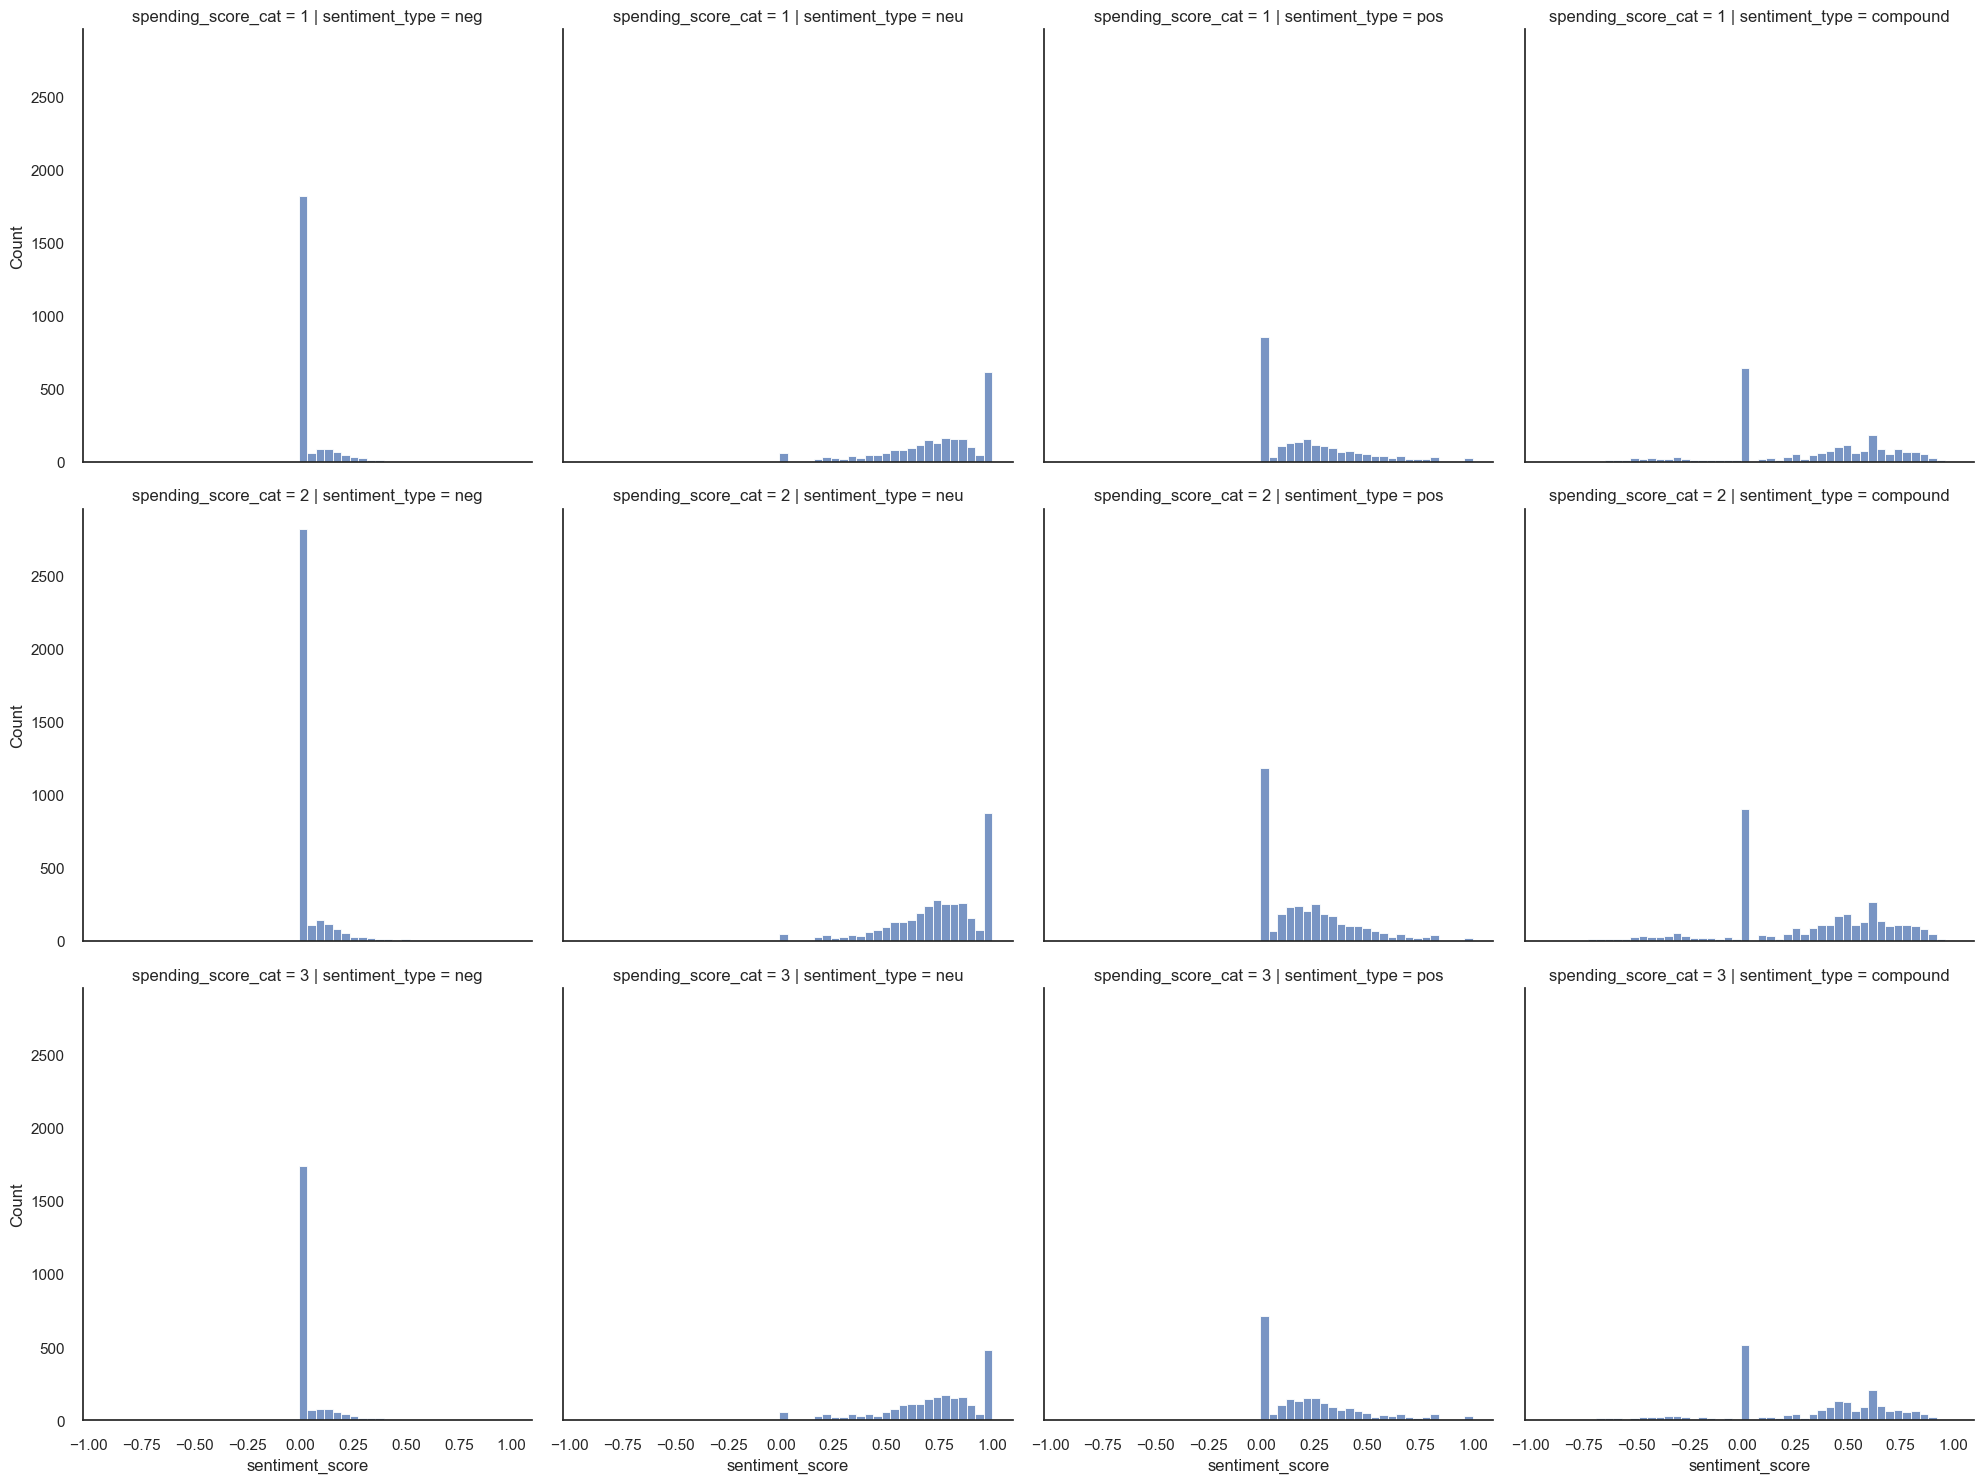

In [617]:
# sentiment score distribution by sentiment type and spending_score-category
sns.displot(data = reviews_subset_long, \
            x = 'sentiment_score', row = 'spending_score_cat', col= 'sentiment_type' , kind='hist')

There is no noticeable difference in patterns of sentiment score distribution across spending score categories 

#### By remuneration cat

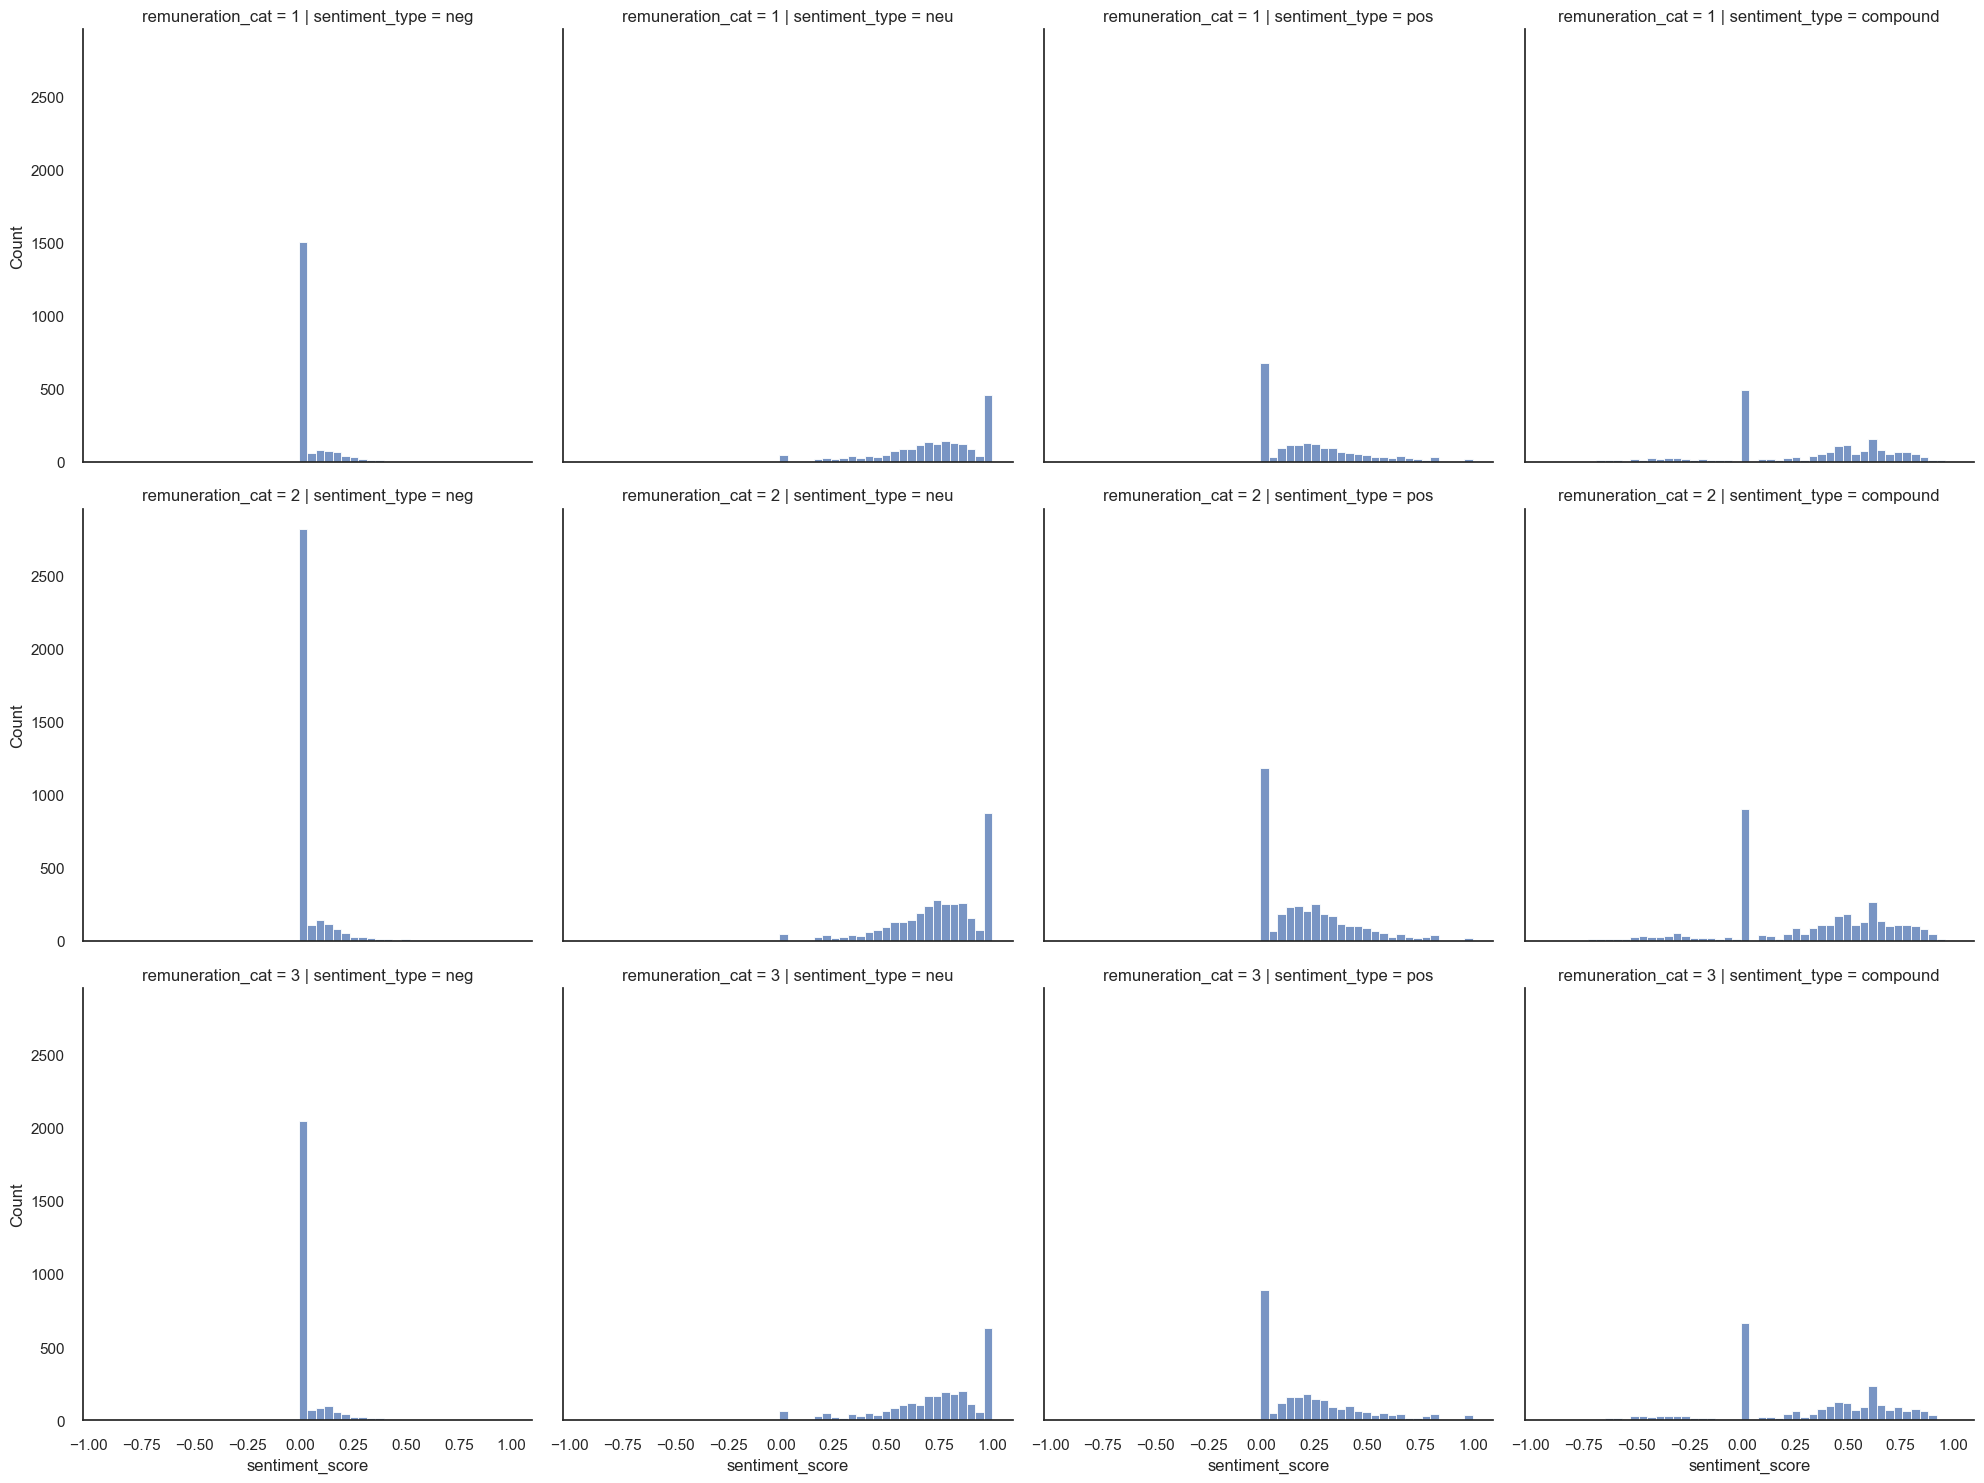

In [620]:
# sentiment score distribution by sentiment type and spending_score-category
sns.displot(data = reviews_subset_long, \
            x = 'sentiment_score', row = 'remuneration_cat', col= 'sentiment_type' , kind='hist')

There is no noticeable difference in patterns of sentiment score distribution across renumeration categories 

#### By cluster

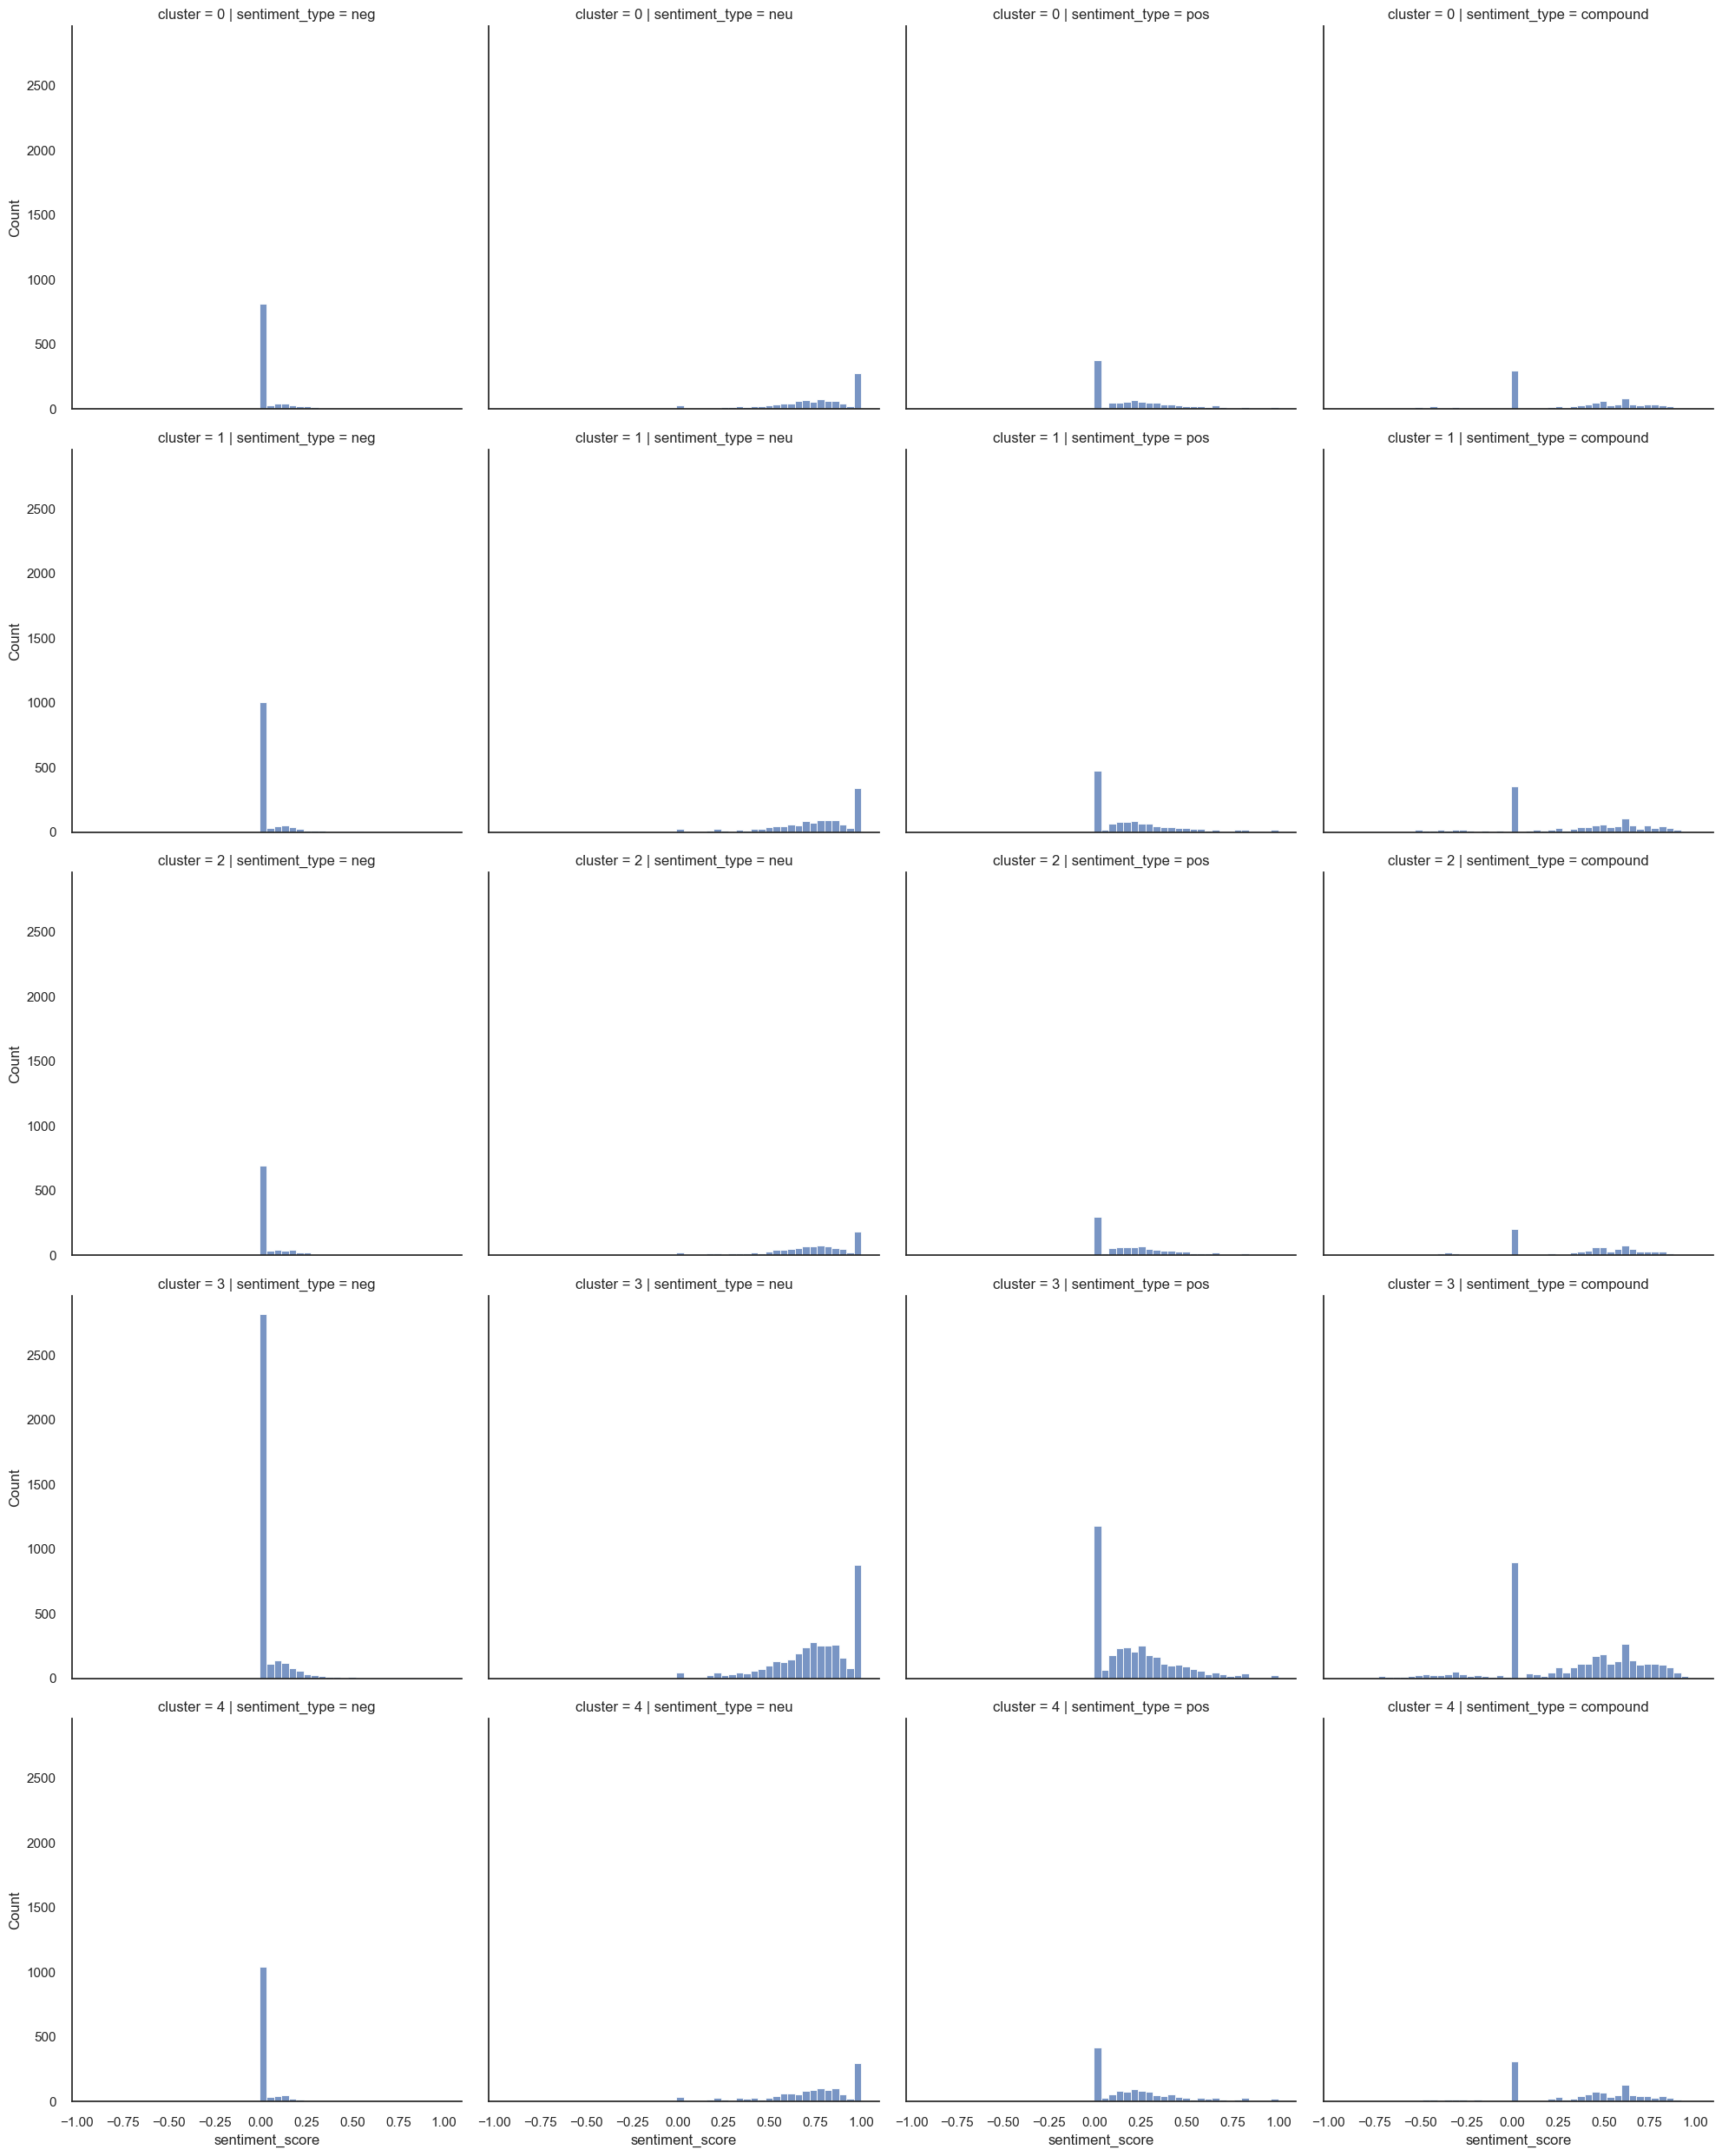

In [623]:
# sentiment score distribution by sentiment type and spending_score-category
sns.displot(data = reviews_subset_long, \
            x = 'sentiment_score', row = 'cluster', col= 'sentiment_type' , kind='hist')

There is no noticeable difference in patterns of sentiment score distribution across clusters 

In [625]:
reviews_subset['sentiment_cat'] = ''
reviews_subset['sentiment_cat'][reviews_subset['compound'] > 0.05] = 'positive'
reviews_subset['sentiment_cat'][reviews_subset['compound'] < 0.05] = 'negative'
reviews_subset['sentiment_cat'][reviews_subset['compound'] == 0] = 'neutral'

#### VIZ for report

In [627]:
pie = reviews_subset[['sentiment_cat', 'compound']].groupby(by='sentiment_cat').count()

In [628]:
pie.index

Index(['negative', 'neutral', 'positive'], dtype='object', name='sentiment_cat')

In [629]:
colors = ['#5102A3', '#D3D3D3', '#26C8C8']

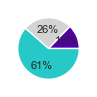

In [630]:
fig, ax1 = plt.subplots(figsize=(1,1))
plt.pie(pie['compound'], autopct='%1.0f%%', colors=colors, textprops={'fontsize': 8})

plt.savefig('VADER_pie.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution

plt.show()

In [631]:
# calculate neam scores by cat type
reviews_subset[['sentiment_cat', 'compound']].groupby(by = 'sentiment_cat').mean()

compound
sentiment_cat          
negative      -0.360573
neutral        0.000000
positive       0.553523

In [632]:
# calculate count scores by cat type
reviews_subset[['sentiment_cat', 'compound']].groupby(by = 'sentiment_cat').count()

compound
sentiment_cat          
negative           1003
neutral            2035
positive           4836

In [633]:
# calculate count scores by cat type
reviews_subset['compound'].describe()

count   7874.000000
mean       0.294028
std        0.382643
min       -0.932500
25%        0.000000
50%        0.367700
75%        0.624900
max        0.995900
Name: compound, dtype: float64

In [634]:
# calculate count scores by cat type
reviews_subset[['sentiment_cat', 'compound']].groupby(by = 'sentiment_cat').count().sum()

compound    7874
dtype: int64

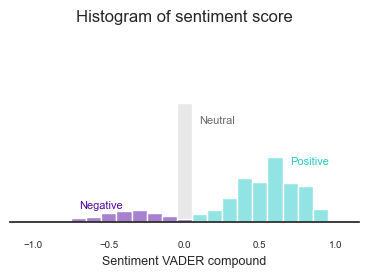

In [635]:
# Histogram of sentiment score
# set theme
custom_params = {"axes.spines.right": False, "axes.spines.left": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params)

# Create the figure and axis once
fig, ax1 = plt.subplots(figsize=(4.5,2.5))

# Create the histogram plot
# Create list from -1.05 to 1.05 with 0.1 step
bin_edges = list(np.arange(-1.05, 1.06, 0.1))

sns.histplot(data=reviews_subset, x='compound', bins=bin_edges, hue='sentiment_cat', hue_order=pie.index, kde=False, palette=colors, legend=False)

# Add annotation
ax1.text(x=0.7, y=1000, s='Positive', color='#26C8C8', fontsize=8, ha='left')
ax1.text(x=0.1, y=1700, s='Neutral', color='#696969', fontsize=8, ha='left')
ax1.text(x=-0.7, y=230, s='Negative', color='#5102A3', fontsize=8, ha='left')

ax1.set_ylim(0, 3300)

# Set the labels.
plt.xlabel('Sentiment VADER compound', fontsize=9)
ax1.tick_params(axis='x', labelsize = 7) 
plt.ylabel('', fontsize=12)
plt.title('Histogram of sentiment score', fontsize=12)

ax1.set_yticklabels([])

plt.savefig('VADER_sentiment_reviews.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution

plt.show()

### 4 Topic extraction: Word Clouds

#### 4.1  Positive sentimet: to reinforsce satisfaction

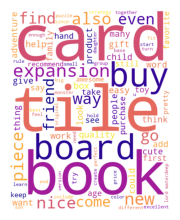

In [638]:
# select all sent_tokens with positive/neutral sentiment, where pos >= neg sentiment
reviews_gr = reviews_subset[(reviews_subset.pos > 0) & \
(reviews_subset.pos >= reviews_subset.neg) & (reviews_subset.compound > 0)]\
[['sent_tokens', 'word_tokens_clean', 'neg', 'neu', 'pos', 'compound']]\
.sort_values(by='compound', ascending=False)

exclude_words = []
# exclude_words that do not add value 
exclude_words = ['great', 'game', 'love', 'get', 'fun', 'good', 'make', 'like', 'well', 'use', 'would', 'time', 'kid', 'really', 'set', \
                 'enjoy', 'player', 'much', 'year', 'old', 'little', 'lot']

# String all the word tokens together in a single variable.
# Create an empty string variable.
wc_tokens = ''
for i in range(reviews_gr.shape[0]):
    # Add each comment.
    for word in reviews_gr['word_tokens_clean'].values[i]:
        # Add each filtered token word to the string unless it is selected to exclude
        if word not in exclude_words:
            wc_tokens = wc_tokens + word + ' '

# Create a word cloud
sns.set(color_codes=True)

# Create a WordCloud object.
word_cloud = WordCloud(width = 400, height = 500, 
                background_color ='white',
                colormap = 'plasma', 
                stopwords = 'none',
                min_font_size = 10).generate(wc_tokens) 

# Plot the WordCloud image
plt.figure(facecolor = None, figsize=(1.6,2.2)) 
plt.imshow(word_cloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 


plt.savefig('WC_3_pos.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution

plt.show()

In [639]:
# select the keyword to view
w = 'card'

# define a variable to store reviews containing w 
reviews_w = reviews_gr[reviews_gr['word_tokens_clean'].apply(lambda tokens: w in tokens)]

# view
print(f"{reviews_w.shape[0]} / {reviews_gr.shape[0]}")
reviews_w.style.set_properties(subset=['sent_tokens', 'word_tokens_clean'], **{'width': '1200px'})

211 / 4850


#### 4.2  Negative sentiment: areas for improvement

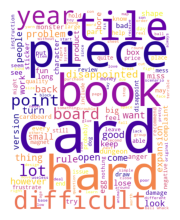

In [641]:
# Subset & define a variable

# select all sent_tokens with negative sentiment, where neg >= pos sentiment; clusters 2&4
reviews_gr = reviews_subset[(reviews_subset.neg > 0) & \
(reviews_subset.neg >= reviews_subset.pos) & (reviews_subset.compound < 0)]\
[['review_id', 'sent_tokens', 'word_tokens_clean', 'neg', 'neu', 'pos', 'compound']]\
.sort_values(by='compound', ascending=False)\

#exclude_words = []
exclude_words = ['game', 'like', 'make', 'get', 'player', 'use', 'much', 'set', 'would', 'need', 'time', 'even', 'kid', 'child', 'really', \
                 'first', 'bit', 'add', 'many', 'also', 'new', 'find', 'become', 'way', 'old', 'great', 'enough', 'together', 'go', 'daughter', \
                'think', 'little', 'well', 'take', 'could', 'buy', 'give']
                 

# String all the word tokens together in a single variable.
# Create an empty string variable.
wc_tokens = ''
for i in range(reviews_gr.shape[0]):
    # Add each comment.
    for word in reviews_gr['word_tokens_clean'].values[i]:
        # Add each filtered token word to the string unless it is selected to exclude
        if word not in exclude_words:
            wc_tokens = wc_tokens + word + ' '

# Create a word cloud
sns.set(color_codes=True)

# Create a WordCloud object.
word_cloud = WordCloud(width = 400, height = 500, 
                background_color ='white',
                colormap = 'plasma', 
                stopwords = 'none',
                min_font_size = 10).generate(wc_tokens) 

# Plot the WordCloud image
plt.figure(facecolor = None, figsize=(1.6,2.2)) 
plt.imshow(word_cloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 

plt.savefig('WC_3_neg.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution

plt.show()

In [642]:
# select the keyword to view
w = 'hard'

# define a variable to store reviews containing w 
reviews_w = reviews_gr[reviews_gr['word_tokens_clean'].apply(lambda tokens: w in tokens)]

# view
print(f"{reviews_w.shape[0]} / {reviews_gr.shape[0]}")
reviews_w.style.set_properties(subset=['sent_tokens', 'word_tokens_clean'], **{'width': '1200px'})

39 / 971


There is a recurring concern that games are too challenging for younger users

#  

# Observations and Recommendations Summary  

**Observations and predictions**

- Customers can be grouped into five clusters based on spending score & remuneration and three groups based on spending score category:
1) ‘High’ spending score:
   - Cluster 4: High-Value Customers (high-income)
   - Cluster 2: Limited-Potential Customers (low-income)
2) ‘Moderate’ spending score:
   - Cluster 3: Moderate spenders (average income)
3) ‘Low’ spending score:
   - Cluster 1: High-Potential Customers (high-income)
   - Cluster 0: Low-Value Customers (low-income)
- The 30-40 age group is the most common across all clusters. Customers over 40 appear underrepresented particularly in higher-earning clusters.
- Remuneration does not vary by gender, age or education level. 
- MLR and DT suggest that remuneration and spending scores have a very strong positive correlation with loyalty points and best explain the variance in loyalty point balances.
- Spending-score-category-specific LR models satisfy mandatory LR assumptions and as such can produce unbiased estimates of loyalty points. 
- The lines of the best fit in clusters with higher spending scores have higher independent variable coefficients (higher slope) and for this reason exhibit greater income elasticity.
- The best predictive power and accuracy are achieved when analysing spending score segments in isolation from each other.  We recommend using ensemble techniques to predict loyalty points, incorporating both clustering and linear regression.
- Regression analysis indicates that increasing spending scores in cluster 1 and cluster 3 by one spending score category up to 50 and 80 points respectively can drive average loyalty points balances up to 2,910 and 1816, respectively, resulting in c.30% increase in total loyalty points.
- Sentiment analysis shows a wide range of scores, from -0.93 to 0.99, but positive sentiment dominates at 61%, with an average score of 0.55 in this group
- Customer sentiment scores and distribution patterns seem to be consistent across clusters and spending score categories
- There is a recurring concern that the games are too challenging for younger users


**Business recommendations**
- Focus on higher- and average-income clusters with lower spending scores targeting an increase in engagement: 
    - Cluster 1: High growth potential with opportunities to increase loyalty points balances by 3–4 times.
    - Cluster 3 (Strategic Segment): This segment represents one-third of the customer base and revenue, warranting prioritisation despite moderate growth potential (up to  30%).
- Cluster 4 (High-Value): Use premium loyalty programmes and personalised strategies to maximise retention and lifetime value.
- Cluster 2 (Price-Sensitive): Deploy cost-saving promotions to engage this low-growth audience.
- Cluster 0 (Low-Value): Limit marketing investment due to minimal purchasing power and growth potential.
- Leverage referral campaigns via Clusters 4 and 3 to drive cost-effective customer acquisition through existing networks.
- Monitor sentiment scores and Net Promoter Score (NPS) to evaluate campaign impact and loyalty trends.
- Use surveys to address negative feedback and recurring concerns including product quality, unclear rules, and complexity and to guide product improvements


**Recommendations for future data analysis, data collection**
1) Sampling & biases: 
    - The non-random sample composition (10 reviews per product) may introduce bias, as it might not reflect the actual sales structure by cluster/product and misrepresent certain demographic groups or products (Appendix 3).
    - The sample is limited to customers who left reviews, which may not represent the opinions of all relevant groups.

2) Data collection:
    - There may be a technical issue in the product column. A brief analysis suggests that the product feature appears inconsistent, with a single ID being assigned to multiple different product types (Appendix 3).
    - Introducing time-stamped customer reviews will allow Turtle Games to monitor changes over time (e.g., how sentiment evolves) and evaluate the impact of campaigns on customer satisfaction more effectively by comparing pre- and post-campaign data.
    - When developing a marketing strategy by customer cluster, it is crucial to consider not only cluster characteristics but also cluster size in terms of customer count and revenue share. A more effective approach would involve analysing the contribution margin level to account for profitability.


#    

#    